# Recommendation system for restaurants
### Based on the [Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset).  

## 0. Libraries
First of all, we define all the libraries we need.

In [1]:
from matplotlib.ticker import PercentFormatter as _PercentFormatter
import matplotlib.pyplot as _plt
import numpy as _np
import pandas as _pd
import joblib as _jl
import glob as _glob
import os as _os
import re as _re
import time as _time
from multiprocessing import Pool as _Pool
from sklearn.preprocessing import OrdinalEncoder as _OrdinalEncoder, binarize as _binarize
from sklearn.metrics import confusion_matrix as _confusion_matrix, roc_curve as _roc_curve, classification_report as _classification_report, accuracy_score as _accuracy_score
from sklearn.model_selection import GridSearchCV as _GridSearchCV
from sklearn.svm import LinearSVC as _LinearSVC
from sklearn.ensemble import RandomForestClassifier as _RandomForestClassifier
from keras.models import Sequential as _Sequential, load_model as _load_model
from keras.layers import Dense as _Dense

_pd.set_option('display.max_columns', None)

Using TensorFlow backend.


Since we are going to use big datasets, and we'll need to load them more
times, we define a commodity function that deletes all user defined variables,
in order to free some memory.

In [2]:
def _del_all():
    %reset_selective -f [^_]

## 1. Data cleaning
### Based on the [kernel by Hou, Saha, Tsang](https://www.kaggle.com/wenqihou828/recommendation-for-yelp-users-itself).

We execute the code in ```recommendation_system_preprocessing.ipynb``` in order to
clean the data and to reduce the size of the dataset, using pickles instead of json and dropping unnecessary columns.

We explore the resulting datasets: 

In [5]:
dataset_list = _glob.glob("../dataset/[!checked]*.pickle")
for d in dataset_list:
    dataset = _pd.read_pickle(d)
    
    f = _os.path.splitext(_os.path.basename(d))[0]
    c = ", ".join(list(dataset.columns))
    s = dataset.shape
    
    print("Dataset '" + f + "':")
    print("\tfeatures:", c)
    print("\tshape:", s)
    print()

Dataset 'all_checkin':
	features: business_id, date
	shape: (57402, 2)

Dataset 'all_review':
	features: review_id, user_id, business_id, stars, useful, funny, cool, text, date
	shape: (4201684, 9)

Dataset 'all_tips':
	features: restaurant_name, tips_date, user_id
	shape: (770878, 3)

Dataset 'all_users':
	features: user_id, user_name, average_stars, yelping_since, review, years_of_elite, fans, useful, cool, funny, friends
	shape: (1148098, 11)

Dataset 'restaurants':
	features: name, business_id, address, cuisine, postal_code, latitude, longitude, review_count, stars, OutdoorSeating, BusinessAcceptsCreditCards, RestaurantsDelivery, RestaurantsReservations, WiFi, Alcohol, categories, city, Monday_Open, Tuesday_Open, Wednesday_Open, Thursday_Open, Friday_Open, Saturday_Open, Sunday_Open, Monday_Close, Tuesday_Close, Wednesday_Close, Thursday_Close, Friday_Close, Saturday_Close, Sunday_Close
	shape: (59371, 31)



In [10]:
_del_all()

## 2. Fake Review Detection
### Based on Zhiwei Zhang's [work](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781) and [code](https://github.com/zzhang83/Yelp_Sentiment_Analysis).

Then, in order to filter out deceptive reviews, that could alter the results
of our analysis, we load the model based on Support Vector Machine
defined in ```Yelp_sentiment_analysis/Scripts/fake_reviews.ipynb```
by [Zhiwei Zhang](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781),
that has the best scores for accuracy, precision, recall and f1-score.

In [2]:
vectorizer = _jl.load('../models/tfidf_vectorizer.joblib')
svc = _jl.load('../models/fake_review_svc_model.joblib')

Now, we can apply this model to our data.

In [4]:
review = _pd.read_pickle("../dataset/all_review.pickle")

review.head()

review_id                 user_id             business_id  \
3   yi0R0Ugj_xUx_Nek0-_Qig  dacAIZ6fTM6mqwW5uxkskg  ikCg8xy5JIg_NGPx-MSIDA   
5   fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw  eU_713ec6fTGNO4BegRaww   
6   G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ  3fw2X5bZYeW9xCz_zGhOHg   
7   8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA  zvO-PJCpNk4fgAVUnExYAA   
10  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA  8mIrX_LrOnAqWsB5JrOojQ   

    stars  useful  funny  cool  \
3       5       0      0     0   
5       4       0      0     0   
6       3       5      4     5   
7       1       3      1     1   
10      4       0      0     0   

                                                 text                date  
3   Went in for a lunch. Steak sandwich was delici... 2018-01-09 20:56:38  
5   I'll be the first to admit that I was not exci... 2013-01-20 13:25:59  
6   Tracy dessert had a big name in Hong Kong and ... 2016-05-07 01:21:02  
7   This place has gone down hill.  Clearly they h... 2010-10-05 19:12:35  
10  Like walking back in time, every Saturday morn... 2011-11-30 02:11:15

In [5]:
texts = list(review["text"])
X = vectorizer.transform(texts)
predictions = svc.predict(X)

In [6]:
print(type(predictions))
print("SVC predictions:", predictions)

<class 'numpy.ndarray'>
SVC predictions: [1 1 1 ... 1 1 1]


Now we repeat the whole process with a different model that allows us to
obtain real weights instead of a binary evaluation. 

In [7]:
cal_svc = _jl.load('../models/fake_review_cal_svc_model.joblib')
cal_predictions = cal_svc.predict_proba(X)


In [8]:
print("Calibrated SVC predictions:\n", cal_predictions)
cal_predictions = _np.array([x[1] for x in cal_predictions])
print("Calibrated SVC predictions for class '1':\n", cal_predictions)

Calibrated SVC predictions:
 [[0.12112422 0.87887578]
 [0.011      0.989     ]
 [0.03538102 0.96461898]
 ...
 [0.36147536 0.63852464]
 [0.00379598 0.99620402]
 [0.00133685 0.99866315]]
Calibrated SVC predictions for class '1':
 [0.87887578 0.989      0.96461898 ... 0.63852464 0.99620402 0.99866315]


In [9]:
print("columns before:\n", review.columns)
checked_review = review.assign(bin_truth_score=predictions, real_truth_score=cal_predictions)
print("columns after:\n", checked_review.columns)

columns before:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
columns after:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


Let's see what we just obtained.

In [10]:
checked_review[['review_id', 'text', 'bin_truth_score', 'real_truth_score']].head()

review_id                                               text  \
3   yi0R0Ugj_xUx_Nek0-_Qig  Went in for a lunch. Steak sandwich was delici...   
5   fdiNeiN_hoCxCMy2wTRW9g  I'll be the first to admit that I was not exci...   
6   G7XHMxG0bx9oBJNECG4IFg  Tracy dessert had a big name in Hong Kong and ...   
7   8e9HxxLjjqc9ez5ezzN7iQ  This place has gone down hill.  Clearly they h...   
10  kbtscdyz6lvrtGjD1quQTg  Like walking back in time, every Saturday morn...   

    bin_truth_score  real_truth_score  
3                 1          0.878876  
5                 1          0.989000  
6                 1          0.964619  
7                 1          0.867897  
10                1          0.975404

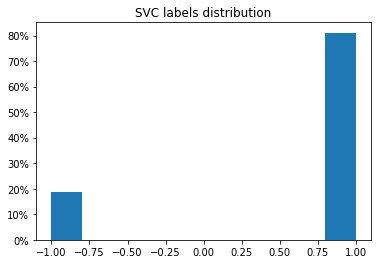

In [11]:
data = checked_review['bin_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

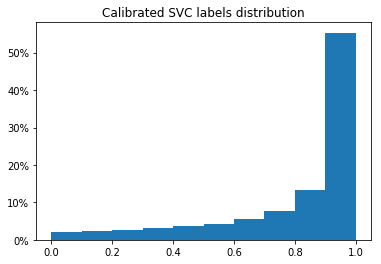

In [12]:
data = checked_review['real_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("Calibrated SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

Finally, we can save the new dataset without the ```text``` column,
in order to save space and computation time.  

In [17]:
checked_review.drop(columns=['text'], inplace=True)
checked_review.to_pickle('../dataset/checked_review.pickle')

Check that everything has worked properly. 

In [18]:
final_review = _pd.read_pickle('../dataset/checked_review.pickle')
print(final_review.columns)
final_review.head()

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


review_id                 user_id             business_id  \
3   yi0R0Ugj_xUx_Nek0-_Qig  dacAIZ6fTM6mqwW5uxkskg  ikCg8xy5JIg_NGPx-MSIDA   
5   fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw  eU_713ec6fTGNO4BegRaww   
6   G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ  3fw2X5bZYeW9xCz_zGhOHg   
7   8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA  zvO-PJCpNk4fgAVUnExYAA   
10  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA  8mIrX_LrOnAqWsB5JrOojQ   

    stars  useful  funny  cool                date  bin_truth_score  \
3       5       0      0     0 2018-01-09 20:56:38                1   
5       4       0      0     0 2013-01-20 13:25:59                1   
6       3       5      4     5 2016-05-07 01:21:02                1   
7       1       3      1     1 2010-10-05 19:12:35                1   
10      4       0      0     0 2011-11-30 02:11:15                1   

    real_truth_score  
3           0.878876  
5           0.989000  
6           0.964619  
7           0.867897  
10          0.975404

In [ ]:
_del_all()

## 3. Historical features

Following [this paper](https://www.semanticscholar.org/paper/Restaurant-Recommendation-System-Gandhe/093cecc3e53f2ba4c0c466ad3d8294ba64962050),
we add some historical features to our dataset:
1. user-level features:
    <br>1.1. average of the ratings given by a certain user,
    <br>1.2. number of reviews written by a certain user,
2. business-level features:
    <br>2.1. average of the ratings given to a certain restaurant,
    <br>2.2. number of reviews written about a certain restaurant,
3. user-business features:
    <br>3.1. average rating given by a certain user to each category,
    <br>3.2. average of the ratings given by a certain user to the categories of a certain restaurant.

Before proceeding with the computation of the new features, we have to split the dataset in three parts:
1. <i>Test set</i>, from the last day considered in the dataset, to the previous `M` months;
2. <i>Training set</i>, from the day before the beginning of the test set, up to `N` months before;
3. <i>History</i>, the remaining part of the dataset, used to compute historical features.

We pick `m=3` and `n=8`, so the test set goes from 9/1/2018 to 11/30/2018, the training set goes
from 1/1/2018 to 8/31/2018, the history contains the remaining data, from 10/12/2004 to 12/31/2017.

In [5]:
review_all = _pd.read_pickle("../dataset/checked_review.pickle")
review_test = review_all[review_all['date']>=_np.datetime64('2018-09-01')]
review_train = review_all[(review_all['date']>=_np.datetime64('2018-01-01')) & (review_all['date']<_np.datetime64('2018-09-01'))]
# review_hist = review_all[review_all['date']<_np.datetime64('2018-01-01')]

review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
# review_hist.to_pickle('../dataset/m2_n9/review_hist.pickle')

In [13]:
tips_all = _pd.read_pickle("../dataset/all_tips.pickle")
tips_test = tips_all[tips_all['tips_date']>=_np.datetime64('2018-10-01')]
tips_train = tips_all[(tips_all['tips_date']>=_np.datetime64('2018-01-01')) & (tips_all['tips_date']<_np.datetime64('2018-10-01'))]
tips_hist = tips_all[tips_all['tips_date']<_np.datetime64('2018-01-01')]

tips_test.to_pickle('../dataset/m2_n9/tips_test.pickle')
tips_train.to_pickle('../dataset/m2_n9/tips_train.pickle')
tips_hist.to_pickle('../dataset/m2_n9/tips_hist.pickle')

In [18]:
_del_all()

### User-level features

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
users = _pd.read_pickle("../dataset/all_users.pickle")

In [8]:
avg_stars = review_hist['stars'].mean()

users = users.assign(average_stars=avg_stars)
users = users.assign(num_reviews=0)
users = users.assign(average_stars_bin=avg_stars)
users = users.assign(num_reviews_bin=0)
users = users.assign(average_stars_real=avg_stars)
users = users.assign(num_reviews_real=0)
users = users.set_index('user_id')
users.head()

user_name  average_stars yelping_since  review  \
user_id                                                                 
l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.703313    2013-10-08      95   
4XChL029mKr5hydo79Ljxg     Jenna       3.703313    2013-02-21      33   
bc8C_eETBWL0olvFSJJd0w     David       3.703313    2013-10-04      16   
dD0gZpBctWGdWo9WlGuhlA    Angela       3.703313    2014-05-22      17   
MM4RJAeH6yuaN8oZDSt0RA     Nancy       3.703313    2013-10-23     361   

                        years_of_elite  fans  useful  cool  funny  friends  \
user_id                                                                      
l6BmjZMeQD3rDxWUbiAiow               3     5      84    25     17     2374   
4XChL029mKr5hydo79Ljxg               0     4      48    16     22    27646   
bc8C_eETBWL0olvFSJJd0w               0     0      28    10      8      358   
dD0gZpBctWGdWo9WlGuhlA               0     5      30    14      4    12598   
MM4RJAeH6yuaN8oZDSt0RA               4    39    1114   665    279     5542   

                        num_reviews  average_stars_bin  num_reviews_bin  \
user_id                                                                   
l6BmjZMeQD3rDxWUbiAiow            0           3.703313                0   
4XChL029mKr5hydo79Ljxg            0           3.703313                0   
bc8C_eETBWL0olvFSJJd0w            0           3.703313                0   
dD0gZpBctWGdWo9WlGuhlA            0           3.703313                0   
MM4RJAeH6yuaN8oZDSt0RA            0           3.703313                0   

                        average_stars_real  num_reviews_real  
user_id                                                       
l6BmjZMeQD3rDxWUbiAiow            3.703313                 0  
4XChL029mKr5hydo79Ljxg            3.703313                 0  
bc8C_eETBWL0olvFSJJd0w            3.703313                 0  
dD0gZpBctWGdWo9WlGuhlA            3.703313                 0  
MM4RJAeH6yuaN8oZDSt0RA            3.703313                 0

In [3]:
def _f(grouped):
    d = {}
    
    d['num'] = grouped['stars'].size
    d['stars'] = grouped['stars'].mean()
    
    non_fake = _np.ma.masked_where(grouped['bin_truth_score']<=0, grouped['stars']).compressed()
    d['num_bin'] = non_fake.size
    d['stars_bin'] = non_fake.mean()
    
    d['num_real'] = grouped['real_truth_score'].sum()
    d['stars_real'] = _np.average(grouped['stars'], weights=grouped['real_truth_score'])
    
    return _pd.Series(d, index=['num', 'stars', 'num_bin', 'stars_bin', 'num_real', 'stars_real'])

In [ ]:
grouped_reviews = review_hist.groupby('user_id').apply(_f)
grouped_reviews.head()

In [18]:
import random
import statistics

current_milli_time = lambda: int(round(_time.time() * 1000))

def get_time(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test"]] = x
    t0 = current_milli_time()
    return t0-t

def get_time_mul(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    y = random.randrange(1000)
    z = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test", "ciao", "prova"]] = [x, y, z]
    t0 = current_milli_time()
    return t0-t

def test():
    df = users.copy()
    df['test'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def test_mul():
    df = users.copy()
    df['test'] = -1
    df['ciao'] = -1
    df['prova'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def tot_time(ops, x, k):
    time_millis = ops * k * x
    hours = time_millis/1000/60/60
    return hours

tot = len(grouped_reviews)
x = test()
print("hours:", tot_time(tot, x, 6))
x = test_mul()
print("hours mul:", tot_time(tot, x, 1))

hours: 53.065662455
hours mul: 8.774814544166667


In [9]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    users.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 954447
row 1000/954447 - 0.10477271131870078%
row 2000/954447 - 0.20954542263740156%
row 3000/954447 - 0.31431813395610236%
row 4000/954447 - 0.4190908452748031%
row 5000/954447 - 0.5238635565935038%
row 6000/954447 - 0.6286362679122047%
row 7000/954447 - 0.7334089792309054%
row 8000/954447 - 0.8381816905496062%
row 9000/954447 - 0.942954401868307%
row 10000/954447 - 1.0477271131870076%
[...]
row 945000/954447 - 99.01021219617223%
row 946000/954447 - 99.11498490749094%
row 947000/954447 - 99.21975761880964%
row 948000/954447 - 99.32453033012834%
row 949000/954447 - 99.42930304144704%
row 950000/954447 - 99.53407575276574%
row 951000/954447 - 99.63884846408445%
row 952000/954447 - 99.74362117540313%
row 953000/954447 - 99.84839388672184%
row 954000/954447 - 99.95316659804054%


In [10]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users.pickle')
_del_all()

### Business-level features

In [4]:
restaurants = _pd.read_pickle("../dataset/restaurants.pickle")
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
avg_stars = review_hist['stars'].mean()

In [5]:
restaurants = restaurants.assign(average_stars=avg_stars)
restaurants = restaurants.assign(num_reviews=0)
restaurants = restaurants.assign(average_stars_bin=avg_stars)
restaurants = restaurants.assign(num_reviews_bin=0)
restaurants = restaurants.assign(average_stars_real=avg_stars)
restaurants = restaurants.assign(num_reviews_real=0)
restaurants = restaurants.set_index('business_id')
restaurants.head()

name  \
business_id                                           
QXAEGFB4oINsVuTFxEYKFQ   Emerald Chinese Restaurant   
gnKjwL_1w79qoiV3IC_xQQ  Musashi Japanese Restaurant   
1Dfx3zM-rW4n-31KeC8sJg                    Taco Bell   
fweCYi8FmbJXHCqLnwuk8w                Marco's Pizza   
PZ-LZzSlhSe9utkQYU8pFg   Carluccio's Tivoli Gardens   

                                             address   cuisine postal_code  \
business_id                                                                  
QXAEGFB4oINsVuTFxEYKFQ          30 Eglinton Avenue W   Chinese     L5R 3E7   
gnKjwL_1w79qoiV3IC_xQQ     10110 Johnston Rd, Ste 15  Japanese       28210   
1Dfx3zM-rW4n-31KeC8sJg       2450 E Indian School Rd   Mexican       85016   
fweCYi8FmbJXHCqLnwuk8w               5981 Andrews Rd   Italian       44060   
PZ-LZzSlhSe9utkQYU8pFg  1775 E Tropicana Ave, Ste 29   Italian       89119   

                         latitude   longitude  review_count  stars  \
business_id                                                          
QXAEGFB4oINsVuTFxEYKFQ  43.605499  -79.652289           128    2.5   
gnKjwL_1w79qoiV3IC_xQQ  35.092564  -80.859132           170    4.0   
1Dfx3zM-rW4n-31KeC8sJg  33.495194 -112.028588            18    3.0   
fweCYi8FmbJXHCqLnwuk8w  41.708520  -81.359556            16    4.0   
PZ-LZzSlhSe9utkQYU8pFg  36.100016 -115.128529            40    4.0   

                       OutdoorSeating BusinessAcceptsCreditCards  ...  \
business_id                                                       ...   
QXAEGFB4oINsVuTFxEYKFQ          False                        NaN  ...   
gnKjwL_1w79qoiV3IC_xQQ          False                       True  ...   
1Dfx3zM-rW4n-31KeC8sJg          False                       True  ...   
fweCYi8FmbJXHCqLnwuk8w          False                       True  ...   
PZ-LZzSlhSe9utkQYU8pFg          False                       True  ...   

                       Thursday_Close Friday_Close Saturday_Close  \
business_id                                                         
QXAEGFB4oINsVuTFxEYKFQ       00:00:00     01:00:00       01:00:00   
gnKjwL_1w79qoiV3IC_xQQ       21:30:00     22:00:00       22:00:00   
1Dfx3zM-rW4n-31KeC8sJg       01:00:00     01:00:00       01:00:00   
fweCYi8FmbJXHCqLnwuk8w       00:00:00     01:00:00       01:00:00   
PZ-LZzSlhSe9utkQYU8pFg            NaT          NaT            NaT   

                       Sunday_Close average_stars num_reviews  \
business_id                                                     
QXAEGFB4oINsVuTFxEYKFQ     00:00:00      3.703313           0   
gnKjwL_1w79qoiV3IC_xQQ     21:00:00      3.703313           0   
1Dfx3zM-rW4n-31KeC8sJg     00:00:00      3.703313           0   
fweCYi8FmbJXHCqLnwuk8w     00:00:00      3.703313           0   
PZ-LZzSlhSe9utkQYU8pFg          NaT      3.703313           0   

                       average_stars_bin num_reviews_bin average_stars_real  \
business_id                                                                   
QXAEGFB4oINsVuTFxEYKFQ          3.703313               0           3.703313   
gnKjwL_1w79qoiV3IC_xQQ          3.703313               0           3.703313   
1Dfx3zM-rW4n-31KeC8sJg          3.703313               0           3.703313   
fweCYi8FmbJXHCqLnwuk8w          3.703313               0           3.703313   
PZ-LZzSlhSe9utkQYU8pFg          3.703313               0           3.703313   

                       num_reviews_real  
business_id                              
QXAEGFB4oINsVuTFxEYKFQ                0  
gnKjwL_1w79qoiV3IC_xQQ                0  
1Dfx3zM-rW4n-31KeC8sJg                0  
fweCYi8FmbJXHCqLnwuk8w                0  
PZ-LZzSlhSe9utkQYU8pFg                0  

[5 rows x 36 columns]

In [6]:
grouped_reviews = review_hist.groupby('business_id').apply(_f)
grouped_reviews.head()

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


num     stars  num_bin  stars_bin     num_real  \
business_id                                                                 
--1UhMGODdWsrMastO9DZw    22.0  4.227273     14.0   4.214286    16.978214   
--6MefnULPED_I942VcFNA    38.0  3.157895     32.0   3.218750    33.948759   
--9e1ONYQuAa-CB_Rrw7Tw  1504.0  4.107048   1216.0   4.088816  1205.738732   
--DaPTJW3-tB1vP-PfdTEg    40.0  3.650000     33.0   3.575758    34.780500   
--FBCX-N37CMYDfs790Bnw   122.0  3.737705     90.0   3.611111    93.369750   

                        stars_real  
business_id                         
--1UhMGODdWsrMastO9DZw    4.267477  
--6MefnULPED_I942VcFNA    3.218815  
--9e1ONYQuAa-CB_Rrw7Tw    4.092415  
--DaPTJW3-tB1vP-PfdTEg    3.642790  
--FBCX-N37CMYDfs790Bnw    3.646290

In [7]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    restaurants.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 56850
row 1000/56850 - 1.759014951627089%
row 2000/56850 - 3.518029903254178%
row 3000/56850 - 5.277044854881266%
row 4000/56850 - 7.036059806508356%
row 5000/56850 - 8.795074758135444%
row 6000/56850 - 10.554089709762533%
row 7000/56850 - 12.313104661389621%
row 8000/56850 - 14.072119613016712%
row 9000/56850 - 15.8311345646438%
row 10000/56850 - 17.590149516270888%
[...]
row 47000/56850 - 82.67370272647318%
row 48000/56850 - 84.43271767810026%
row 49000/56850 - 86.19173262972735%
row 50000/56850 - 87.95074758135443%
row 51000/56850 - 89.70976253298153%
row 52000/56850 - 91.46877748460862%
row 53000/56850 - 93.22779243623572%
row 54000/56850 - 94.9868073878628%
row 55000/56850 - 96.74582233948989%
row 56000/56850 - 98.50483729111697%


In [8]:
restaurants = restaurants.reset_index()
restaurants.to_pickle('../dataset/m2_n9/restaurants.pickle')
_del_all()


### User - Business level features

#### 3.1. average rating given by a certain user to each category

In [2]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants.head()

business_id                         name  \
0  QXAEGFB4oINsVuTFxEYKFQ   Emerald Chinese Restaurant   
1  gnKjwL_1w79qoiV3IC_xQQ  Musashi Japanese Restaurant   
2  1Dfx3zM-rW4n-31KeC8sJg                    Taco Bell   
3  fweCYi8FmbJXHCqLnwuk8w                Marco's Pizza   
4  PZ-LZzSlhSe9utkQYU8pFg   Carluccio's Tivoli Gardens   

                        address   cuisine postal_code   latitude   longitude  \
0          30 Eglinton Avenue W   Chinese     L5R 3E7  43.605499  -79.652289   
1     10110 Johnston Rd, Ste 15  Japanese       28210  35.092564  -80.859132   
2       2450 E Indian School Rd   Mexican       85016  33.495194 -112.028588   
3               5981 Andrews Rd   Italian       44060  41.708520  -81.359556   
4  1775 E Tropicana Ave, Ste 29   Italian       89119  36.100016 -115.128529   

   review_count  stars OutdoorSeating  ... Thursday_Close Friday_Close  \
0           128    2.5          False  ...       00:00:00     01:00:00   
1           170    4.0          False  ...       21:30:00     22:00:00   
2            18    3.0          False  ...       01:00:00     01:00:00   
3            16    4.0          False  ...       00:00:00     01:00:00   
4            40    4.0          False  ...            NaT          NaT   

  Saturday_Close Sunday_Close average_stars num_reviews average_stars_bin  \
0       01:00:00     00:00:00      2.726496       117.0          2.718750   
1       22:00:00     21:00:00      4.063291       158.0          4.094203   
2       01:00:00     00:00:00      3.125000        16.0          2.769231   
3       01:00:00     00:00:00      4.230769        13.0          4.166667   
4            NaT          NaT      4.097561        41.0          4.212121   

  num_reviews_bin average_stars_real num_reviews_real  
0            96.0           2.730197        95.873087  
1           138.0           4.067541       139.112078  
2            13.0           2.847327        12.604125  
3            12.0           4.142021        10.965903  
4            33.0           4.167159        33.655622  

[5 rows x 37 columns]

In [5]:
restaurants.columns

Index(['business_id', 'name', 'address', 'cuisine', 'postal_code', 'latitude',
       'longitude', 'review_count', 'stars', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsDelivery',
       'RestaurantsReservations', 'WiFi', 'Alcohol', 'categories', 'city',
       'Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open',
       'Friday_Open', 'Saturday_Open', 'Sunday_Open', 'Monday_Close',
       'Tuesday_Close', 'Wednesday_Close', 'Thursday_Close', 'Friday_Close',
       'Saturday_Close', 'Sunday_Close', 'average_stars', 'num_reviews',
       'average_stars_bin', 'num_reviews_bin', 'average_stars_real',
       'num_reviews_real'],
      dtype='object')

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
review_hist.head()

review_id                 user_id             business_id  \
5   fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw  eU_713ec6fTGNO4BegRaww   
6   G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ  3fw2X5bZYeW9xCz_zGhOHg   
7   8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA  zvO-PJCpNk4fgAVUnExYAA   
10  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA  8mIrX_LrOnAqWsB5JrOojQ   
11  -I5umRTkhw15RqpKMl_o1Q  -mA3-1mN4JIEkqOtdbNXCQ  mRUVMJkUGxrByzMQ2MuOpA   

    stars  useful  funny  cool                date  bin_truth_score  \
5       4       0      0     0 2013-01-20 13:25:59                1   
6       3       5      4     5 2016-05-07 01:21:02                1   
7       1       3      1     1 2010-10-05 19:12:35                1   
10      4       0      0     0 2011-11-30 02:11:15                1   
11      1       0      1     0 2017-12-15 23:27:08                1   

    real_truth_score  
5           0.989000  
6           0.964619  
7           0.867897  
10          0.975404  
11          0.972826

In [4]:
joined_reviews = review_hist.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix='_review', rsuffix='_rest')
joined_reviews.head()

review_id                 user_id             business_id  \
5   fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw  eU_713ec6fTGNO4BegRaww   
6   G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ  3fw2X5bZYeW9xCz_zGhOHg   
7   8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA  zvO-PJCpNk4fgAVUnExYAA   
10  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA  8mIrX_LrOnAqWsB5JrOojQ   
11  -I5umRTkhw15RqpKMl_o1Q  -mA3-1mN4JIEkqOtdbNXCQ  mRUVMJkUGxrByzMQ2MuOpA   

    stars_review  useful  funny  cool                date  bin_truth_score  \
5              4       0      0     0 2013-01-20 13:25:59                1   
6              3       5      4     5 2016-05-07 01:21:02                1   
7              1       3      1     1 2010-10-05 19:12:35                1   
10             4       0      0     0 2011-11-30 02:11:15                1   
11             1       0      1     0 2017-12-15 23:27:08                1   

    real_truth_score  ... Thursday_Close Friday_Close Saturday_Close  \
5           0.989000  ...       22:00:00     23:00:00       23:00:00   
6           0.964619  ...       00:00:00     02:00:00       02:00:00   
7           0.867897  ...       22:00:00     23:00:00       23:00:00   
10          0.975404  ...       23:00:00     00:00:00       00:00:00   
11          0.972826  ...       00:00:00     02:00:00       02:00:00   

   Sunday_Close  average_stars  num_reviews  average_stars_bin  \
5           NaT       3.642276        123.0           3.594059   
6      00:00:00       3.292453        106.0           3.320000   
7      23:00:00       2.655172         29.0           2.875000   
10     23:00:00       4.491259       1144.0           4.499535   
11     00:00:00       3.666667         12.0           3.833333   

    num_reviews_bin average_stars_real num_reviews_real  
5             101.0           3.596369        99.505441  
6             100.0           3.289493        94.480786  
7              24.0           2.727490        23.413530  
10           1075.0           4.502904      1031.313358  
11              6.0           3.650460         7.482296  

[5 rows x 46 columns]

In [8]:
categories = ', '.join(list(restaurants['categories'].unique()))
categories = categories.split(', ')
print(len(categories))

cat = []
for h in categories:
    if h not in cat:
        cat.append(h)
        
print(len(cat))

cuisines = ', '.join(list(restaurants['cuisine'].unique()))
cuisines = cuisines.split(', ')
print(len(cuisines))

_cuisines_unique = []
for cuisine in cuisines:
    if not cuisine in _cuisines_unique:
        _cuisines_unique.append(cuisine)
        
print("Number of cuisines: {0}".format(len(_cuisines_unique)))
print(_cuisines_unique)

173884
761
249
Number of cuisines: 10
['Chinese', 'Japanese', 'Mexican', 'Italian', 'Others', 'American', 'Korean', 'Mediterranean', 'Thai', 'Asian Fusion']


In [5]:
joined_reviews.to_pickle('../dataset/m2_n9/join_restaurants_reviewhist.pickle')

In [ ]:
_del_all()

Checkpoint

In [ ]:
joined_reviews =  _pd.read_pickle('../dataset/m2_n9/join_restaurants_reviewhist.pickle')
joined_reviews.head()

index               review_id                 user_id  \
0      5  fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw   
1      6  G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ   
2      7  8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA   
3     10  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA   
4     11  -I5umRTkhw15RqpKMl_o1Q  -mA3-1mN4JIEkqOtdbNXCQ   

              business_id  stars_review  useful  funny  cool  \
0  eU_713ec6fTGNO4BegRaww             4       0      0     0   
1  3fw2X5bZYeW9xCz_zGhOHg             3       5      4     5   
2  zvO-PJCpNk4fgAVUnExYAA             1       3      1     1   
3  8mIrX_LrOnAqWsB5JrOojQ             4       0      0     0   
4  mRUVMJkUGxrByzMQ2MuOpA             1       0      1     0   

                 date  bin_truth_score  ...  Thursday_Close Friday_Close  \
0 2013-01-20 13:25:59                1  ...        22:00:00     23:00:00   
1 2016-05-07 01:21:02                1  ...        00:00:00     02:00:00   
2 2010-10-05 19:12:35                1  ...        22:00:00     23:00:00   
3 2011-11-30 02:11:15                1  ...        23:00:00     00:00:00   
4 2017-12-15 23:27:08                1  ...        00:00:00     02:00:00   

  Saturday_Close Sunday_Close average_stars  num_reviews  average_stars_bin  \
0       23:00:00          NaT      3.642276        123.0           3.594059   
1       02:00:00     00:00:00      3.292453        106.0           3.320000   
2       23:00:00     23:00:00      2.655172         29.0           2.875000   
3       00:00:00     23:00:00      4.491259       1144.0           4.499535   
4       02:00:00     00:00:00      3.666667         12.0           3.833333   

   num_reviews_bin  average_stars_real num_reviews_real  
0            101.0            3.596369        99.505441  
1            100.0            3.289493        94.480786  
2             24.0            2.727490        23.413530  
3           1075.0            4.502904      1031.313358  
4              6.0            3.650460         7.482296  

[5 rows x 47 columns]

In [ ]:
# joined_reviews = joined_reviews.reset_index()
joined_reviews = joined_reviews[['review_id', 'user_id', 'business_id', 'bin_truth_score', 'real_truth_score', 'cuisine', 'stars_review']]
joined_reviews.head()

review_id                 user_id             business_id  \
0  fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw  eU_713ec6fTGNO4BegRaww   
1  G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ  3fw2X5bZYeW9xCz_zGhOHg   
2  8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA  zvO-PJCpNk4fgAVUnExYAA   
3  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA  8mIrX_LrOnAqWsB5JrOojQ   
4  -I5umRTkhw15RqpKMl_o1Q  -mA3-1mN4JIEkqOtdbNXCQ  mRUVMJkUGxrByzMQ2MuOpA   

   bin_truth_score  real_truth_score   cuisine  stars_review  
0                1          0.989000   Italian             4  
1                1          0.964619   Chinese             3  
2                1          0.867897  American             1  
3                1          0.975404    Others             4  
4                1          0.972826  American             1

In [ ]:
def each_cuisine_ratings(grouped):
    d = {}
    index = []
    for cuisine in _cuisines_unique:
        cuisine_av = cuisine + "_av"
        cuisine_records = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['stars_review']).compressed()
        d[cuisine_av] = cuisine_records.mean()
        index.append(cuisine_av)
   
    for cuisine in _cuisines_unique:
        cuisine_av_bin = cuisine + "_av_bin"
        non_fake = grouped[grouped['bin_truth_score'] > 0]
        cuisine_records = _np.ma.masked_where(~non_fake['cuisine'].str.contains(cuisine), non_fake['stars_review']).compressed()
        d[cuisine_av_bin] = cuisine_records.mean()
        index.append(cuisine_av_bin)
  
    for cuisine in _cuisines_unique:
        cuisine_av_real = cuisine + "_av_real"
        cuisine_records = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['stars_review']).compressed()
        cuisine_truth_score = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['real_truth_score']).compressed()
        d[cuisine_av_real] = _np.ma.average(cuisine_records, weights = cuisine_truth_score)
        index.append(cuisine_av_real)
     
    return _pd.Series(d, index = index)  

In [ ]:
grouped_reviews = joined_reviews.groupby('user_id').apply(each_cuisine_ratings)

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\ma\extras.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


In [ ]:
grouped_reviews.head()

Chinese_av  Japanese_av  Mexican_av  Italian_av  \
user_id                                                                   
---1lKK3aKOuomHnwAkAow         NaN     2.333333    3.666667    3.166667   
---PLwSf5gKdIoVnyRHgBA         NaN          NaN         NaN         NaN   
---cu1hq55BP9DWVXXKHZg         NaN          NaN    4.000000         NaN   
---udAKDsn0yQXmzbWQNSw         NaN          NaN         NaN         NaN   
--0RtXvcOIE4XbErYca6Rw         NaN          NaN         NaN         NaN   

                        Others_av  American_av  Korean_av  Mediterranean_av  \
user_id                                                                       
---1lKK3aKOuomHnwAkAow   4.352941       3.9375        4.0               NaN   
---PLwSf5gKdIoVnyRHgBA   3.000000          NaN        NaN               NaN   
---cu1hq55BP9DWVXXKHZg        NaN          NaN        NaN               NaN   
---udAKDsn0yQXmzbWQNSw   5.000000          NaN        NaN               NaN   
--0RtXvcOIE4XbErYca6Rw   4.000000          NaN        NaN               NaN   

                        Thai_av  Asian Fusion_av  ...  Chinese_av_real  \
user_id                                           ...                    
---1lKK3aKOuomHnwAkAow     3.25              3.5  ...              NaN   
---PLwSf5gKdIoVnyRHgBA      NaN              NaN  ...              NaN   
---cu1hq55BP9DWVXXKHZg      NaN              1.0  ...              NaN   
---udAKDsn0yQXmzbWQNSw     4.00              NaN  ...              NaN   
--0RtXvcOIE4XbErYca6Rw      NaN              NaN  ...              NaN   

                        Japanese_av_real  Mexican_av_real  Italian_av_real  \
user_id                                                                      
---1lKK3aKOuomHnwAkAow          2.035809         3.720609         3.226154   
---PLwSf5gKdIoVnyRHgBA               NaN              NaN              NaN   
---cu1hq55BP9DWVXXKHZg               NaN         4.000000              NaN   
---udAKDsn0yQXmzbWQNSw               NaN              NaN              NaN   
--0RtXvcOIE4XbErYca6Rw               NaN              NaN              NaN   

                        Others_av_real  American_av_real  Korean_av_real  \
user_id                                                                    
---1lKK3aKOuomHnwAkAow        4.524134          3.963953             4.0   
---PLwSf5gKdIoVnyRHgBA        3.000000               NaN             NaN   
---cu1hq55BP9DWVXXKHZg             NaN               NaN             NaN   
---udAKDsn0yQXmzbWQNSw        5.000000               NaN             NaN   
--0RtXvcOIE4XbErYca6Rw        4.000000               NaN             NaN   

                        Mediterranean_av_real  Thai_av_real  \
user_id                                                       
---1lKK3aKOuomHnwAkAow                    NaN      3.134858   
---PLwSf5gKdIoVnyRHgBA                    NaN           NaN   
---cu1hq55BP9DWVXXKHZg                    NaN           NaN   
---udAKDsn0yQXmzbWQNSw                    NaN      4.000000   
--0RtXvcOIE4XbErYca6Rw                    NaN           NaN   

                        Asian Fusion_av_real  
user_id                                       
---1lKK3aKOuomHnwAkAow              3.443446  
---PLwSf5gKdIoVnyRHgBA                   NaN  
---cu1hq55BP9DWVXXKHZg              1.000000  
---udAKDsn0yQXmzbWQNSw                   NaN  
--0RtXvcOIE4XbErYca6Rw                   NaN  

[5 rows x 30 columns]

Checkpoint 2

In [3]:
users = _pd.read_pickle('../dataset/m2_n9/users.pickle')
users.head()

user_id user_name  average_stars yelping_since  review  \
0  l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
1  4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
2  bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
3  dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
4  MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

   years_of_elite  fans  useful  cool  funny  friends  num_reviews  \
0               3     5      84    25     17     2374          2.0   
1               0     4      48    16     22    27646         12.0   
2               0     0      28    10      8      358         13.0   
3               0     5      30    14      4    12598          1.0   
4               4    39    1114   665    279     5542          5.0   

   average_stars_bin  num_reviews_bin  average_stars_real  num_reviews_real  
0           3.000000              2.0            3.017247          1.957334  
1           3.777778              9.0            3.626019          9.280533  
2           3.500000             12.0            3.326528         10.350275  
3                NaN              0.0            5.000000          0.329341  
4           4.400000              5.0            4.378799          4.720870

In [4]:
users = users.assign(av_rat_chinese_cuisine = _np.nan, av_rat_japanese_cuisine = _np.nan, av_rat_mexican_cuisine = _np.nan, 
                     av_rat_italian_cuisine = _np.nan, av_rat_others_cuisine = _np.nan, av_rat_american_cuisine = _np.nan, 
                     av_rat_korean_cuisine = _np.nan, av_rat_mediterranean_cuisine = _np.nan, av_rat_thai_cuisine = _np.nan, 
                     av_rat_asianfusion_cuisine = _np.nan)

users = users.assign(av_rat_chinese_cuisine_bin = _np.nan, av_rat_japanese_cuisine_bin = _np.nan, av_rat_mexican_cuisine_bin = _np.nan, 
                     av_rat_italian_cuisine_bin = _np.nan, av_rat_others_cuisine_bin = _np.nan, av_rat_american_cuisine_bin = _np.nan, 
                     av_rat_korean_cuisine_bin = _np.nan, av_rat_mediterranean_cuisine_bin = _np.nan, av_rat_thai_cuisine_bin = _np.nan, 
                     av_rat_asianfusion_cuisine_bin = _np.nan)

users = users.assign(av_rat_chinese_cuisine_real = _np.nan, av_rat_japanese_cuisine_real = _np.nan, av_rat_mexican_cuisine_real = _np.nan, 
                     av_rat_italian_cuisine_real = _np.nan, av_rat_others_cuisine_real = _np.nan, av_rat_american_cuisine_real = _np.nan, 
                     av_rat_korean_cuisine_real = _np.nan, av_rat_mediterranean_cuisine_real = _np.nan, av_rat_thai_cuisine_real = _np.nan, 
                     av_rat_asianfusion_cuisine_real = _np.nan)

users = users.set_index('user_id')

In [5]:
users.head()

user_name  average_stars yelping_since  review  \
user_id                                                                 
l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

                        years_of_elite  fans  useful  cool  funny  friends  \
user_id                                                                      
l6BmjZMeQD3rDxWUbiAiow               3     5      84    25     17     2374   
4XChL029mKr5hydo79Ljxg               0     4      48    16     22    27646   
bc8C_eETBWL0olvFSJJd0w               0     0      28    10      8      358   
dD0gZpBctWGdWo9WlGuhlA               0     5      30    14      4    12598   
MM4RJAeH6yuaN8oZDSt0RA               4    39    1114   665    279     5542   

                        ...  av_rat_chinese_cuisine_real  \
user_id                 ...                                
l6BmjZMeQD3rDxWUbiAiow  ...                          NaN   
4XChL029mKr5hydo79Ljxg  ...                          NaN   
bc8C_eETBWL0olvFSJJd0w  ...                          NaN   
dD0gZpBctWGdWo9WlGuhlA  ...                          NaN   
MM4RJAeH6yuaN8oZDSt0RA  ...                          NaN   

                        av_rat_japanese_cuisine_real  \
user_id                                                
l6BmjZMeQD3rDxWUbiAiow                           NaN   
4XChL029mKr5hydo79Ljxg                           NaN   
bc8C_eETBWL0olvFSJJd0w                           NaN   
dD0gZpBctWGdWo9WlGuhlA                           NaN   
MM4RJAeH6yuaN8oZDSt0RA                           NaN   

                        av_rat_mexican_cuisine_real  \
user_id                                               
l6BmjZMeQD3rDxWUbiAiow                          NaN   
4XChL029mKr5hydo79Ljxg                          NaN   
bc8C_eETBWL0olvFSJJd0w                          NaN   
dD0gZpBctWGdWo9WlGuhlA                          NaN   
MM4RJAeH6yuaN8oZDSt0RA                          NaN   

                        av_rat_italian_cuisine_real  \
user_id                                               
l6BmjZMeQD3rDxWUbiAiow                          NaN   
4XChL029mKr5hydo79Ljxg                          NaN   
bc8C_eETBWL0olvFSJJd0w                          NaN   
dD0gZpBctWGdWo9WlGuhlA                          NaN   
MM4RJAeH6yuaN8oZDSt0RA                          NaN   

                        av_rat_others_cuisine_real  \
user_id                                              
l6BmjZMeQD3rDxWUbiAiow                         NaN   
4XChL029mKr5hydo79Ljxg                         NaN   
bc8C_eETBWL0olvFSJJd0w                         NaN   
dD0gZpBctWGdWo9WlGuhlA                         NaN   
MM4RJAeH6yuaN8oZDSt0RA                         NaN   

                        av_rat_american_cuisine_real  \
user_id                                                
l6BmjZMeQD3rDxWUbiAiow                           NaN   
4XChL029mKr5hydo79Ljxg                           NaN   
bc8C_eETBWL0olvFSJJd0w                           NaN   
dD0gZpBctWGdWo9WlGuhlA                           NaN   
MM4RJAeH6yuaN8oZDSt0RA                           NaN   

                        av_rat_korean_cuisine_real  \
user_id                                              
l6BmjZMeQD3rDxWUbiAiow                         NaN   
4XChL029mKr5hydo79Ljxg                         NaN   
bc8C_eETBWL0olvFSJJd0w                         NaN   
dD0gZpBctWGdWo9WlGuhlA                         NaN   
MM4RJAeH6yuaN8oZDSt0RA                         NaN   

                        av_rat_mediterranean_cuisine_real  \
user_id                                                     
l6BmjZMeQD3rDxWUbiAiow                                NaN   
4XChL029mKr5hydo79Ljxg                      

In [3]:
grouped_reviews = _pd.read_pickle('../dataset/m2_n9/grouped_reviews.pickle')
grouped_reviews.head()

Chinese_av  Japanese_av  Mexican_av  Italian_av  \
user_id                                                                   
---1lKK3aKOuomHnwAkAow         NaN     2.333333    3.666667    3.166667   
---PLwSf5gKdIoVnyRHgBA         NaN          NaN         NaN         NaN   
---cu1hq55BP9DWVXXKHZg         NaN          NaN    4.000000         NaN   
---udAKDsn0yQXmzbWQNSw         NaN          NaN         NaN         NaN   
--0RtXvcOIE4XbErYca6Rw         NaN          NaN         NaN         NaN   

                        Others_av  American_av  Korean_av  Mediterranean_av  \
user_id                                                                       
---1lKK3aKOuomHnwAkAow   4.352941       3.9375        4.0               NaN   
---PLwSf5gKdIoVnyRHgBA   3.000000          NaN        NaN               NaN   
---cu1hq55BP9DWVXXKHZg        NaN          NaN        NaN               NaN   
---udAKDsn0yQXmzbWQNSw   5.000000          NaN        NaN               NaN   
--0RtXvcOIE4XbErYca6Rw   4.000000          NaN        NaN               NaN   

                        Thai_av  Asian Fusion_av  ...  Chinese_av_real  \
user_id                                           ...                    
---1lKK3aKOuomHnwAkAow     3.25              3.5  ...              NaN   
---PLwSf5gKdIoVnyRHgBA      NaN              NaN  ...              NaN   
---cu1hq55BP9DWVXXKHZg      NaN              1.0  ...              NaN   
---udAKDsn0yQXmzbWQNSw     4.00              NaN  ...              NaN   
--0RtXvcOIE4XbErYca6Rw      NaN              NaN  ...              NaN   

                        Japanese_av_real  Mexican_av_real  Italian_av_real  \
user_id                                                                      
---1lKK3aKOuomHnwAkAow          2.035809         3.720609         3.226154   
---PLwSf5gKdIoVnyRHgBA               NaN              NaN              NaN   
---cu1hq55BP9DWVXXKHZg               NaN         4.000000              NaN   
---udAKDsn0yQXmzbWQNSw               NaN              NaN              NaN   
--0RtXvcOIE4XbErYca6Rw               NaN              NaN              NaN   

                        Others_av_real  American_av_real  Korean_av_real  \
user_id                                                                    
---1lKK3aKOuomHnwAkAow        4.524134          3.963953             4.0   
---PLwSf5gKdIoVnyRHgBA        3.000000               NaN             NaN   
---cu1hq55BP9DWVXXKHZg             NaN               NaN             NaN   
---udAKDsn0yQXmzbWQNSw        5.000000               NaN             NaN   
--0RtXvcOIE4XbErYca6Rw        4.000000               NaN             NaN   

                        Mediterranean_av_real  Thai_av_real  \
user_id                                                       
---1lKK3aKOuomHnwAkAow                    NaN      3.134858   
---PLwSf5gKdIoVnyRHgBA                    NaN           NaN   
---cu1hq55BP9DWVXXKHZg                    NaN           NaN   
---udAKDsn0yQXmzbWQNSw                    NaN      4.000000   
--0RtXvcOIE4XbErYca6Rw                    NaN           NaN   

                        Asian Fusion_av_real  
user_id                                       
---1lKK3aKOuomHnwAkAow              3.443446  
---PLwSf5gKdIoVnyRHgBA                   NaN  
---cu1hq55BP9DWVXXKHZg              1.000000  
---udAKDsn0yQXmzbWQNSw                   NaN  
--0RtXvcOIE4XbErYca6Rw                   NaN  

[5 rows x 30 columns]

In [8]:
# split grouped_reviews and users datasets into n_cores parts, where n_cores is the number of available processors
n_cores = _os.cpu_count()

df_out = _np.array_split(users, n_cores)   # list of input dataframes (from users)

df_out_names = []   # list of paths of output dataframes (from grouped_reviews)
df_in = []
for i, df in enumerate(df_out):
    name = "../dataset/m2_n9/tmp/df_out_" + str(i) + ".pickle"
    df_out_names += [name]
    
    df_tmp = grouped_reviews.loc[df.index]
    df_in += [df_tmp]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


In [9]:
from multiproc_utils import user_business_features

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(user_business_features, zip(df_in, df_out, df_out_names))

In [10]:
users_chunks = []

# add chunks produced by subprocesses
for name in df_out_names:
    df_out_i = _pd.read_pickle(name)
    users_chunks += [df_out_i]
    _os.remove(name)

users = _pd.concat(users_chunks)
users.head()

user_name  average_stars yelping_since  review  \
user_id                                                                 
l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

                        years_of_elite  fans  useful  cool  funny  friends  \
user_id                                                                      
l6BmjZMeQD3rDxWUbiAiow               3     5      84    25     17     2374   
4XChL029mKr5hydo79Ljxg               0     4      48    16     22    27646   
bc8C_eETBWL0olvFSJJd0w               0     0      28    10      8      358   
dD0gZpBctWGdWo9WlGuhlA               0     5      30    14      4    12598   
MM4RJAeH6yuaN8oZDSt0RA               4    39    1114   665    279     5542   

                        ...  av_rat_chinese_cuisine_real  \
user_id                 ...                                
l6BmjZMeQD3rDxWUbiAiow  ...                          NaN   
4XChL029mKr5hydo79Ljxg  ...                          NaN   
bc8C_eETBWL0olvFSJJd0w  ...                     3.399765   
dD0gZpBctWGdWo9WlGuhlA  ...                          NaN   
MM4RJAeH6yuaN8oZDSt0RA  ...                          NaN   

                        av_rat_japanese_cuisine_real  \
user_id                                                
l6BmjZMeQD3rDxWUbiAiow                           NaN   
4XChL029mKr5hydo79Ljxg                           NaN   
bc8C_eETBWL0olvFSJJd0w                           NaN   
dD0gZpBctWGdWo9WlGuhlA                           NaN   
MM4RJAeH6yuaN8oZDSt0RA                           NaN   

                        av_rat_mexican_cuisine_real  \
user_id                                               
l6BmjZMeQD3rDxWUbiAiow                          NaN   
4XChL029mKr5hydo79Ljxg                          NaN   
bc8C_eETBWL0olvFSJJd0w                          2.0   
dD0gZpBctWGdWo9WlGuhlA                          NaN   
MM4RJAeH6yuaN8oZDSt0RA                          NaN   

                        av_rat_italian_cuisine_real  \
user_id                                               
l6BmjZMeQD3rDxWUbiAiow                          4.0   
4XChL029mKr5hydo79Ljxg                          NaN   
bc8C_eETBWL0olvFSJJd0w                          NaN   
dD0gZpBctWGdWo9WlGuhlA                          NaN   
MM4RJAeH6yuaN8oZDSt0RA                          NaN   

                        av_rat_others_cuisine_real  \
user_id                                              
l6BmjZMeQD3rDxWUbiAiow                         2.0   
4XChL029mKr5hydo79Ljxg                         4.0   
bc8C_eETBWL0olvFSJJd0w                         5.0   
dD0gZpBctWGdWo9WlGuhlA                         NaN   
MM4RJAeH6yuaN8oZDSt0RA                         NaN   

                        av_rat_american_cuisine_real  \
user_id                                                
l6BmjZMeQD3rDxWUbiAiow                      4.000000   
4XChL029mKr5hydo79Ljxg                      3.501823   
bc8C_eETBWL0olvFSJJd0w                      3.123598   
dD0gZpBctWGdWo9WlGuhlA                           NaN   
MM4RJAeH6yuaN8oZDSt0RA                      4.450279   

                        av_rat_korean_cuisine_real  \
user_id                                              
l6BmjZMeQD3rDxWUbiAiow                         NaN   
4XChL029mKr5hydo79Ljxg                         NaN   
bc8C_eETBWL0olvFSJJd0w                         NaN   
dD0gZpBctWGdWo9WlGuhlA                         NaN   
MM4RJAeH6yuaN8oZDSt0RA                         NaN   

                        av_rat_mediterranean_cuisine_real  \
user_id                                                     
l6BmjZMeQD3rDxWUbiAiow                                NaN   
4XChL029mKr5hydo79Ljxg                      

In [11]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users_2.pickle')

In [12]:
users.shape

(1148098, 46)

In [13]:
users_pre = _pd.read_pickle("../dataset/m2_n9/users.pickle")
users_pre.shape

(1148098, 16)

In [4]:
len(grouped_reviews)

954447

In [7]:
print("expected diff:", users.shape[0]-len(grouped_reviews))

expected diff: 193651


In [8]:
users_tmp = users[['av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

count_na = 0
for i, r in users_tmp.iterrows():
        if r.isna().all():
            count_na += 1

print("actual diff:", count_na)

actual diff: 193651


In [4]:
_del_all()

#### 3.2. Average of the ratings given by a certain user to the categories of a certain restaurant.

##### 3.2.1 Test set

In [3]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test.pickle')
review_test = review_test.sort_values(by=['review_id'])
review_test = review_test.reset_index(drop = True)
review_test.shape

(153993, 10)

In [4]:
review_test.head()

review_id                 user_id             business_id  \
0  ---j05qHS2X7FkXjjMKKtA  E6Aoz-3s4avfweIjziHjbA  cTbFJzHQzFSX-z3JF4abKQ   
1  --4GjusuUCMh24c_oh_cEg  YOOsYiXGEtGFX_wSeZNcww  JytR7WvKyytDQNwOHUzSEg   
2  --4RpVT5wHJ9AfnZkIC3tw  Bdw4E8jFVd6-CbhrNAJ_EA  -CfFjcCcGGDM9MVH_d42RQ   
3  --4vJzoC0m5h-yodXv-qCw  jm4a1GghQ4zLCN3lQGMQUQ  XMPBg6r_LqZhy9Cf-4ZJrA   
4  --B9JxEb5gY5gAgD2BRhDQ  x_6VdQU3CIdakwHod-dNzA  Fn_IxcCtZl1EoS81sq_s9w   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       1      0     1 2018-11-02 15:01:11               -1   
1      4       1      0     0 2018-10-13 00:07:17                1   
2      5       0      0     0 2018-10-14 04:41:42               -1   
3      2       0      0     0 2018-11-01 19:11:50                1   
4      3       1      0     0 2018-10-31 02:01:04                1   

   real_truth_score  
0          0.229833  
1          0.987487  
2          0.524751  
3          0.979875  
4          0.662471

In [5]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants = restaurants[['cuisine', 'business_id']]
restaurants.head()

cuisine             business_id
0   Chinese  QXAEGFB4oINsVuTFxEYKFQ
1  Japanese  gnKjwL_1w79qoiV3IC_xQQ
2   Mexican  1Dfx3zM-rW4n-31KeC8sJg
3   Italian  fweCYi8FmbJXHCqLnwuk8w
4   Italian  PZ-LZzSlhSe9utkQYU8pFg

In [6]:
review_test_rest = review_test.join(restaurants.set_index('business_id'), on = 'business_id')
review_test_rest.to_pickle('../dataset/m2_n9/review_test_cuisine.pickle')
review_test_rest.shape

(153993, 11)

In [7]:
review_test_rest.head()

review_id                 user_id             business_id  \
0  ---j05qHS2X7FkXjjMKKtA  E6Aoz-3s4avfweIjziHjbA  cTbFJzHQzFSX-z3JF4abKQ   
1  --4GjusuUCMh24c_oh_cEg  YOOsYiXGEtGFX_wSeZNcww  JytR7WvKyytDQNwOHUzSEg   
2  --4RpVT5wHJ9AfnZkIC3tw  Bdw4E8jFVd6-CbhrNAJ_EA  -CfFjcCcGGDM9MVH_d42RQ   
3  --4vJzoC0m5h-yodXv-qCw  jm4a1GghQ4zLCN3lQGMQUQ  XMPBg6r_LqZhy9Cf-4ZJrA   
4  --B9JxEb5gY5gAgD2BRhDQ  x_6VdQU3CIdakwHod-dNzA  Fn_IxcCtZl1EoS81sq_s9w   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       1      0     1 2018-11-02 15:01:11               -1   
1      4       1      0     0 2018-10-13 00:07:17                1   
2      5       0      0     0 2018-10-14 04:41:42               -1   
3      2       0      0     0 2018-11-01 19:11:50                1   
4      3       1      0     0 2018-10-31 02:01:04                1   

   real_truth_score        cuisine  
0          0.229833       American  
1          0.987487         Others  
2          0.524751  Mediterranean  
3          0.979875         Others  
4          0.662471        Italian

In [8]:
del restaurants

users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.head()

user_id user_name  average_stars yelping_since  review  \
0  l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
1  4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
2  bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
3  dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
4  MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

   years_of_elite  fans  useful  cool  funny  friends  num_reviews  \
0               3     5      84    25     17     2374          2.0   
1               0     4      48    16     22    27646         12.0   
2               0     0      28    10      8      358         13.0   
3               0     5      30    14      4    12598          1.0   
4               4    39    1114   665    279     5542          5.0   

   average_stars_bin  num_reviews_bin  average_stars_real  num_reviews_real  \
0           3.000000              2.0            3.017247          1.957334   
1           3.777778              9.0            3.626019          9.280533   
2           3.500000             12.0            3.326528         10.350275   
3                NaN              0.0            5.000000          0.329341   
4           4.400000              5.0            4.378799          4.720870   

   av_rat_chinese_cuisine  av_rat_japanese_cuisine  av_rat_mexican_cuisine  \
0                     NaN                      NaN                     NaN   
1                     NaN                      NaN                     NaN   
2                     3.5                      NaN                     2.0   
3                     NaN                      NaN                     NaN   
4                     NaN                      NaN                     NaN   

   av_rat_italian_cuisine  av_rat_others_cuisine  av_rat_american_cuisine  \
0                     4.0                    2.0                 4.000000   
1                     NaN                    4.0                 3.333333   
2                     NaN                    5.0                 3.000000   
3                     NaN                    NaN                      NaN   
4                     NaN                    NaN                 4.500000   

   av_rat_korean_cuisine  av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                    NaN                           NaN                  NaN   
1                    NaN                           4.0                  NaN   
2                    NaN                           3.0             3.666667   
3                    NaN                           NaN                  NaN   
4                    NaN                           5.0             3.000000   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         2.0                         3.5   
3                         5.0                         NaN   
4                         5.0                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         2.0   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         4.0                        2.0   
1                         NaN                        4.0   
2                         NaN                        5.0   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.000000                        NaN   
1                     3.666667     

In [9]:
users = users[['user_id', 'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

users.head()

user_id  av_rat_chinese_cuisine  av_rat_japanese_cuisine  \
0  l6BmjZMeQD3rDxWUbiAiow                     NaN                      NaN   
1  4XChL029mKr5hydo79Ljxg                     NaN                      NaN   
2  bc8C_eETBWL0olvFSJJd0w                     3.5                      NaN   
3  dD0gZpBctWGdWo9WlGuhlA                     NaN                      NaN   
4  MM4RJAeH6yuaN8oZDSt0RA                     NaN                      NaN   

   av_rat_mexican_cuisine  av_rat_italian_cuisine  av_rat_others_cuisine  \
0                     NaN                     4.0                    2.0   
1                     NaN                     NaN                    4.0   
2                     2.0                     NaN                    5.0   
3                     NaN                     NaN                    NaN   
4                     NaN                     NaN                    NaN   

   av_rat_american_cuisine  av_rat_korean_cuisine  \
0                 4.000000                    NaN   
1                 3.333333                    NaN   
2                 3.000000                    NaN   
3                      NaN                    NaN   
4                 4.500000                    NaN   

   av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                           NaN                  NaN   
1                           4.0                  NaN   
2                           3.0             3.666667   
3                           NaN                  NaN   
4                           5.0             3.000000   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         2.0                         3.5   
3                         5.0                         NaN   
4                         5.0                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         2.0   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         4.0                        2.0   
1                         NaN                        4.0   
2                         NaN                        5.0   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.000000                        NaN   
1                     3.666667                        NaN   
2                     3.500000                        NaN   
3                          NaN                        NaN   
4                     4.500000                        NaN   

   av_rat_mediterranean_cuisine_bin  av_rat_thai_cuisine_bin  \
0                               NaN                      NaN   
1                               4.0                      NaN   
2                               3.0                 3.666667   
3                               NaN                      NaN   
4                               5.0                 3.000000   

   av_rat_asianfusion_cuisine_bin  av_rat_chinese_cuisine_real  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             2.0                     3.399765   
3                             NaN                          NaN   
4                             5.0                          NaN   

   av_rat_japanese_cuisine_real  av_rat_mexican_cuisine_real  \
0                           NaN                          NaN   
1                           NaN                          N

In [10]:
test_join = review_test_rest.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_test_revirew', rsuffix = '_users')
test_join.shape

(153993, 41)

In [11]:
test_join.head()

review_id                 user_id             business_id  \
0  ---j05qHS2X7FkXjjMKKtA  E6Aoz-3s4avfweIjziHjbA  cTbFJzHQzFSX-z3JF4abKQ   
1  --4GjusuUCMh24c_oh_cEg  YOOsYiXGEtGFX_wSeZNcww  JytR7WvKyytDQNwOHUzSEg   
2  --4RpVT5wHJ9AfnZkIC3tw  Bdw4E8jFVd6-CbhrNAJ_EA  -CfFjcCcGGDM9MVH_d42RQ   
3  --4vJzoC0m5h-yodXv-qCw  jm4a1GghQ4zLCN3lQGMQUQ  XMPBg6r_LqZhy9Cf-4ZJrA   
4  --B9JxEb5gY5gAgD2BRhDQ  x_6VdQU3CIdakwHod-dNzA  Fn_IxcCtZl1EoS81sq_s9w   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       1      0     1 2018-11-02 15:01:11               -1   
1      4       1      0     0 2018-10-13 00:07:17                1   
2      5       0      0     0 2018-10-14 04:41:42               -1   
3      2       0      0     0 2018-11-01 19:11:50                1   
4      3       1      0     0 2018-10-31 02:01:04                1   

   real_truth_score        cuisine  av_rat_chinese_cuisine  \
0          0.229833       American                     NaN   
1          0.987487         Others                    3.75   
2          0.524751  Mediterranean                     NaN   
3          0.979875         Others                     NaN   
4          0.662471        Italian                     NaN   

   av_rat_japanese_cuisine  av_rat_mexican_cuisine  av_rat_italian_cuisine  \
0                     4.00                     NaN                   4.500   
1                     3.75                     4.0                   3.625   
2                      NaN                     1.0                     NaN   
3                      NaN                     NaN                     NaN   
4                      NaN                     NaN                     NaN   

   av_rat_others_cuisine  av_rat_american_cuisine  av_rat_korean_cuisine  \
0               3.444444                 4.000000                    NaN   
1               3.604167                 3.230769                    2.0   
2               5.000000                 5.000000                    NaN   
3                    NaN                      NaN                    NaN   
4                    NaN                      NaN                    NaN   

   av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                           NaN                  NaN   
1                           4.4             3.666667   
2                           5.0                  NaN   
3                           NaN                  NaN   
4                           NaN                  NaN   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         4.0                         NaN   
1                         3.0                        3.75   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                         4.00                         NaN   
1                         3.75                    4.666667   
2                          NaN                    1.000000   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                       4.500                   3.444444   
1                       3.625                   3.607143   
2                         NaN                   5.000000   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.285714                        NaN   
1                     3.333333                        2.0   
2                          NaN                        NaN   
3                          NaN                        NaN   
4                          NaN                        NaN   

   av_rat_mediterranean_cuis

In [12]:
test_join.to_pickle('../dataset/m2_n9/join_test_users_review.pickle')
del users, review_test_rest

In [13]:
def _restaturants_users_cuisine_ratings(grouped):
    cuisines = str(grouped['cuisine']).split(", ")
    
    d = {'review_id' : grouped['review_id'],'cuisine_av_hist' : 0, 'cuisine_av_hist_bin' : 0, 'cuisine_av_hist_real': 0}
    index = ['review_id', 'cuisine_av_hist', 'cuisine_av_hist_bin', 'cuisine_av_hist_real']
   
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist'] = _np.average(values)
    
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine_bin".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist_bin'] = _np.average(values)
    
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine_real".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist_real'] = _np.average(values)
    
    return _pd.Series(d, index = index)

In [14]:
applied_test = test_join.apply(_restaturants_users_cuisine_ratings, axis = 1)
applied_test.shape

(153993, 4)

In [15]:
applied_test = applied_test.sort_values(by=['review_id'])
applied_test = applied_test.reset_index(drop = True)
applied_test.head()

review_id  cuisine_av_hist  cuisine_av_hist_bin  \
0  ---j05qHS2X7FkXjjMKKtA         4.000000             4.285714   
1  --4GjusuUCMh24c_oh_cEg         3.604167             3.607143   
2  --4RpVT5wHJ9AfnZkIC3tw         5.000000                  NaN   
3  --4vJzoC0m5h-yodXv-qCw              NaN                  NaN   
4  --B9JxEb5gY5gAgD2BRhDQ              NaN                  NaN   

   cuisine_av_hist_real  
0              3.969038  
1              3.610109  
2              5.000000  
3                   NaN  
4                   NaN

In [16]:
applied_test.to_pickle('../dataset/m2_n9/applied_test_users_review.pickle')

In [17]:
review_test.shape

(153993, 10)

In [18]:
review_test.head()

review_id                 user_id             business_id  \
0  ---j05qHS2X7FkXjjMKKtA  E6Aoz-3s4avfweIjziHjbA  cTbFJzHQzFSX-z3JF4abKQ   
1  --4GjusuUCMh24c_oh_cEg  YOOsYiXGEtGFX_wSeZNcww  JytR7WvKyytDQNwOHUzSEg   
2  --4RpVT5wHJ9AfnZkIC3tw  Bdw4E8jFVd6-CbhrNAJ_EA  -CfFjcCcGGDM9MVH_d42RQ   
3  --4vJzoC0m5h-yodXv-qCw  jm4a1GghQ4zLCN3lQGMQUQ  XMPBg6r_LqZhy9Cf-4ZJrA   
4  --B9JxEb5gY5gAgD2BRhDQ  x_6VdQU3CIdakwHod-dNzA  Fn_IxcCtZl1EoS81sq_s9w   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       1      0     1 2018-11-02 15:01:11               -1   
1      4       1      0     0 2018-10-13 00:07:17                1   
2      5       0      0     0 2018-10-14 04:41:42               -1   
3      2       0      0     0 2018-11-01 19:11:50                1   
4      3       1      0     0 2018-10-31 02:01:04                1   

   real_truth_score  
0          0.229833  
1          0.987487  
2          0.524751  
3          0.979875  
4          0.662471

In [19]:
review_test = review_test.assign(cuisine_av_hist = applied_test['cuisine_av_hist'],
                                 cuisine_av_hist_bin = applied_test['cuisine_av_hist_bin'],
                                 cuisine_av_hist_real = applied_test['cuisine_av_hist_real'])
review_test.shape

(153993, 13)

In [20]:
review_test.head()

review_id                 user_id             business_id  \
0  ---j05qHS2X7FkXjjMKKtA  E6Aoz-3s4avfweIjziHjbA  cTbFJzHQzFSX-z3JF4abKQ   
1  --4GjusuUCMh24c_oh_cEg  YOOsYiXGEtGFX_wSeZNcww  JytR7WvKyytDQNwOHUzSEg   
2  --4RpVT5wHJ9AfnZkIC3tw  Bdw4E8jFVd6-CbhrNAJ_EA  -CfFjcCcGGDM9MVH_d42RQ   
3  --4vJzoC0m5h-yodXv-qCw  jm4a1GghQ4zLCN3lQGMQUQ  XMPBg6r_LqZhy9Cf-4ZJrA   
4  --B9JxEb5gY5gAgD2BRhDQ  x_6VdQU3CIdakwHod-dNzA  Fn_IxcCtZl1EoS81sq_s9w   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       1      0     1 2018-11-02 15:01:11               -1   
1      4       1      0     0 2018-10-13 00:07:17                1   
2      5       0      0     0 2018-10-14 04:41:42               -1   
3      2       0      0     0 2018-11-01 19:11:50                1   
4      3       1      0     0 2018-10-31 02:01:04                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.229833         4.000000             4.285714   
1          0.987487         3.604167             3.607143   
2          0.524751         5.000000                  NaN   
3          0.979875              NaN                  NaN   
4          0.662471              NaN                  NaN   

   cuisine_av_hist_real  
0              3.969038  
1              3.610109  
2              5.000000  
3                   NaN  
4                   NaN

In [21]:
test_set = review_test
test_set.to_pickle('../dataset/m2_n9/review_test_cuisine_final.pickle')
_del_all()

##### 3.2.2 Training set

In [22]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train.pickle')
review_train = review_train.sort_values(by=['review_id'])
review_train = review_train.reset_index(drop = True)
review_train.shape

(558386, 10)

In [23]:
review_train.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-05-26 13:49:33               -1   
1      5       3      1     2 2018-04-15 18:54:27                1   
2      1       0      0     0 2018-07-07 15:16:09                1   
3      5       0      0     0 2018-05-09 13:59:37                1   
4      2       0      0     0 2018-06-16 17:00:42                1   

   real_truth_score  
0          0.595406  
1          0.993384  
2          0.519254  
3          0.983368  
4          0.866956

In [24]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants = restaurants[['cuisine', 'business_id']]
restaurants.head()

cuisine             business_id
0   Chinese  QXAEGFB4oINsVuTFxEYKFQ
1  Japanese  gnKjwL_1w79qoiV3IC_xQQ
2   Mexican  1Dfx3zM-rW4n-31KeC8sJg
3   Italian  fweCYi8FmbJXHCqLnwuk8w
4   Italian  PZ-LZzSlhSe9utkQYU8pFg

In [25]:
review_train_rest = review_train.join(restaurants.set_index('business_id'), on = 'business_id')
review_train_rest.to_pickle('../dataset/m2_n9/review_train_cuisine.pickle')
review_train_rest.shape

(558386, 11)

In [26]:
review_train_rest.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-05-26 13:49:33               -1   
1      5       3      1     2 2018-04-15 18:54:27                1   
2      1       0      0     0 2018-07-07 15:16:09                1   
3      5       0      0     0 2018-05-09 13:59:37                1   
4      2       0      0     0 2018-06-16 17:00:42                1   

   real_truth_score                 cuisine  
0          0.595406  Italian, Mediterranean  
1          0.993384                  Others  
2          0.519254                American  
3          0.983368                  Others  
4          0.866956                American

In [27]:
del restaurants

users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.head()

user_id user_name  average_stars yelping_since  review  \
0  l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
1  4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
2  bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
3  dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
4  MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

   years_of_elite  fans  useful  cool  funny  friends  num_reviews  \
0               3     5      84    25     17     2374          2.0   
1               0     4      48    16     22    27646         12.0   
2               0     0      28    10      8      358         13.0   
3               0     5      30    14      4    12598          1.0   
4               4    39    1114   665    279     5542          5.0   

   average_stars_bin  num_reviews_bin  average_stars_real  num_reviews_real  \
0           3.000000              2.0            3.017247          1.957334   
1           3.777778              9.0            3.626019          9.280533   
2           3.500000             12.0            3.326528         10.350275   
3                NaN              0.0            5.000000          0.329341   
4           4.400000              5.0            4.378799          4.720870   

   av_rat_chinese_cuisine  av_rat_japanese_cuisine  av_rat_mexican_cuisine  \
0                     NaN                      NaN                     NaN   
1                     NaN                      NaN                     NaN   
2                     3.5                      NaN                     2.0   
3                     NaN                      NaN                     NaN   
4                     NaN                      NaN                     NaN   

   av_rat_italian_cuisine  av_rat_others_cuisine  av_rat_american_cuisine  \
0                     4.0                    2.0                 4.000000   
1                     NaN                    4.0                 3.333333   
2                     NaN                    5.0                 3.000000   
3                     NaN                    NaN                      NaN   
4                     NaN                    NaN                 4.500000   

   av_rat_korean_cuisine  av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                    NaN                           NaN                  NaN   
1                    NaN                           4.0                  NaN   
2                    NaN                           3.0             3.666667   
3                    NaN                           NaN                  NaN   
4                    NaN                           5.0             3.000000   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         2.0                         3.5   
3                         5.0                         NaN   
4                         5.0                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         2.0   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         4.0                        2.0   
1                         NaN                        4.0   
2                         NaN                        5.0   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.000000                        NaN   
1                     3.666667     

In [28]:
users = users[['user_id', 'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

users.head()

user_id  av_rat_chinese_cuisine  av_rat_japanese_cuisine  \
0  l6BmjZMeQD3rDxWUbiAiow                     NaN                      NaN   
1  4XChL029mKr5hydo79Ljxg                     NaN                      NaN   
2  bc8C_eETBWL0olvFSJJd0w                     3.5                      NaN   
3  dD0gZpBctWGdWo9WlGuhlA                     NaN                      NaN   
4  MM4RJAeH6yuaN8oZDSt0RA                     NaN                      NaN   

   av_rat_mexican_cuisine  av_rat_italian_cuisine  av_rat_others_cuisine  \
0                     NaN                     4.0                    2.0   
1                     NaN                     NaN                    4.0   
2                     2.0                     NaN                    5.0   
3                     NaN                     NaN                    NaN   
4                     NaN                     NaN                    NaN   

   av_rat_american_cuisine  av_rat_korean_cuisine  \
0                 4.000000                    NaN   
1                 3.333333                    NaN   
2                 3.000000                    NaN   
3                      NaN                    NaN   
4                 4.500000                    NaN   

   av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                           NaN                  NaN   
1                           4.0                  NaN   
2                           3.0             3.666667   
3                           NaN                  NaN   
4                           5.0             3.000000   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         2.0                         3.5   
3                         5.0                         NaN   
4                         5.0                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         2.0   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         4.0                        2.0   
1                         NaN                        4.0   
2                         NaN                        5.0   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.000000                        NaN   
1                     3.666667                        NaN   
2                     3.500000                        NaN   
3                          NaN                        NaN   
4                     4.500000                        NaN   

   av_rat_mediterranean_cuisine_bin  av_rat_thai_cuisine_bin  \
0                               NaN                      NaN   
1                               4.0                      NaN   
2                               3.0                 3.666667   
3                               NaN                      NaN   
4                               5.0                 3.000000   

   av_rat_asianfusion_cuisine_bin  av_rat_chinese_cuisine_real  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             2.0                     3.399765   
3                             NaN                          NaN   
4                             5.0                          NaN   

   av_rat_japanese_cuisine_real  av_rat_mexican_cuisine_real  \
0                           NaN                          NaN   
1                           NaN                          N

In [29]:
train_join = review_train_rest.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_train_revirew', rsuffix = '_users')
train_join.shape

(558386, 41)

In [30]:
train_join.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-05-26 13:49:33               -1   
1      5       3      1     2 2018-04-15 18:54:27                1   
2      1       0      0     0 2018-07-07 15:16:09                1   
3      5       0      0     0 2018-05-09 13:59:37                1   
4      2       0      0     0 2018-06-16 17:00:42                1   

   real_truth_score                 cuisine  av_rat_chinese_cuisine  \
0          0.595406  Italian, Mediterranean                     NaN   
1          0.993384                  Others                3.833333   
2          0.519254                American                     NaN   
3          0.983368                  Others                     NaN   
4          0.866956                American                     NaN   

   av_rat_japanese_cuisine  av_rat_mexican_cuisine  av_rat_italian_cuisine  \
0                      NaN                     NaN                     NaN   
1                    2.875                     4.0                    3.25   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                    1.00   
4                      NaN                     4.0                    4.50   

   av_rat_others_cuisine  av_rat_american_cuisine  av_rat_korean_cuisine  \
0               3.000000                      NaN                    NaN   
1               3.013889                    3.125               3.333333   
2                    NaN                      NaN                    NaN   
3               1.000000                      NaN                    NaN   
4               5.000000                    2.750                    NaN   

   av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                           NaN                  NaN   
1                           3.4             2.666667   
2                           NaN                  NaN   
3                           NaN                  NaN   
4                           NaN                  NaN   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                    2.666667                    3.823529   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          2.6                         4.0   
2                          NaN                         NaN   
3                          NaN                         NaN   
4                          NaN                         4.0   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         NaN                   3.000000   
1                        3.25                   3.014925   
2                         NaN                        NaN   
3                         NaN                   1.000000   
4                        4.50                   5.000000   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                          NaN                        NaN   
1                     3.066667                   3.333333   
2                          NaN                        NaN   
3                          NaN                        NaN   
4                     2.666667      

In [31]:
train_join.to_pickle('../dataset/m2_n9/join_train_users_review.pickle')
del users, review_train_rest

In [32]:
applied_train = train_join.apply(_restaturants_users_cuisine_ratings, axis = 1)
applied_train.shape

(558386, 4)

In [33]:
applied_train = applied_train.sort_values(by=['review_id'])
applied_train = applied_train.reset_index(drop = True)
applied_train.head()

review_id  cuisine_av_hist  cuisine_av_hist_bin  \
0  ---HLAnHbuLi7vd5TL6uYg              NaN                  NaN   
1  ---L4b6VR6HoB-q7cfMWIA         3.013889             3.014925   
2  ---sPYSgArT4Sd5v1nDVMQ              NaN                  NaN   
3  --0SzSMXVUoAXfackNoB4g         1.000000             1.000000   
4  --1JMhPk6K9fZo4FOp_yMw         2.750000             2.666667   

   cuisine_av_hist_real  
0                   NaN  
1              3.039444  
2                   NaN  
3              1.000000  
4              2.748879

In [34]:
applied_train.to_pickle('../dataset/m2_n9/applied_train_users_review.pickle')

In [35]:
review_train.shape

(558386, 10)

In [36]:
review_train.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-05-26 13:49:33               -1   
1      5       3      1     2 2018-04-15 18:54:27                1   
2      1       0      0     0 2018-07-07 15:16:09                1   
3      5       0      0     0 2018-05-09 13:59:37                1   
4      2       0      0     0 2018-06-16 17:00:42                1   

   real_truth_score  
0          0.595406  
1          0.993384  
2          0.519254  
3          0.983368  
4          0.866956

In [37]:
review_train = review_train.assign(cuisine_av_hist = applied_train['cuisine_av_hist'],
                                   cuisine_av_hist_bin = applied_train['cuisine_av_hist_bin'],
                                   cuisine_av_hist_real = applied_train['cuisine_av_hist_real'])
review_train.shape

(558386, 13)

In [38]:
review_train.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-05-26 13:49:33               -1   
1      5       3      1     2 2018-04-15 18:54:27                1   
2      1       0      0     0 2018-07-07 15:16:09                1   
3      5       0      0     0 2018-05-09 13:59:37                1   
4      2       0      0     0 2018-06-16 17:00:42                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.595406              NaN                  NaN   
1          0.993384         3.013889             3.014925   
2          0.519254              NaN                  NaN   
3          0.983368         1.000000             1.000000   
4          0.866956         2.750000             2.666667   

   cuisine_av_hist_real  
0                   NaN  
1              3.039444  
2                   NaN  
3              1.000000  
4              2.748879

In [39]:
train_set = review_train
train_set.to_pickle('../dataset/m2_n9/review_train_cuisine_final.pickle')
_del_all()

### 4. User-based collaborative approach

$pred(u, r) = a_u + \frac{\sum_{u_i \in U} sim(u, u_i) * (a_{u_i, r} - a_r)} {\sum_{u_i \in U} sim(u, u_i)}$

In [3]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.set_index('user_id', inplace=True)
users.shape

(1148098, 45)

In [4]:
from multiproc_utils import cols_std, cols_bin, cols_real

users = users[[*cols_std, *cols_bin, *cols_real]]
users.shape

(1148098, 30)

In [5]:
users = users.fillna(users.mean())

In [6]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants.set_index('business_id', inplace=True)

In [7]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
review_hist.shape

(3489305, 10)

#### Training set

In [8]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train_cuisine_final.pickle')
review_train.set_index('review_id', inplace=True)
review_train.sort_values('business_id', inplace=True)
review_train.shape

(558386, 12)

In [9]:
review_train = review_train.assign(coll_score=_np.nan, coll_score_bin=_np.nan, coll_score_real=_np.nan)
review_train.shape

(558386, 15)

In [10]:
# split review_train, review_hist, restaurants and users datasets into n_cores parts, where n_cores is the number of available processors
n_cores = _os.cpu_count()

review_train_splits = _np.array_split(review_train, n_cores)   # list of input dataframes (from review_train)
review_split_names = []   # list of paths of review_train dataframes
user_splits = []
restaurant_splits = []
review_hist_splits = []

for i, df in enumerate(review_train_splits):
    name = "../dataset/m2_n9/tmp/review_train_split_" + str(i) + ".pickle"
    review_split_names += [name]
    this_review_hist = review_hist.loc[review_hist.business_id.isin(review_hist.business_id.unique())]
    review_hist_splits += [this_review_hist]
    user_ids = set(df.user_id) | set(this_review_hist.user_id)
    user_splits += [users.loc[user_ids]]
    restaurant_splits += [restaurants.loc[df.business_id.unique()]]

In [11]:
from multiproc_utils import set_coll_scores

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(set_coll_scores, zip(review_train_splits, review_split_names, review_hist_splits, user_splits, restaurant_splits))

In [12]:
review_chunks = []

# add chunks produced by subprocesses
for name in review_split_names:
    review_chunks += [_pd.read_pickle(name)]
    _os.remove(name)

review_train = _pd.concat(review_chunks)
review_train.shape

(558386, 15)

In [13]:
review_train.reset_index(inplace=True)
review_train.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       0      0     0 2018-01-11 19:55:31                1   
1      5       0      0     0 2018-02-25 17:47:12                1   
2      1       0      0     0 2018-05-06 04:22:48                1   
3      2       0      0     0 2018-04-22 17:42:09                1   
4      3       2      0     0 2018-05-21 05:09:07                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302              NaN                  NaN   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395              NaN                  NaN   
4          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  
0                   NaN         NaN             NaN              NaN  
1              4.000000    3.757630        3.808050         3.714375  
2              2.990709    2.926486        2.974252         2.874015  
3                   NaN         NaN             NaN              NaN  
4              2.954478    2.985799        2.973742         2.915633

In [14]:
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
del review_train

#### Test set

In [15]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test_cuisine_final.pickle')
review_test.set_index('review_id', inplace=True)
review_test.shape

(153993, 12)

In [16]:
review_test = review_test.assign(coll_score=_np.nan, coll_score_bin=_np.nan, coll_score_real=_np.nan)
review_test.shape

(153993, 15)

In [17]:
# split review_test, review_hist, restaurants and users datasets into n_cores parts, where n_cores is the number of available processors

review_test.sort_values('business_id', inplace=True)
review_test_splits = _np.array_split(review_test, n_cores)   # list of input dataframes (from review_test)
review_split_names = []   # list of paths of review_test dataframes
user_splits = []
restaurant_splits = []
review_hist_splits = []

for i, df in enumerate(review_test_splits):
    name = "../dataset/m2_n9/tmp/review_test_split_" + str(i) + ".pickle"
    review_split_names += [name]
    this_review_hist = review_hist.loc[review_hist.business_id.isin(review_hist.business_id.unique())]
    review_hist_splits += [this_review_hist]
    user_ids = set(df.user_id) | set(this_review_hist.user_id)
    user_splits += [users.loc[user_ids]]
    restaurant_splits += [restaurants.loc[df.business_id.unique()]]

In [18]:
from multiproc_utils import set_coll_scores

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(set_coll_scores, zip(review_test_splits, review_split_names, review_hist_splits, user_splits, restaurant_splits))

In [19]:
review_chunks = []

# add chunks produced by subprocesses
for name in review_split_names:
    review_chunks += [_pd.read_pickle(name)]
    _os.remove(name)

review_test = _pd.concat(review_chunks)
review_test.shape

(153993, 15)

In [20]:
review_test.reset_index(inplace=True)
review_test.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-10-21 18:45:39                1   
1      5       0      0     0 2018-09-21 01:07:38               -1   
2      5       0      0     0 2018-09-09 03:20:03                1   
3      1       0      0     0 2018-10-04 01:37:05                1   
4      5       0      0     0 2018-11-06 19:48:01                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555              NaN                  NaN   
1          0.553523              1.8             2.000000   
2          0.990602              4.3             4.333333   
3          0.968214              NaN                  NaN   
4          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  
0                   NaN         NaN             NaN              NaN  
1              1.799679    1.838975        2.007105         1.777964  
2              4.299574    4.349620        4.302949         4.288981  
3                   NaN         NaN             NaN              NaN  
4                   NaN         NaN             NaN              NaN

In [21]:
review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
_del_all()

## 5. Some more preprocessing

 - We don't need the dataset <i>checkin</i>, and from the dataset <i>tips</i>
   we take only the feature "compliments";
 - The train set is a join of all the data needed for training;
 - The test set is a join of all the data needed for predictions and performance evaluation (labels included);
 - The label is a feature 'likes' that is 1 if that user will like that
   restaurant (4 or 5 stars) or 0 if he/she won't like that restaurant (1, 2 or 3 stars).

#### 5.1 Training set

In [2]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train.pickle')
review_train = review_train.assign(likes = _np.nan)
review_train['likes'] = _np.where(review_train['stars'].isin([4, 5]), 1, 0)
review_train.head(10)

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   
5  rPNt-m2pdt-OR_NMQnHjCQ  tKIihU81IA3NjpsADuR-Tg  --6MefnULPED_I942VcFNA   
6  Kg582pH05mZO_E6WS8PrKA  XNOs3Wz1Q_zdRgm1Hy05fg  --6MefnULPED_I942VcFNA   
7  gkW6_UqV9b2XI_5ae8rBCg  HSHuSCJvIvf_Tof62uZPEw  --6MefnULPED_I942VcFNA   
8  02voOwsYf0cEdKNzt5IkwA  yvpX68yurPsope6KhBZrYA  --9e1ONYQuAa-CB_Rrw7Tw   
9  M67I-I5ATaqtVLtKZTgygw  gvh8bvei5vwfoIYbNIvNDQ  --9e1ONYQuAa-CB_Rrw7Tw   

   stars  useful  funny  cool                date  bin_truth_score  \
0      5       0      0     0 2018-01-11 19:55:31                1   
1      5       0      0     0 2018-02-25 17:47:12                1   
2      1       0      0     0 2018-05-06 04:22:48                1   
3      2       0      0     0 2018-04-22 17:42:09                1   
4      3       2      0     0 2018-05-21 05:09:07                1   
5      5       3      0     2 2018-07-08 19:29:51                1   
6      1       2      2     1 2018-08-14 21:59:34               -1   
7      2       2      1     0 2018-08-19 04:01:19               -1   
8      5       0      0     0 2018-02-19 03:29:10                1   
9      5       0      0     0 2018-06-24 18:41:08               -1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302              NaN                  NaN   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395              NaN                  NaN   
4          0.927789         2.966667             2.923077   
5          0.907921         4.400000             4.400000   
6          0.184327              NaN                  NaN   
7          0.687126         1.800000             1.692308   
8          0.935335              NaN                  NaN   
9          0.242671         3.000000             3.000000   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  
0                   NaN         NaN             NaN              NaN      1  
1              4.000000    3.757630        3.808050         3.714375      1  
2              2.990709    2.926486        2.974252         2.874015      0  
3                   NaN         NaN             NaN              NaN      0  
4              2.954478    2.985799        2.973742         2.915633      0  
5              4.395327    4.376569        4.405801         4.313458      1  
6                   NaN         NaN             NaN              NaN      0  
7              1.768813    1.816353        1.733574         1.724494      0  
8                   NaN         NaN             NaN              NaN      1  
9              3.040677    3.007972        3.009842         3.062459      1

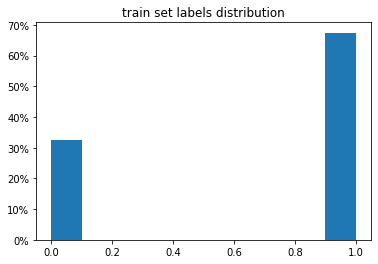

In [3]:
# plot the distribution of positive and negative reviews in the train set

data = review_train['likes']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("train set labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

In [23]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants.head()

business_id                         name  \
0  QXAEGFB4oINsVuTFxEYKFQ   Emerald Chinese Restaurant   
1  gnKjwL_1w79qoiV3IC_xQQ  Musashi Japanese Restaurant   
2  1Dfx3zM-rW4n-31KeC8sJg                    Taco Bell   
3  fweCYi8FmbJXHCqLnwuk8w                Marco's Pizza   
4  PZ-LZzSlhSe9utkQYU8pFg   Carluccio's Tivoli Gardens   

                        address   cuisine postal_code   latitude   longitude  \
0          30 Eglinton Avenue W   Chinese     L5R 3E7  43.605499  -79.652289   
1     10110 Johnston Rd, Ste 15  Japanese       28210  35.092564  -80.859132   
2       2450 E Indian School Rd   Mexican       85016  33.495194 -112.028588   
3               5981 Andrews Rd   Italian       44060  41.708520  -81.359556   
4  1775 E Tropicana Ave, Ste 29   Italian       89119  36.100016 -115.128529   

   review_count  stars OutdoorSeating BusinessAcceptsCreditCards  \
0           128    2.5          False                        NaN   
1           170    4.0          False                       True   
2            18    3.0          False                       True   
3            16    4.0          False                       True   
4            40    4.0          False                       True   

  RestaurantsDelivery RestaurantsReservations WiFi    Alcohol  \
0               False                    True   No   Full_Bar   
1               False                    True   No  Beer&Wine   
2               False                   False   No         No   
3                True                   False  NaN         No   
4               False                    True   No   Full_Bar   

                                          categories                city  \
0  Specialty Food, Restaurants, Dim Sum, Imported...         Mississauga   
1                  Sushi Bars, Restaurants, Japanese           Charlotte   
2  Restaurants, Breakfast & Brunch, Mexican, Taco...             Phoenix   
3         Italian, Restaurants, Pizza, Chicken Wings  Mentor-on-the-Lake   
4                               Restaurants, Italian           Las Vegas   

  Monday_Open Tuesday_Open Wednesday_Open Thursday_Open Friday_Open  \
0    09:00:00     09:00:00       09:00:00      09:00:00    09:00:00   
1    17:30:00          NaT       17:30:00      17:30:00    17:30:00   
2    07:00:00     07:00:00       07:00:00      07:00:00    07:00:00   
3    10:00:00     10:00:00       10:00:00      10:00:00    10:00:00   
4         NaT          NaT            NaT           NaT         NaT   

  Saturday_Open Sunday_Open Monday_Close Tuesday_Close Wednesday_Close  \
0      09:00:00    09:00:00     00:00:00      00:00:00        00:00:00   
1      17:30:00    17:30:00     21:30:00           NaT        21:30:00   
2      07:00:00    07:00:00     00:00:00      00:00:00        00:00:00   
3      10:00:00    10:00:00     00:00:00      00:00:00        00:00:00   
4           NaT         NaT          NaT           NaT             NaT   

  Thursday_Close Friday_Close Saturday_Close Sunday_Close  average_stars  \
0       00:00:00     01:00:00       01:00:00     00:00:00       2.726496   
1       21:30:00     22:00:00       22:00:00     21:00:00       4.063291   
2       01:00:00     01:00:00       01:00:00     00:00:00       3.125000   
3       00:00:00     01:00:00       01:00:00     00:00:00       4.230769   
4            NaT          NaT            NaT          NaT       4.097561   

   num_reviews  average_stars_bin  num_reviews_bin  average_stars_real  \
0        117.0           2.718750             96.0            2.730197   
1        158.0           4.094203            138.0            4.067541   
2         16.0           2.769231             13.0            2.847327   
3         13.0           4.166667             12.0            4.142021   
4         41.0           4.212121             33.0            4.167159   

   num_reviews_real  
0         95.873087  
1        139.112078  
2         12.604125  
3         10.965903  
4         33.655622

In [24]:
review_rest_train = review_train.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix = '_review', rsuffix = '_restaurant')
review_rest_train.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful  funny  cool                date  bin_truth_score  \
0             5       0      0     0 2018-01-11 19:55:31                1   
1             5       0      0     0 2018-02-25 17:47:12                1   
2             1       0      0     0 2018-05-06 04:22:48                1   
3             2       0      0     0 2018-04-22 17:42:09                1   
4             3       2      0     0 2018-05-21 05:09:07                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302              NaN                  NaN   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395              NaN                  NaN   
4          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3                   NaN         NaN             NaN              NaN      0   
4              2.954478    2.985799        2.973742         2.915633      0   

                            name                                     address  \
0               The Spicy Amigos                             821 4 Avenue SW   
1               The Spicy Amigos                             821 4 Avenue SW   
2               The Spicy Amigos                             821 4 Avenue SW   
3               The Spicy Amigos                             821 4 Avenue SW   
4  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
1  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
2  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
3  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
4  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                        NaN               False   
1           True                        NaN               False   
2           True                        NaN               False   
3           True                        NaN               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol            categories  \
0                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
1                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
2                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
3                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
4                    True   No  Beer&Wine  Chinese, Restaurants   

            city Monday_Open Tuesday_Open Wednesday_Open Thursday_Open  \
0        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
1        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
2        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
3        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
4  Richmond Hill    11:00:00     11:00:00       11:00:00      11:00:00   

  Friday_Open Saturday_Open S

In [25]:
print(len(review_train))
print(len(review_rest_train))

558386
558386


In [26]:
tips = _pd.read_pickle('../dataset/m2_n9/tips_train.pickle')
tips = tips.reset_index(drop = True)
tips.head()

user_id             business_id   tips_date  \
0  Fzz-0v1yHLaWuTV64b1miA  EZZjaiV8ik05NUepqdeP2A  2018-02-14   
1  AuSB69SSnaPNTwwbFk93MQ  bAHDSbpJE3kKJkW9OBgOyw  2018-03-23   
2  ouk36OGbx25nO23b10L5jw  THO77IL6DLob9Agt9QCjsw  2018-03-22   
3  gwmyGLz4eBm9QiBU_Ze2KQ  RJOFGZZf3ho04ku0fcFRdA  2018-03-29   
4  BzcdTNAe_jtXfnXFdFYQsA  _pBXtjN43eqMV0XZTz7nmw  2018-04-02   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [27]:
tips_agg = tips.groupby(['business_id', 'user_id'])['compliment_count'].agg(_np.sum)
tips_agg.head()

business_id             user_id               
--6MefnULPED_I942VcFNA  EisUuXVeVJN_FcFiE-tqwA    0
--7zmmkVg-IMGaXbuVd0SQ  9LlkZJ7NPsFSFMnIih8X1w    0
--9e1ONYQuAa-CB_Rrw7Tw  2J4PhasBxLtIv-kiS3_FiA    0
                        G2ZiNXL4rZdSxzaDSAAODQ    0
                        GFSZXppCJaO4oiqdgknWnA    0
Name: compliment_count, dtype: int64

In [28]:
review_tip_train = review_rest_train.join(tips_agg, on=['business_id', 'user_id'], lsuffix = '_review', rsuffix = '_tip')
review_tip_train.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful  funny  cool                date  bin_truth_score  \
0             5       0      0     0 2018-01-11 19:55:31                1   
1             5       0      0     0 2018-02-25 17:47:12                1   
2             1       0      0     0 2018-05-06 04:22:48                1   
3             2       0      0     0 2018-04-22 17:42:09                1   
4             3       2      0     0 2018-05-21 05:09:07                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302              NaN                  NaN   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395              NaN                  NaN   
4          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3                   NaN         NaN             NaN              NaN      0   
4              2.954478    2.985799        2.973742         2.915633      0   

                            name                                     address  \
0               The Spicy Amigos                             821 4 Avenue SW   
1               The Spicy Amigos                             821 4 Avenue SW   
2               The Spicy Amigos                             821 4 Avenue SW   
3               The Spicy Amigos                             821 4 Avenue SW   
4  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
1  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
2  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
3  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
4  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                        NaN               False   
1           True                        NaN               False   
2           True                        NaN               False   
3           True                        NaN               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol            categories  \
0                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
1                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
2                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
3                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
4                    True   No  Beer&Wine  Chinese, Restaurants   

            city Monday_Open Tuesday_Open Wednesday_Open Thursday_Open  \
0        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
1        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
2        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
3        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
4  Richmond Hill    11:00:00     11:00:00       11:00:00      11:00:00   

  Friday_Open Saturday_Open S

In [29]:
print(len(review_train))
print(len(review_tip_train))

558386
558386


In [30]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users = users.reset_index(drop = True)
users.head()

user_id user_name  average_stars yelping_since  review  \
0  l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
1  4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
2  bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
3  dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
4  MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

   years_of_elite  fans  useful  cool  funny  friends  num_reviews  \
0               3     5      84    25     17     2374          2.0   
1               0     4      48    16     22    27646         12.0   
2               0     0      28    10      8      358         13.0   
3               0     5      30    14      4    12598          1.0   
4               4    39    1114   665    279     5542          5.0   

   average_stars_bin  num_reviews_bin  average_stars_real  num_reviews_real  \
0           3.000000              2.0            3.017247          1.957334   
1           3.777778              9.0            3.626019          9.280533   
2           3.500000             12.0            3.326528         10.350275   
3                NaN              0.0            5.000000          0.329341   
4           4.400000              5.0            4.378799          4.720870   

   av_rat_chinese_cuisine  av_rat_japanese_cuisine  av_rat_mexican_cuisine  \
0                     NaN                      NaN                     NaN   
1                     NaN                      NaN                     NaN   
2                     3.5                      NaN                     2.0   
3                     NaN                      NaN                     NaN   
4                     NaN                      NaN                     NaN   

   av_rat_italian_cuisine  av_rat_others_cuisine  av_rat_american_cuisine  \
0                     4.0                    2.0                 4.000000   
1                     NaN                    4.0                 3.333333   
2                     NaN                    5.0                 3.000000   
3                     NaN                    NaN                      NaN   
4                     NaN                    NaN                 4.500000   

   av_rat_korean_cuisine  av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                    NaN                           NaN                  NaN   
1                    NaN                           4.0                  NaN   
2                    NaN                           3.0             3.666667   
3                    NaN                           NaN                  NaN   
4                    NaN                           5.0             3.000000   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         2.0                         3.5   
3                         5.0                         NaN   
4                         5.0                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         2.0   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         4.0                        2.0   
1                         NaN                        4.0   
2                         NaN                        5.0   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.000000                        NaN   
1                     3.666667     

In [31]:
train_set = review_tip_train.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_review', rsuffix = '_user')
del review_rest_train, users
train_set.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful_review  funny_review  cool_review                date  \
0             5              0             0            0 2018-01-11 19:55:31   
1             5              0             0            0 2018-02-25 17:47:12   
2             1              0             0            0 2018-05-06 04:22:48   
3             2              0             0            0 2018-04-22 17:42:09   
4             3              2             0            0 2018-05-21 05:09:07   

   bin_truth_score  real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0                1          0.622302              NaN                  NaN   
1                1          0.964784         4.000000             4.000000   
2                1          0.871544         3.000000             3.000000   
3                1          0.988395              NaN                  NaN   
4                1          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3                   NaN         NaN             NaN              NaN      0   
4              2.954478    2.985799        2.973742         2.915633      0   

                            name                                     address  \
0               The Spicy Amigos                             821 4 Avenue SW   
1               The Spicy Amigos                             821 4 Avenue SW   
2               The Spicy Amigos                             821 4 Avenue SW   
3               The Spicy Amigos                             821 4 Avenue SW   
4  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
1  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
2  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
3  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
4  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                        NaN               False   
1           True                        NaN               False   
2           True                        NaN               False   
3           True                        NaN               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol            categories  \
0                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
1                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
2                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
3                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
4                    True   No  Beer&Wine  Chinese, Restaurants   

            city Monday_Open Tuesday_Open Wednesday_Open Thursday_Open  \
0        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
1        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
2        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
3        Calgary    11:00:00     11:00:00       11:0

In [32]:
print(len(review_train))
print(len(train_set))

558386
558386


In [33]:
train_set.to_pickle('../dataset/m2_n9/model_train_set.pickle')
_del_all()

#### 5.2 Test set

In [4]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test.pickle')
review_test = review_test.assign(likes = _np.nan)
review_test['likes'] = _np.where(review_test['stars'].isin([4, 5]), 1, 0)
review_test.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars  useful  funny  cool                date  bin_truth_score  \
0      4       0      0     0 2018-10-21 18:45:39                1   
1      5       0      0     0 2018-09-21 01:07:38               -1   
2      5       0      0     0 2018-09-09 03:20:03                1   
3      1       0      0     0 2018-10-04 01:37:05                1   
4      5       0      0     0 2018-11-06 19:48:01                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555              NaN                  NaN   
1          0.553523              1.8             2.000000   
2          0.990602              4.3             4.333333   
3          0.968214              NaN                  NaN   
4          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  
0                   NaN         NaN             NaN              NaN      1  
1              1.799679    1.838975        2.007105         1.777964      1  
2              4.299574    4.349620        4.302949         4.288981      1  
3                   NaN         NaN             NaN              NaN      0  
4                   NaN         NaN             NaN              NaN      1

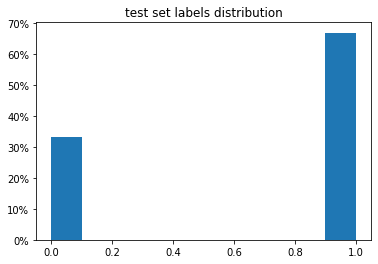

In [6]:
# plot the distribution of positive and negative reviews in the test set

data = review_test['likes']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("test set labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

In [35]:
print(len(review_test))

153993


In [36]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants.head()

business_id                         name  \
0  QXAEGFB4oINsVuTFxEYKFQ   Emerald Chinese Restaurant   
1  gnKjwL_1w79qoiV3IC_xQQ  Musashi Japanese Restaurant   
2  1Dfx3zM-rW4n-31KeC8sJg                    Taco Bell   
3  fweCYi8FmbJXHCqLnwuk8w                Marco's Pizza   
4  PZ-LZzSlhSe9utkQYU8pFg   Carluccio's Tivoli Gardens   

                        address   cuisine postal_code   latitude   longitude  \
0          30 Eglinton Avenue W   Chinese     L5R 3E7  43.605499  -79.652289   
1     10110 Johnston Rd, Ste 15  Japanese       28210  35.092564  -80.859132   
2       2450 E Indian School Rd   Mexican       85016  33.495194 -112.028588   
3               5981 Andrews Rd   Italian       44060  41.708520  -81.359556   
4  1775 E Tropicana Ave, Ste 29   Italian       89119  36.100016 -115.128529   

   review_count  stars OutdoorSeating BusinessAcceptsCreditCards  \
0           128    2.5          False                        NaN   
1           170    4.0          False                       True   
2            18    3.0          False                       True   
3            16    4.0          False                       True   
4            40    4.0          False                       True   

  RestaurantsDelivery RestaurantsReservations WiFi    Alcohol  \
0               False                    True   No   Full_Bar   
1               False                    True   No  Beer&Wine   
2               False                   False   No         No   
3                True                   False  NaN         No   
4               False                    True   No   Full_Bar   

                                          categories                city  \
0  Specialty Food, Restaurants, Dim Sum, Imported...         Mississauga   
1                  Sushi Bars, Restaurants, Japanese           Charlotte   
2  Restaurants, Breakfast & Brunch, Mexican, Taco...             Phoenix   
3         Italian, Restaurants, Pizza, Chicken Wings  Mentor-on-the-Lake   
4                               Restaurants, Italian           Las Vegas   

  Monday_Open Tuesday_Open Wednesday_Open Thursday_Open Friday_Open  \
0    09:00:00     09:00:00       09:00:00      09:00:00    09:00:00   
1    17:30:00          NaT       17:30:00      17:30:00    17:30:00   
2    07:00:00     07:00:00       07:00:00      07:00:00    07:00:00   
3    10:00:00     10:00:00       10:00:00      10:00:00    10:00:00   
4         NaT          NaT            NaT           NaT         NaT   

  Saturday_Open Sunday_Open Monday_Close Tuesday_Close Wednesday_Close  \
0      09:00:00    09:00:00     00:00:00      00:00:00        00:00:00   
1      17:30:00    17:30:00     21:30:00           NaT        21:30:00   
2      07:00:00    07:00:00     00:00:00      00:00:00        00:00:00   
3      10:00:00    10:00:00     00:00:00      00:00:00        00:00:00   
4           NaT         NaT          NaT           NaT             NaT   

  Thursday_Close Friday_Close Saturday_Close Sunday_Close  average_stars  \
0       00:00:00     01:00:00       01:00:00     00:00:00       2.726496   
1       21:30:00     22:00:00       22:00:00     21:00:00       4.063291   
2       01:00:00     01:00:00       01:00:00     00:00:00       3.125000   
3       00:00:00     01:00:00       01:00:00     00:00:00       4.230769   
4            NaT          NaT            NaT          NaT       4.097561   

   num_reviews  average_stars_bin  num_reviews_bin  average_stars_real  \
0        117.0           2.718750             96.0            2.730197   
1        158.0           4.094203            138.0            4.067541   
2         16.0           2.769231             13.0            2.847327   
3         13.0           4.166667             12.0            4.142021   
4         41.0           4.212121             33.0            4.167159   

   num_reviews_real  
0         95.873087  
1        139.112078  
2         12.604125  
3         10.965903  
4         33.655622

In [37]:
review_rest_test = review_test.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix = '_review', rsuffix = '_restaurant')
del restaurants
review_rest_test.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful  funny  cool                date  bin_truth_score  \
0             4       0      0     0 2018-10-21 18:45:39                1   
1             5       0      0     0 2018-09-21 01:07:38               -1   
2             5       0      0     0 2018-09-09 03:20:03                1   
3             1       0      0     0 2018-10-04 01:37:05                1   
4             5       0      0     0 2018-11-06 19:48:01                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555              NaN                  NaN   
1          0.553523              1.8             2.000000   
2          0.990602              4.3             4.333333   
3          0.968214              NaN                  NaN   
4          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3                   NaN         NaN             NaN              NaN      0   
4                   NaN         NaN             NaN              NaN      1   

                            name                                     address  \
0  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
1  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
2  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
3  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
4           Delmonico Steakhouse                       3355 Las Vegas Blvd S   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
1  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
2  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
3  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
4   Others       89109  36.123183 -115.169190          1613               4.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0          False                       True               False   
1          False                       True               False   
2          False                       True               False   
3          False                       True               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol  \
0                    True   No  Beer&Wine   
1                    True   No  Beer&Wine   
2                    True   No  Beer&Wine   
3                    True   No  Beer&Wine   
4                    True   No   Full_Bar   

                                        categories           city Monday_Open  \
0                             Chinese, Restaurants  Richmond Hill    11:00:00   
1                             Chinese, Restaurants  Richmond Hill    11:00:00   
2                             Chinese, Restaurants  Richmond Hill    11:00:00   
3                             Chinese, Restaurants  Richmond Hill    11:00:00   
4  Cajun/Creole, Seafood, Steakhouses, Restaurants      Las Vegas    17:00:00   

  Tuesday_Open Wednesday_Open Thursday_Open Friday_Open Saturday_Open  \
0     11:00:00       11:00:00      11:00:00   

In [38]:
print(len(review_test))
print(len(review_rest_test))

153993
153993


In [39]:
tips = _pd.read_pickle('../dataset/m2_n9/tips_test.pickle')
tips = tips.reset_index(drop = True)
tips.head()

user_id             business_id   tips_date  \
0  Yr0B0aVb94i2oIm1gLXgfg  yGDiAVoQB8LX3OsJ4e2I0A  2018-10-05   
1  z6qIyc-_oIbgDWAembZ04w  wFO5HLn-GSfYCSPPcbyqoA  2018-10-12   
2  EyYVD9n7PlYYLTSEQ5t14w  yhDAzBBjFujZbHwBPfE2eQ  2018-10-15   
3  90fhUaWIY6ctVAX5jQ2GNQ  ZMJOURno1xJS7PG3ZhfeyQ  2018-10-20   
4  k7J0CjxFoxdSayhlDE-k7w  X3qrbOkhdCjm0NTBX7T80Q  2018-10-30   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [40]:
tips_agg = tips.groupby(['business_id', 'user_id'])['compliment_count'].agg(_np.sum)
tips_agg.head()

business_id             user_id               
--9e1ONYQuAa-CB_Rrw7Tw  4vj_0BQeXjCyNB7ESS5mGg    0
                        idlz5ohzqTX5NnOZrxzcsQ    0
                        x_Nu7oNHf4VHwqgV3qLpfg    0
-01XupAWZEXbdNbxNg5mEg  8bt-F30D_tW-ajPG-IpZSA    0
-0DET7VdEQOJVJ_v6klEug  G-6X-llgA_qAxGxocykHzQ    0
Name: compliment_count, dtype: int64

In [41]:
review_tip_test = review_rest_test.join(tips_agg, on=['business_id', 'user_id'], lsuffix = '_review', rsuffix = '_tip')
review_tip_test.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful  funny  cool                date  bin_truth_score  \
0             4       0      0     0 2018-10-21 18:45:39                1   
1             5       0      0     0 2018-09-21 01:07:38               -1   
2             5       0      0     0 2018-09-09 03:20:03                1   
3             1       0      0     0 2018-10-04 01:37:05                1   
4             5       0      0     0 2018-11-06 19:48:01                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555              NaN                  NaN   
1          0.553523              1.8             2.000000   
2          0.990602              4.3             4.333333   
3          0.968214              NaN                  NaN   
4          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3                   NaN         NaN             NaN              NaN      0   
4                   NaN         NaN             NaN              NaN      1   

                            name                                     address  \
0  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
1  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
2  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
3  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
4           Delmonico Steakhouse                       3355 Las Vegas Blvd S   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
1  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
2  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
3  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
4   Others       89109  36.123183 -115.169190          1613               4.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0          False                       True               False   
1          False                       True               False   
2          False                       True               False   
3          False                       True               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol  \
0                    True   No  Beer&Wine   
1                    True   No  Beer&Wine   
2                    True   No  Beer&Wine   
3                    True   No  Beer&Wine   
4                    True   No   Full_Bar   

                                        categories           city Monday_Open  \
0                             Chinese, Restaurants  Richmond Hill    11:00:00   
1                             Chinese, Restaurants  Richmond Hill    11:00:00   
2                             Chinese, Restaurants  Richmond Hill    11:00:00   
3                             Chinese, Restaurants  Richmond Hill    11:00:00   
4  Cajun/Creole, Seafood, Steakhouses, Restaurants      Las Vegas    17:00:00   

  Tuesday_Open Wednesday_Open Thursday_Open Friday_Open Saturday_Open  \
0     11:00:00       11:00:00      11:00:00   

In [42]:
print(len(review_test))
print(len(review_tip_test))

153993
153993


In [43]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users = users.reset_index(drop = True)
users.head()

user_id user_name  average_stars yelping_since  review  \
0  l6BmjZMeQD3rDxWUbiAiow    Rashmi       3.000000    2013-10-08      95   
1  4XChL029mKr5hydo79Ljxg     Jenna       3.500000    2013-02-21      33   
2  bc8C_eETBWL0olvFSJJd0w     David       3.384615    2013-10-04      16   
3  dD0gZpBctWGdWo9WlGuhlA    Angela       5.000000    2014-05-22      17   
4  MM4RJAeH6yuaN8oZDSt0RA     Nancy       4.400000    2013-10-23     361   

   years_of_elite  fans  useful  cool  funny  friends  num_reviews  \
0               3     5      84    25     17     2374          2.0   
1               0     4      48    16     22    27646         12.0   
2               0     0      28    10      8      358         13.0   
3               0     5      30    14      4    12598          1.0   
4               4    39    1114   665    279     5542          5.0   

   average_stars_bin  num_reviews_bin  average_stars_real  num_reviews_real  \
0           3.000000              2.0            3.017247          1.957334   
1           3.777778              9.0            3.626019          9.280533   
2           3.500000             12.0            3.326528         10.350275   
3                NaN              0.0            5.000000          0.329341   
4           4.400000              5.0            4.378799          4.720870   

   av_rat_chinese_cuisine  av_rat_japanese_cuisine  av_rat_mexican_cuisine  \
0                     NaN                      NaN                     NaN   
1                     NaN                      NaN                     NaN   
2                     3.5                      NaN                     2.0   
3                     NaN                      NaN                     NaN   
4                     NaN                      NaN                     NaN   

   av_rat_italian_cuisine  av_rat_others_cuisine  av_rat_american_cuisine  \
0                     4.0                    2.0                 4.000000   
1                     NaN                    4.0                 3.333333   
2                     NaN                    5.0                 3.000000   
3                     NaN                    NaN                      NaN   
4                     NaN                    NaN                 4.500000   

   av_rat_korean_cuisine  av_rat_mediterranean_cuisine  av_rat_thai_cuisine  \
0                    NaN                           NaN                  NaN   
1                    NaN                           4.0                  NaN   
2                    NaN                           3.0             3.666667   
3                    NaN                           NaN                  NaN   
4                    NaN                           5.0             3.000000   

   av_rat_asianfusion_cuisine  av_rat_chinese_cuisine_bin  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         2.0                         3.5   
3                         5.0                         NaN   
4                         5.0                         NaN   

   av_rat_japanese_cuisine_bin  av_rat_mexican_cuisine_bin  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         2.0   
3                          NaN                         NaN   
4                          NaN                         NaN   

   av_rat_italian_cuisine_bin  av_rat_others_cuisine_bin  \
0                         4.0                        2.0   
1                         NaN                        4.0   
2                         NaN                        5.0   
3                         NaN                        NaN   
4                         NaN                        NaN   

   av_rat_american_cuisine_bin  av_rat_korean_cuisine_bin  \
0                     4.000000                        NaN   
1                     3.666667     

In [44]:
test_set = review_tip_test.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_review', rsuffix = '_user')
del review_rest_test, users
test_set.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review                date  \
0             4              0             0            0 2018-10-21 18:45:39   
1             5              0             0            0 2018-09-21 01:07:38   
2             5              0             0            0 2018-09-09 03:20:03   
3             1              0             0            0 2018-10-04 01:37:05   
4             5              0             0            0 2018-11-06 19:48:01   

   bin_truth_score  real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0                1          0.997555              NaN                  NaN   
1               -1          0.553523              1.8             2.000000   
2                1          0.990602              4.3             4.333333   
3                1          0.968214              NaN                  NaN   
4                1          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3                   NaN         NaN             NaN              NaN      0   
4                   NaN         NaN             NaN              NaN      1   

                            name                                     address  \
0  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
1  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
2  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
3  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
4           Delmonico Steakhouse                       3355 Las Vegas Blvd S   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
1  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
2  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
3  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
4   Others       89109  36.123183 -115.169190          1613               4.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0          False                       True               False   
1          False                       True               False   
2          False                       True               False   
3          False                       True               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol  \
0                    True   No  Beer&Wine   
1                    True   No  Beer&Wine   
2                    True   No  Beer&Wine   
3                    True   No  Beer&Wine   
4                    True   No   Full_Bar   

                                        categories           city Monday_Open  \
0                             Chinese, Restaurants  Richmond Hill    11:00:00   
1                             Chinese, Restaurants  Richmond Hill    11:00:00   
2                             Chinese, Restaurants  Richmond Hill    11:00:00   
3                             Chinese, Restaurants  Richmond Hill    11:00:00   
4  Cajun/Creole, Seafood, Steakhouses, Restaurants      Las Vegas    17:00:

In [45]:
print(len(review_test))
print(len(test_set))

153993
153993


In [46]:
test_set.to_pickle('../dataset/m2_n9/model_test_set.pickle')
_del_all()

### 5.3 Prepare data for the models

We have to fill missing values in the dataset, and then convert non-numerical
features into numerical features, or drop them if they are not necessary for
our models, so that the remaining features are readable by our models.

We execute two versions of this step, in order to obtain two different dataset: a complete one and a lighter one. The second one is used for grid search, that duplicates the input dataset to work in parallel and reduce the computation time to a reasonable amount.

#### 5.3.1 Complete version

We summarize what kind of data we have at the moment, in order to decide
what to do with each feature.

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set.pickle')
train_set.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful_review  funny_review  cool_review                date  \
0             5              0             0            0 2018-01-11 19:55:31   
1             5              0             0            0 2018-02-25 17:47:12   
2             1              0             0            0 2018-05-06 04:22:48   
3             2              0             0            0 2018-04-22 17:42:09   
4             3              2             0            0 2018-05-21 05:09:07   

   bin_truth_score  real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0                1          0.622302              NaN                  NaN   
1                1          0.964784         4.000000             4.000000   
2                1          0.871544         3.000000             3.000000   
3                1          0.988395              NaN                  NaN   
4                1          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3                   NaN         NaN             NaN              NaN      0   
4              2.954478    2.985799        2.973742         2.915633      0   

                            name                                     address  \
0               The Spicy Amigos                             821 4 Avenue SW   
1               The Spicy Amigos                             821 4 Avenue SW   
2               The Spicy Amigos                             821 4 Avenue SW   
3               The Spicy Amigos                             821 4 Avenue SW   
4  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
1  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
2  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
3  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
4  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                        NaN               False   
1           True                        NaN               False   
2           True                        NaN               False   
3           True                        NaN               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol            categories  \
0                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
1                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
2                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
3                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
4                    True   No  Beer&Wine  Chinese, Restaurants   

            city Monday_Open Tuesday_Open Wednesday_Open Thursday_Open  \
0        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
1        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
2        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
3        Calgary    11:00:00     11:00:00       11:0

In [4]:
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set.pickle')
test_set.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review                date  \
0             4              0             0            0 2018-10-21 18:45:39   
1             5              0             0            0 2018-09-21 01:07:38   
2             5              0             0            0 2018-09-09 03:20:03   
3             1              0             0            0 2018-10-04 01:37:05   
4             5              0             0            0 2018-11-06 19:48:01   

   bin_truth_score  real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0                1          0.997555              NaN                  NaN   
1               -1          0.553523              1.8             2.000000   
2                1          0.990602              4.3             4.333333   
3                1          0.968214              NaN                  NaN   
4                1          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3                   NaN         NaN             NaN              NaN      0   
4                   NaN         NaN             NaN              NaN      1   

                            name                                     address  \
0  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
1  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
2  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
3  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
4           Delmonico Steakhouse                       3355 Las Vegas Blvd S   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
1  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
2  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
3  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
4   Others       89109  36.123183 -115.169190          1613               4.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0          False                       True               False   
1          False                       True               False   
2          False                       True               False   
3          False                       True               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol  \
0                    True   No  Beer&Wine   
1                    True   No  Beer&Wine   
2                    True   No  Beer&Wine   
3                    True   No  Beer&Wine   
4                    True   No   Full_Bar   

                                        categories           city Monday_Open  \
0                             Chinese, Restaurants  Richmond Hill    11:00:00   
1                             Chinese, Restaurants  Richmond Hill    11:00:00   
2                             Chinese, Restaurants  Richmond Hill    11:00:00   
3                             Chinese, Restaurants  Richmond Hill    11:00:00   
4  Cajun/Creole, Seafood, Steakhouses, Restaurants      Las Vegas    17:00:

In [5]:
train_test_set = _pd.concat([train_set, test_set], sort=False)

In [6]:
print("train size:", train_set.shape)
print("test size:", test_set.shape)
print("train_test size:", train_test_set.shape)
print(train_set.shape[0] + test_set.shape[0] == train_test_set.shape[0])
_train_len = train_set.shape[0]

train size: (558386, 99)
test size: (153993, 99)
train_test size: (712379, 99)
True


In [7]:
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Data columns (total 99 columns):
review_id                            712379 non-null object
user_id                              712379 non-null object
business_id                          712379 non-null object
stars_review                         712379 non-null int64
useful_review                        712379 non-null int64
funny_review                         712379 non-null int64
cool_review                          712379 non-null int64
date                                 712379 non-null datetime64[ns]
bin_truth_score                      712379 non-null int64
real_truth_score                     712379 non-null float64
cuisine_av_hist                      269090 non-null float64
cuisine_av_hist_bin                  249642 non-null float64
cuisine_av_hist_real                 269090 non-null float64
coll_score                           269090 non-null float64
coll_score_bin                       2496

In [8]:
train_test_types = train_test_set.dtypes

In [9]:
for ind, dtype in train_test_types.iteritems():
    if not _np.issubdtype(dtype, _np.number):
        if "id" not in ind:
            uniq_vals = train_test_set[ind].unique()
            null_vals = train_test_set[ind].isnull().sum()
            print(ind + " - " + str(dtype) + "  - unique: " + str(len(uniq_vals)) + " - nulls: " + str(null_vals))
            print(uniq_vals[:10])
            print()

date - datetime64[ns]  - unique: 699960 - nulls: 0
['2018-01-11T19:55:31.000000000' '2018-02-25T17:47:12.000000000'
 '2018-05-06T04:22:48.000000000' '2018-04-22T17:42:09.000000000'
 '2018-05-21T05:09:07.000000000' '2018-07-08T19:29:51.000000000'
 '2018-08-14T21:59:34.000000000' '2018-08-19T04:01:19.000000000'
 '2018-02-19T03:29:10.000000000' '2018-06-24T18:41:08.000000000']

name - object  - unique: 26090 - nulls: 0
['The Spicy Amigos' "John's Chinese BBQ Restaurant" 'Delmonico Steakhouse'
 'Sunnyside Grill' 'The Bar At Bermuda & St. Rose' 'Mm Mm Pizza' 'Sushiya'
 'Happy Moose Bar and Grill' "Denny's" 'Pio Pio']

address - object  - unique: 35750 - nulls: 0
['821 4 Avenue SW' '328 Highway 7 E, Chalmers Gate 11, Unit 10'
 '3355 Las Vegas Blvd S' '1218 Saint Clair Avenue W' '11624 Bermuda Rd'
 '407 S Central Ave' '1950 Chemin Fer Ã\xa0 Cheval' '9436 State Rte 14'
 '6207 Wilson Mills Rd' '1408 E Blvd']

cuisine - object  - unique: 87 - nulls: 0
['Mexican' 'Chinese' 'Others' 'American' 'Ja

Drop useless features

In [10]:
train_test_set.drop(columns=['date', 'name', 'address', 'yelping_since', 'user_name', 'cuisine'], inplace=True)

Fill missing values

In [11]:
train_test_set['OutdoorSeating'] = train_test_set['OutdoorSeating'].fillna('None')
train_test_set['BusinessAcceptsCreditCards'] = train_test_set['BusinessAcceptsCreditCards'].fillna('None')
train_test_set['RestaurantsDelivery'] = train_test_set['RestaurantsDelivery'].fillna('None')
train_test_set['RestaurantsReservations'] = train_test_set['RestaurantsReservations'].fillna('None')
train_test_set['WiFi'] = train_test_set['WiFi'].fillna('None')
train_test_set['Alcohol'] = train_test_set['Alcohol'].fillna('None')

In [12]:
train_test_set['Monday_Open'] = train_test_set["Monday_Open"].astype(str)
train_test_set['Monday_Open'] = train_test_set['Monday_Open'].fillna(train_test_set['Monday_Open'].mode())
train_test_set['Tuesday_Open'] = train_test_set["Tuesday_Open"].astype(str)
train_test_set['Tuesday_Open'] = train_test_set['Tuesday_Open'].fillna(train_test_set['Tuesday_Open'].mode())
train_test_set['Wednesday_Open'] = train_test_set["Wednesday_Open"].astype(str)
train_test_set['Wednesday_Open'] = train_test_set['Wednesday_Open'].fillna(train_test_set['Wednesday_Open'].mode())
train_test_set['Thursday_Open'] = train_test_set["Thursday_Open"].astype(str)
train_test_set['Thursday_Open'] = train_test_set['Thursday_Open'].fillna(train_test_set['Thursday_Open'].mode())
train_test_set['Friday_Open'] = train_test_set["Friday_Open"].astype(str)
train_test_set['Friday_Open'] = train_test_set['Friday_Open'].fillna(train_test_set['Friday_Open'].mode())
train_test_set['Saturday_Open'] = train_test_set["Saturday_Open"].astype(str)
train_test_set['Saturday_Open'] = train_test_set['Saturday_Open'].fillna(train_test_set['Saturday_Open'].mode())
train_test_set['Sunday_Open'] = train_test_set["Sunday_Open"].astype(str)
train_test_set['Sunday_Open'] = train_test_set['Sunday_Open'].fillna(train_test_set['Sunday_Open'].mode())
train_test_set['Monday_Close'] = train_test_set["Monday_Close"].astype(str)
train_test_set['Monday_Close'] = train_test_set['Monday_Close'].fillna(train_test_set['Monday_Close'].mode())
train_test_set['Tuesday_Close'] = train_test_set["Tuesday_Close"].astype(str)
train_test_set['Tuesday_Close'] = train_test_set['Tuesday_Close'].fillna(train_test_set['Tuesday_Close'].mode())
train_test_set['Wednesday_Close'] = train_test_set["Wednesday_Close"].astype(str)
train_test_set['Wednesday_Close'] = train_test_set['Wednesday_Close'].fillna(train_test_set['Wednesday_Close'].mode())
train_test_set['Thursday_Close'] = train_test_set["Thursday_Close"].astype(str)
train_test_set['Thursday_Close'] = train_test_set['Thursday_Close'].fillna(train_test_set['Thursday_Close'].mode())
train_test_set['Friday_Close'] = train_test_set["Friday_Close"].astype(str)
train_test_set['Friday_Close'] = train_test_set['Friday_Close'].fillna(train_test_set['Friday_Close'].mode())
train_test_set['Saturday_Close'] = train_test_set["Saturday_Close"].astype(str)
train_test_set['Saturday_Close'] = train_test_set['Saturday_Close'].fillna(train_test_set['Saturday_Close'].mode())
train_test_set['Sunday_Close'] = train_test_set["Sunday_Close"].astype(str)
train_test_set['Sunday_Close'] = train_test_set['Sunday_Close'].fillna(train_test_set['Sunday_Close'].mode())

In [13]:
for ind, dtype in train_test_types.iteritems():
    if _np.issubdtype(dtype, _np.floating):
        train_test_set[ind] = train_test_set[ind].fillna(train_test_set[ind].mean())
    elif _np.issubdtype(dtype, _np.integer):
        train_test_set[ind] = train_test_set[ind].fillna(round(train_test_set[ind].mean()))

In [14]:
# check if any feature still has null values
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Data columns (total 93 columns):
review_id                            712379 non-null object
user_id                              712379 non-null object
business_id                          712379 non-null object
stars_review                         712379 non-null int64
useful_review                        712379 non-null int64
funny_review                         712379 non-null int64
cool_review                          712379 non-null int64
bin_truth_score                      712379 non-null int64
real_truth_score                     712379 non-null float64
cuisine_av_hist                      712379 non-null float64
cuisine_av_hist_bin                  712379 non-null float64
cuisine_av_hist_real                 712379 non-null float64
coll_score                           712379 non-null float64
coll_score_bin                       712379 non-null float64
coll_score_real                      712379 non-

Convert non-numerical features

In [15]:
train_test_set.shape

(712379, 93)

In [16]:
cat_cols = ['OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'RestaurantsReservations', 'WiFi',
            'Alcohol', 'city', 'Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open', 'Friday_Open',
            'Saturday_Open', 'Sunday_Open', 'Monday_Close', 'Tuesday_Close', 'Wednesday_Close', 'Thursday_Close',
            'Friday_Close', 'Saturday_Close', 'Sunday_Close']
train_test_set = _pd.get_dummies(train_test_set, columns=cat_cols, prefix=cat_cols)
train_test_set.shape

(712379, 1689)

In [17]:
oe = _OrdinalEncoder()

In [21]:
train_test_set['postal_code'] = oe.fit_transform(train_test_set['postal_code'].to_numpy().reshape(-1, 1))
train_test_set.shape

(712379, 1689)

In [22]:
categories = train_test_set['categories'].str.get_dummies(',')
f1 = lambda x: "categories_" + x
categories.rename(columns=f1, inplace=True)
train_test_set[categories.columns] = categories
train_test_set.drop(columns=['categories'], inplace=True)
train_test_set.shape

(712379, 2774)

The resulting dataset

In [23]:
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Columns: 2774 entries, review_id to categories_Yoga
dtypes: float64(54), int32(1), int64(1099), object(3), uint8(1617)
memory usage: 7.2+ GB


In [24]:
train_set = train_test_set[:_train_len]
test_set = train_test_set[_train_len:]

In [25]:
train_set.head(10)

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   
5  rPNt-m2pdt-OR_NMQnHjCQ  tKIihU81IA3NjpsADuR-Tg  --6MefnULPED_I942VcFNA   
6  Kg582pH05mZO_E6WS8PrKA  XNOs3Wz1Q_zdRgm1Hy05fg  --6MefnULPED_I942VcFNA   
7  gkW6_UqV9b2XI_5ae8rBCg  HSHuSCJvIvf_Tof62uZPEw  --6MefnULPED_I942VcFNA   
8  02voOwsYf0cEdKNzt5IkwA  yvpX68yurPsope6KhBZrYA  --9e1ONYQuAa-CB_Rrw7Tw   
9  M67I-I5ATaqtVLtKZTgygw  gvh8bvei5vwfoIYbNIvNDQ  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             5              0             0            0                1   
1             5              0             0            0                1   
2             1              0             0            0                1   
3             2              0             0            0                1   
4             3              2             0            0                1   
5             5              3             0            2                1   
6             1              2             2            1               -1   
7             2              2             1            0               -1   
8             5              0             0            0                1   
9             5              0             0            0               -1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302         3.726715             3.704594   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395         3.726715             3.704594   
4          0.927789         2.966667             2.923077   
5          0.907921         4.400000             4.400000   
6          0.184327         3.726715             3.704594   
7          0.687126         1.800000             1.692308   
8          0.935335         3.726715             3.704594   
9          0.242671         3.000000             3.000000   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3              3.719363    3.752465        3.722907         3.760889      0   
4              2.954478    2.985799        2.973742         2.915633      0   
5              4.395327    4.376569        4.405801         4.313458      1   
6              3.719363    3.752465        3.722907         3.760889      0   
7              1.768813    1.816353        1.733574         1.724494      0   
8              3.719363    3.752465        3.722907         3.760889      1   
9              3.040677    3.007972        3.009842         3.062459      1   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       7778.0  51.049673 -114.079977            24               4.0   
1       7778.0  51.049673 -114.079977            24               4.0   
2       7778.0  51.049673 -114.079977            24               4.0   
3       7778.0  51.049673 -114.079977            24               4.0   
4       3267.0  43.841694  -79.399755            44               3.0   
5       3267.0  43.841694  -79.399755            44               3.0   
6       3267.0  43.841694  -79.399755            44               3.0   
7       3267.0  43.841694  -79.399755            44               3.0   
8        530.0  36.123183 -115.169190          1613               4.0   
9        530.0  36.123183 -115.169190

In [26]:
train_set.shape

(558386, 2774)

In [27]:
train_set.to_pickle('../dataset/m2_n9/model_train_set_2.pickle')

In [28]:
test_set.head(10)

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   
5  NYG9z-whhsV99RbDR4KPWQ  3l-Rmqcw_Cm1mTxlqEmLEQ  --9e1ONYQuAa-CB_Rrw7Tw   
6  14tBa-RMPWBP93y6KcOyQQ  2vjNw6qpyvXAqRhSPzmHtQ  --9e1ONYQuAa-CB_Rrw7Tw   
7  A-n5xtGMR5Frz2KPJTfRzw  WiY9q-Jz42huWzq90fgAWA  --9e1ONYQuAa-CB_Rrw7Tw   
8  DqmGICsMu16YttevGUZCjg  q9q9nVaTYz7tScwZLHNO3A  --9e1ONYQuAa-CB_Rrw7Tw   
9  pSHJpti6SfYIK3XhHzvrXg  q_sv4HEU4XM88x9z6WG-Tw  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             4              0             0            0                1   
1             5              0             0            0               -1   
2             5              0             0            0                1   
3             1              0             0            0                1   
4             5              0             0            0                1   
5             5              1             0            5                1   
6             2              1             0            0                1   
7             2              0             0            0               -1   
8             5              0             1            0                1   
9             2              0             0            0               -1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555         3.726715             3.704594   
1          0.553523         1.800000             2.000000   
2          0.990602         4.300000             4.333333   
3          0.968214         3.726715             3.704594   
4          0.995667         3.726715             3.704594   
5          0.123990         3.726715             3.704594   
6          0.530155         3.000000             3.704594   
7          0.474595         3.726715             3.704594   
8          0.900049         3.726715             3.704594   
9          0.487348         4.000000             4.000000   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3              3.719363    3.752465        3.722907         3.760889      0   
4              3.719363    3.752465        3.722907         3.760889      1   
5              3.719363    3.752465        3.722907         3.760889      1   
6              3.000000    2.995295        3.722907         3.009147      0   
7              3.719363    3.752465        3.722907         3.760889      0   
8              3.719363    3.752465        3.722907         3.760889      1   
9              4.000000    4.001269        4.001652         4.015008      0   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       3267.0  43.841694  -79.399755            44               3.0   
1       3267.0  43.841694  -79.399755            44               3.0   
2       3267.0  43.841694  -79.399755            44               3.0   
3       3267.0  43.841694  -79.399755            44               3.0   
4        530.0  36.123183 -115.169190          1613               4.0   
5        530.0  36.123183 -115.169190          1613               4.0   
6        530.0  36.123183 -115.169190          1613               4.0   
7        530.0  36.123183 -115.169190          1613               4.0   
8        530.0  36.123183 -115.169190          1613               4.0   
9        530.0  36.123183 -115.169190

In [29]:
test_set.shape

(153993, 2774)

In [30]:
test_set.to_pickle('../dataset/m2_n9/model_test_set_2.pickle')

In [31]:
_del_all()

#### 5.3.2 Dimensionality reduction version

We summarize what kind of data we have at the moment, in order to decide
what to do with each feature.

In [47]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set.pickle')
train_set.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful_review  funny_review  cool_review                date  \
0             5              0             0            0 2018-01-11 19:55:31   
1             5              0             0            0 2018-02-25 17:47:12   
2             1              0             0            0 2018-05-06 04:22:48   
3             2              0             0            0 2018-04-22 17:42:09   
4             3              2             0            0 2018-05-21 05:09:07   

   bin_truth_score  real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0                1          0.622302              NaN                  NaN   
1                1          0.964784         4.000000             4.000000   
2                1          0.871544         3.000000             3.000000   
3                1          0.988395              NaN                  NaN   
4                1          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3                   NaN         NaN             NaN              NaN      0   
4              2.954478    2.985799        2.973742         2.915633      0   

                            name                                     address  \
0               The Spicy Amigos                             821 4 Avenue SW   
1               The Spicy Amigos                             821 4 Avenue SW   
2               The Spicy Amigos                             821 4 Avenue SW   
3               The Spicy Amigos                             821 4 Avenue SW   
4  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
1  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
2  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
3  Mexican     T2P 0K5  51.049673 -114.079977            24               4.0   
4  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                        NaN               False   
1           True                        NaN               False   
2           True                        NaN               False   
3           True                        NaN               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol            categories  \
0                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
1                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
2                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
3                     NaN  NaN  Beer&Wine  Restaurants, Mexican   
4                    True   No  Beer&Wine  Chinese, Restaurants   

            city Monday_Open Tuesday_Open Wednesday_Open Thursday_Open  \
0        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
1        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
2        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
3        Calgary    11:00:00     11:00:00       11:0

In [48]:
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set.pickle')
test_set.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review                date  \
0             4              0             0            0 2018-10-21 18:45:39   
1             5              0             0            0 2018-09-21 01:07:38   
2             5              0             0            0 2018-09-09 03:20:03   
3             1              0             0            0 2018-10-04 01:37:05   
4             5              0             0            0 2018-11-06 19:48:01   

   bin_truth_score  real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0                1          0.997555              NaN                  NaN   
1               -1          0.553523              1.8             2.000000   
2                1          0.990602              4.3             4.333333   
3                1          0.968214              NaN                  NaN   
4                1          0.995667              NaN                  NaN   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0                   NaN         NaN             NaN              NaN      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3                   NaN         NaN             NaN              NaN      0   
4                   NaN         NaN             NaN              NaN      1   

                            name                                     address  \
0  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
1  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
2  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
3  John's Chinese BBQ Restaurant  328 Highway 7 E, Chalmers Gate 11, Unit 10   
4           Delmonico Steakhouse                       3355 Las Vegas Blvd S   

   cuisine postal_code   latitude   longitude  review_count  stars_restaurant  \
0  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
1  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
2  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
3  Chinese     L4B 3P7  43.841694  -79.399755            44               3.0   
4   Others       89109  36.123183 -115.169190          1613               4.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0          False                       True               False   
1          False                       True               False   
2          False                       True               False   
3          False                       True               False   
4          False                       True               False   

  RestaurantsReservations WiFi    Alcohol  \
0                    True   No  Beer&Wine   
1                    True   No  Beer&Wine   
2                    True   No  Beer&Wine   
3                    True   No  Beer&Wine   
4                    True   No   Full_Bar   

                                        categories           city Monday_Open  \
0                             Chinese, Restaurants  Richmond Hill    11:00:00   
1                             Chinese, Restaurants  Richmond Hill    11:00:00   
2                             Chinese, Restaurants  Richmond Hill    11:00:00   
3                             Chinese, Restaurants  Richmond Hill    11:00:00   
4  Cajun/Creole, Seafood, Steakhouses, Restaurants      Las Vegas    17:00:

In [49]:
train_test_set = _pd.concat([train_set, test_set], sort=False)

In [50]:
print("train size:", train_set.shape)
print("test size:", test_set.shape)
print("train_test size:", train_test_set.shape)
print(train_set.shape[0] + test_set.shape[0] == train_test_set.shape[0])
_train_len = train_set.shape[0]

train size: (558386, 99)
test size: (153993, 99)
train_test size: (712379, 99)
True


Drop useless features

In [54]:
train_test_set.drop(columns=['date', 'name', 'address', 'yelping_since', 'user_name', 'cuisine'], inplace=True)

Fill missing values

In [55]:
train_test_set['OutdoorSeating'] = train_test_set['OutdoorSeating'].fillna('None')
train_test_set['BusinessAcceptsCreditCards'] = train_test_set['BusinessAcceptsCreditCards'].fillna('None')
train_test_set['RestaurantsDelivery'] = train_test_set['RestaurantsDelivery'].fillna('None')
train_test_set['RestaurantsReservations'] = train_test_set['RestaurantsReservations'].fillna('None')
train_test_set['WiFi'] = train_test_set['WiFi'].fillna('None')
train_test_set['Alcohol'] = train_test_set['Alcohol'].fillna('None')

In [56]:
train_test_set['Monday_Open'] = train_test_set["Monday_Open"].astype(str)
train_test_set['Monday_Open'] = train_test_set['Monday_Open'].fillna(train_test_set['Monday_Open'].mode())
train_test_set['Tuesday_Open'] = train_test_set["Tuesday_Open"].astype(str)
train_test_set['Tuesday_Open'] = train_test_set['Tuesday_Open'].fillna(train_test_set['Tuesday_Open'].mode())
train_test_set['Wednesday_Open'] = train_test_set["Wednesday_Open"].astype(str)
train_test_set['Wednesday_Open'] = train_test_set['Wednesday_Open'].fillna(train_test_set['Wednesday_Open'].mode())
train_test_set['Thursday_Open'] = train_test_set["Thursday_Open"].astype(str)
train_test_set['Thursday_Open'] = train_test_set['Thursday_Open'].fillna(train_test_set['Thursday_Open'].mode())
train_test_set['Friday_Open'] = train_test_set["Friday_Open"].astype(str)
train_test_set['Friday_Open'] = train_test_set['Friday_Open'].fillna(train_test_set['Friday_Open'].mode())
train_test_set['Saturday_Open'] = train_test_set["Saturday_Open"].astype(str)
train_test_set['Saturday_Open'] = train_test_set['Saturday_Open'].fillna(train_test_set['Saturday_Open'].mode())
train_test_set['Sunday_Open'] = train_test_set["Sunday_Open"].astype(str)
train_test_set['Sunday_Open'] = train_test_set['Sunday_Open'].fillna(train_test_set['Sunday_Open'].mode())
train_test_set['Monday_Close'] = train_test_set["Monday_Close"].astype(str)
train_test_set['Monday_Close'] = train_test_set['Monday_Close'].fillna(train_test_set['Monday_Close'].mode())
train_test_set['Tuesday_Close'] = train_test_set["Tuesday_Close"].astype(str)
train_test_set['Tuesday_Close'] = train_test_set['Tuesday_Close'].fillna(train_test_set['Tuesday_Close'].mode())
train_test_set['Wednesday_Close'] = train_test_set["Wednesday_Close"].astype(str)
train_test_set['Wednesday_Close'] = train_test_set['Wednesday_Close'].fillna(train_test_set['Wednesday_Close'].mode())
train_test_set['Thursday_Close'] = train_test_set["Thursday_Close"].astype(str)
train_test_set['Thursday_Close'] = train_test_set['Thursday_Close'].fillna(train_test_set['Thursday_Close'].mode())
train_test_set['Friday_Close'] = train_test_set["Friday_Close"].astype(str)
train_test_set['Friday_Close'] = train_test_set['Friday_Close'].fillna(train_test_set['Friday_Close'].mode())
train_test_set['Saturday_Close'] = train_test_set["Saturday_Close"].astype(str)
train_test_set['Saturday_Close'] = train_test_set['Saturday_Close'].fillna(train_test_set['Saturday_Close'].mode())
train_test_set['Sunday_Close'] = train_test_set["Sunday_Close"].astype(str)
train_test_set['Sunday_Close'] = train_test_set['Sunday_Close'].fillna(train_test_set['Sunday_Close'].mode())

In [57]:
for ind, dtype in train_test_types.iteritems():
    if _np.issubdtype(dtype, _np.floating):
        train_test_set[ind] = train_test_set[ind].fillna(train_test_set[ind].mean())
    elif _np.issubdtype(dtype, _np.integer):
        train_test_set[ind] = train_test_set[ind].fillna(round(train_test_set[ind].mean()))

In [58]:
# check any feature still has null values
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Data columns (total 93 columns):
review_id                            712379 non-null object
user_id                              712379 non-null object
business_id                          712379 non-null object
stars_review                         712379 non-null int64
useful_review                        712379 non-null int64
funny_review                         712379 non-null int64
cool_review                          712379 non-null int64
bin_truth_score                      712379 non-null int64
real_truth_score                     712379 non-null float64
cuisine_av_hist                      712379 non-null float64
cuisine_av_hist_bin                  712379 non-null float64
cuisine_av_hist_real                 712379 non-null float64
coll_score                           712379 non-null float64
coll_score_bin                       712379 non-null float64
coll_score_real                      712379 non-

Convert non-numerical features

We print and plot the distribution of the cities, to see the long tail and decide how many of them to keep.

In [59]:
city_count = train_test_set['city'].value_counts()
print(city_count.to_string())
print(city_count.shape)

Las Vegas                           208437
Phoenix                              71126
Toronto                              57047
Charlotte                            40190
Scottsdale                           36579
Pittsburgh                           26891
Henderson                            21518
MontrÃ©al                            18531
Tempe                                18354
Mesa                                 17235
Chandler                             15441
Gilbert                              14055
Cleveland                            12873
Glendale                             10742
Madison                               9688
Markham                               8248
Calgary                               7958
Mississauga                           7192
Peoria                                6582
North Las Vegas                       4771
Surprise                              4117
Richmond Hill                         3886
Goodyear                              3020
Concord    

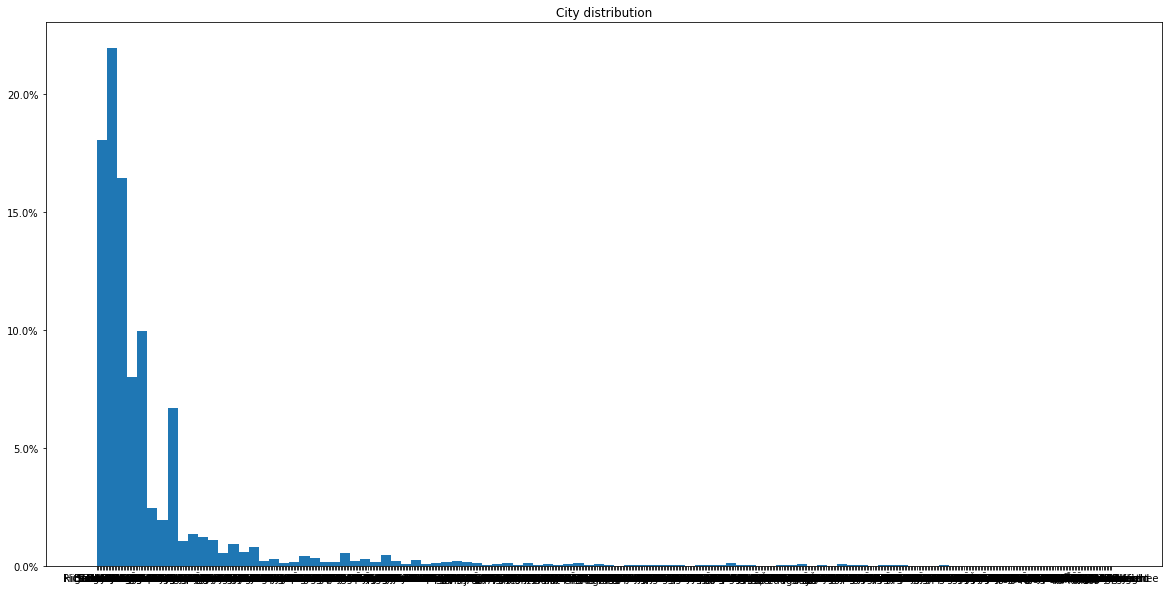

In [60]:
data = train_test_set.loc[train_test_set['city']!="Las Vegas", 'city']
weights = _np.ones(len(data)) / len(data)
_plt.figure(figsize=(20,10))
_plt.hist(data, weights=weights, bins=100)
_plt.title("City distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

In [61]:
main_cities = city_count.where(city_count >= 100).dropna()
print(main_cities.to_string())
print(main_cities.shape)
main_cities = '|'.join(list(main_cities.index))

Las Vegas               208437.0
Phoenix                  71126.0
Toronto                  57047.0
Charlotte                40190.0
Scottsdale               36579.0
Pittsburgh               26891.0
Henderson                21518.0
MontrÃ©al                18531.0
Tempe                    18354.0
Mesa                     17235.0
Chandler                 15441.0
Gilbert                  14055.0
Cleveland                12873.0
Glendale                 10742.0
Madison                   9688.0
Markham                   8248.0
Calgary                   7958.0
Mississauga               7192.0
Peoria                    6582.0
North Las Vegas           4771.0
Surprise                  4117.0
Richmond Hill             3886.0
Goodyear                  3020.0
Concord                   2905.0
Scarborough               2544.0
Champaign                 2513.0
Vaughan                   2496.0
Avondale                  2451.0
Huntersville              2046.0
Lakewood                  2008.0
Matthews  

In [62]:
train_test_set['city'] = train_test_set['city'].str.findall(main_cities)
train_test_set['city'] = train_test_set['city'].map(lambda x: 'Other' if x==[] else x[0])
train_test_set.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             5              0             0            0                1   
1             5              0             0            0                1   
2             1              0             0            0                1   
3             2              0             0            0                1   
4             3              2             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302         3.726715             3.704594   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395         3.726715             3.704594   
4          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3              3.719363    3.752465        3.722907         3.760889      0   
4              2.954478    2.985799        2.973742         2.915633      0   

  postal_code   latitude   longitude  review_count  stars_restaurant  \
0     T2P 0K5  51.049673 -114.079977            24               4.0   
1     T2P 0K5  51.049673 -114.079977            24               4.0   
2     T2P 0K5  51.049673 -114.079977            24               4.0   
3     T2P 0K5  51.049673 -114.079977            24               4.0   
4     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                       None               False   
1           True                       None               False   
2           True                       None               False   
3           True                       None               False   
4          False                       True               False   

  RestaurantsReservations  WiFi    Alcohol            categories  \
0                    None  None  Beer&Wine  Restaurants, Mexican   
1                    None  None  Beer&Wine  Restaurants, Mexican   
2                    None  None  Beer&Wine  Restaurants, Mexican   
3                    None  None  Beer&Wine  Restaurants, Mexican   
4                    True    No  Beer&Wine  Chinese, Restaurants   

            city Monday_Open Tuesday_Open Wednesday_Open Thursday_Open  \
0        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
1        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
2        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
3        Calgary    11:00:00     11:00:00       11:00:00      11:00:00   
4  Richmond Hill    11:00:00     11:00:00       11:00:00      11:00:00   

  Friday_Open Saturday_Open Sunday_Open Monday_Close Tuesday_Close  \
0    11:00:00      11:00:00         NaT     20:00:00      20:00:00   
1    11:00:00      11:00:00         NaT     20:00:00      20:00:00   
2    11:00:00      11:00:00         NaT     20:00:00      20:00:00   
3    11:00:00      11:00:00         NaT     20:00:00      20:00:00   
4    11:00:00      11:00:00    11:00:00     22:30:00      22:30:00   

  Wednesday_Close Thursday_Close Friday_Close Saturday_Close Sunday_Close  \
0        20:00:00       20:00:00     20:00:00       04

We print and plot the distribution of the categories, to see the long tail and decide how many of them to keep.

In [63]:
category_count = _pd.Series(', '.join(list(train_test_set['categories'])).split(', ')).value_counts()
print(category_count.to_string())
print(category_count.shape)

Restaurants                         712379
Food                                192841
Nightlife                           170259
Bars                                165959
American (Traditional)              123975
Breakfast & Brunch                  120310
American (New)                      117437
Sandwiches                           82264
Mexican                              73726
Burgers                              71598
Pizza                                67538
Italian                              62490
Seafood                              57228
Japanese                             53952
Salad                                49388
Fast Food                            46982
Event Planning & Services            45382
Coffee & Tea                         43592
Chinese                              42971
Asian Fusion                         42576
Sushi Bars                           42487
Cafes                                40002
Steakhouses                          37097
Desserts   

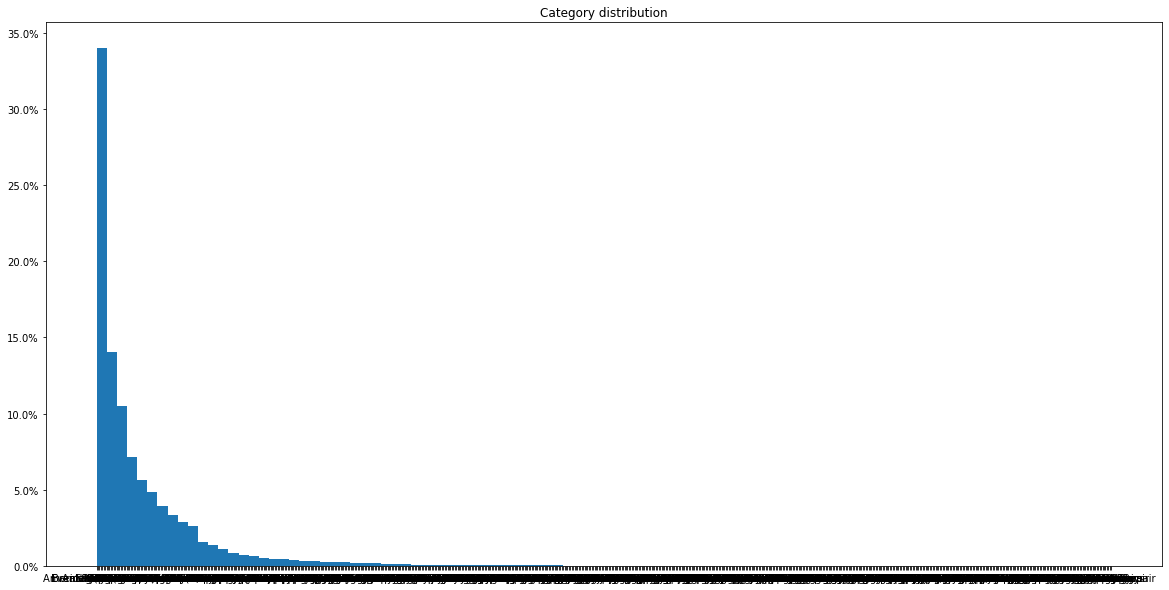

In [64]:
data = category_count.drop(labels=['Restaurants', 'Food']).index
vals = category_count.drop(labels=['Restaurants', 'Food']).values
weights = vals / vals.sum()
_plt.figure(figsize=(20,10))
_plt.hist(data, weights=weights, bins=100)
_plt.title("Category distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

In [65]:
main_categories = category_count.drop(labels=['Restaurants', 'Food']).where(category_count >= 100).dropna()
print(main_categories.to_string())
print(main_categories.shape)
main_categories = '|'.join([_re.escape(x) for x in main_categories.index])

Nightlife                           170259.0
Bars                                165959.0
American (Traditional)              123975.0
Breakfast & Brunch                  120310.0
American (New)                      117437.0
Sandwiches                           82264.0
Mexican                              73726.0
Burgers                              71598.0
Pizza                                67538.0
Italian                              62490.0
Seafood                              57228.0
Japanese                             53952.0
Salad                                49388.0
Fast Food                            46982.0
Event Planning & Services            45382.0
Coffee & Tea                         43592.0
Chinese                              42971.0
Asian Fusion                         42576.0
Sushi Bars                           42487.0
Cafes                                40002.0
Steakhouses                          37097.0
Desserts                             36523.0
Cocktail B

In [66]:
train_test_set['categories'] = train_test_set['categories'].str.findall(main_categories)
train_test_set['categories'] = train_test_set['categories'].map(lambda x: set(x))
train_test_set['categories'] = train_test_set['categories'].map(lambda x: ['Other'] if not bool(x) else list(x))
train_test_set['categories'] = train_test_set['categories'].map(', '.join) 
train_test_set.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             5              0             0            0                1   
1             5              0             0            0                1   
2             1              0             0            0                1   
3             2              0             0            0                1   
4             3              2             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302         3.726715             3.704594   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395         3.726715             3.704594   
4          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3              3.719363    3.752465        3.722907         3.760889      0   
4              2.954478    2.985799        2.973742         2.915633      0   

  postal_code   latitude   longitude  review_count  stars_restaurant  \
0     T2P 0K5  51.049673 -114.079977            24               4.0   
1     T2P 0K5  51.049673 -114.079977            24               4.0   
2     T2P 0K5  51.049673 -114.079977            24               4.0   
3     T2P 0K5  51.049673 -114.079977            24               4.0   
4     L4B 3P7  43.841694  -79.399755            44               3.0   

  OutdoorSeating BusinessAcceptsCreditCards RestaurantsDelivery  \
0           True                       None               False   
1           True                       None               False   
2           True                       None               False   
3           True                       None               False   
4          False                       True               False   

  RestaurantsReservations  WiFi    Alcohol categories           city  \
0                    None  None  Beer&Wine    Mexican        Calgary   
1                    None  None  Beer&Wine    Mexican        Calgary   
2                    None  None  Beer&Wine    Mexican        Calgary   
3                    None  None  Beer&Wine    Mexican        Calgary   
4                    True    No  Beer&Wine    Chinese  Richmond Hill   

  Monday_Open Tuesday_Open Wednesday_Open Thursday_Open Friday_Open  \
0    11:00:00     11:00:00       11:00:00      11:00:00    11:00:00   
1    11:00:00     11:00:00       11:00:00      11:00:00    11:00:00   
2    11:00:00     11:00:00       11:00:00      11:00:00    11:00:00   
3    11:00:00     11:00:00       11:00:00      11:00:00    11:00:00   
4    11:00:00     11:00:00       11:00:00      11:00:00    11:00:00   

  Saturday_Open Sunday_Open Monday_Close Tuesday_Close Wednesday_Close  \
0      11:00:00         NaT     20:00:00      20:00:00        20:00:00   
1      11:00:00         NaT     20:00:00      20:00:00        20:00:00   
2      11:00:00         NaT     20:00:00      20:00:00        20:00:00   
3      11:00:00         NaT     20:00:00      20:00:00        20:00:00   
4      11:00:00    11:00:00     22:30:00      22:30:00        22:30:00   

  Thursday_Close Friday_Close Saturday_Close Sunday_Close  \
0       20:00:00     20:00:00       04:0

Now we apply the actual conversion

In [67]:
train_test_set.shape

(712379, 93)

In [68]:
cat_cols = ['OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'RestaurantsReservations', 'WiFi',
        'Alcohol', 'city']
train_test_set = _pd.get_dummies(train_test_set, columns=cat_cols, prefix=cat_cols)
train_test_set.shape

(712379, 281)

In [69]:
categories = train_test_set['categories'].str.get_dummies(',')
f1 = lambda x: "categories_" + x
categories.rename(columns=f1, inplace=True)
train_test_set[categories.columns] = categories
train_test_set.drop(columns=['categories'], inplace=True)
train_test_set.shape

(712379, 787)

In [70]:
oe = _OrdinalEncoder()

In [71]:
ord_cols = ['Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open', 'Friday_Open',
            'Saturday_Open', 'Sunday_Open', 'Monday_Close', 'Tuesday_Close', 'Wednesday_Close',
            'Thursday_Close','Friday_Close', 'Saturday_Close', 'Sunday_Close', 'postal_code']

train_test_set[ord_cols] = oe.fit_transform(train_test_set[ord_cols].to_numpy())

The resulting dataset

In [72]:
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Columns: 787 entries, review_id to categories_Wraps
dtypes: float64(68), int32(1), int64(520), object(3), uint8(195)
memory usage: 3.3+ GB


In [73]:
train_set = train_test_set[:_train_len]
test_set = train_test_set[_train_len:]

In [74]:
train_set.head(10)

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   
5  rPNt-m2pdt-OR_NMQnHjCQ  tKIihU81IA3NjpsADuR-Tg  --6MefnULPED_I942VcFNA   
6  Kg582pH05mZO_E6WS8PrKA  XNOs3Wz1Q_zdRgm1Hy05fg  --6MefnULPED_I942VcFNA   
7  gkW6_UqV9b2XI_5ae8rBCg  HSHuSCJvIvf_Tof62uZPEw  --6MefnULPED_I942VcFNA   
8  02voOwsYf0cEdKNzt5IkwA  yvpX68yurPsope6KhBZrYA  --9e1ONYQuAa-CB_Rrw7Tw   
9  M67I-I5ATaqtVLtKZTgygw  gvh8bvei5vwfoIYbNIvNDQ  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             5              0             0            0                1   
1             5              0             0            0                1   
2             1              0             0            0                1   
3             2              0             0            0                1   
4             3              2             0            0                1   
5             5              3             0            2                1   
6             1              2             2            1               -1   
7             2              2             1            0               -1   
8             5              0             0            0                1   
9             5              0             0            0               -1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302         3.726715             3.704594   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395         3.726715             3.704594   
4          0.927789         2.966667             2.923077   
5          0.907921         4.400000             4.400000   
6          0.184327         3.726715             3.704594   
7          0.687126         1.800000             1.692308   
8          0.935335         3.726715             3.704594   
9          0.242671         3.000000             3.000000   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3              3.719363    3.752465        3.722907         3.760889      0   
4              2.954478    2.985799        2.973742         2.915633      0   
5              4.395327    4.376569        4.405801         4.313458      1   
6              3.719363    3.752465        3.722907         3.760889      0   
7              1.768813    1.816353        1.733574         1.724494      0   
8              3.719363    3.752465        3.722907         3.760889      1   
9              3.040677    3.007972        3.009842         3.062459      1   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       7778.0  51.049673 -114.079977            24               4.0   
1       7778.0  51.049673 -114.079977            24               4.0   
2       7778.0  51.049673 -114.079977            24               4.0   
3       7778.0  51.049673 -114.079977            24               4.0   
4       3267.0  43.841694  -79.399755            44               3.0   
5       3267.0  43.841694  -79.399755            44               3.0   
6       3267.0  43.841694  -79.399755            44               3.0   
7       3267.0  43.841694  -79.399755            44               3.0   
8        530.0  36.123183 -115.169190          1613               4.0   
9        530.0  36.123183 -115.169190

In [75]:
train_set.shape

(558386, 787)

In [76]:
train_set.to_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [77]:
test_set.head(10)

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   
5  NYG9z-whhsV99RbDR4KPWQ  3l-Rmqcw_Cm1mTxlqEmLEQ  --9e1ONYQuAa-CB_Rrw7Tw   
6  14tBa-RMPWBP93y6KcOyQQ  2vjNw6qpyvXAqRhSPzmHtQ  --9e1ONYQuAa-CB_Rrw7Tw   
7  A-n5xtGMR5Frz2KPJTfRzw  WiY9q-Jz42huWzq90fgAWA  --9e1ONYQuAa-CB_Rrw7Tw   
8  DqmGICsMu16YttevGUZCjg  q9q9nVaTYz7tScwZLHNO3A  --9e1ONYQuAa-CB_Rrw7Tw   
9  pSHJpti6SfYIK3XhHzvrXg  q_sv4HEU4XM88x9z6WG-Tw  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             4              0             0            0                1   
1             5              0             0            0               -1   
2             5              0             0            0                1   
3             1              0             0            0                1   
4             5              0             0            0                1   
5             5              1             0            5                1   
6             2              1             0            0                1   
7             2              0             0            0               -1   
8             5              0             1            0                1   
9             2              0             0            0               -1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555         3.726715             3.704594   
1          0.553523         1.800000             2.000000   
2          0.990602         4.300000             4.333333   
3          0.968214         3.726715             3.704594   
4          0.995667         3.726715             3.704594   
5          0.123990         3.726715             3.704594   
6          0.530155         3.000000             3.704594   
7          0.474595         3.726715             3.704594   
8          0.900049         3.726715             3.704594   
9          0.487348         4.000000             4.000000   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3              3.719363    3.752465        3.722907         3.760889      0   
4              3.719363    3.752465        3.722907         3.760889      1   
5              3.719363    3.752465        3.722907         3.760889      1   
6              3.000000    2.995295        3.722907         3.009147      0   
7              3.719363    3.752465        3.722907         3.760889      0   
8              3.719363    3.752465        3.722907         3.760889      1   
9              4.000000    4.001269        4.001652         4.015008      0   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       3267.0  43.841694  -79.399755            44               3.0   
1       3267.0  43.841694  -79.399755            44               3.0   
2       3267.0  43.841694  -79.399755            44               3.0   
3       3267.0  43.841694  -79.399755            44               3.0   
4        530.0  36.123183 -115.169190          1613               4.0   
5        530.0  36.123183 -115.169190          1613               4.0   
6        530.0  36.123183 -115.169190          1613               4.0   
7        530.0  36.123183 -115.169190          1613               4.0   
8        530.0  36.123183 -115.169190          1613               4.0   
9        530.0  36.123183 -115.169190

In [78]:
test_set.shape

(153993, 787)

In [79]:
test_set.to_pickle('../dataset/m2_n9/model_test_set_3.pickle')

In [80]:
_del_all()

## 6. Models
### 6.1 Linear SVM

(see the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html))

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             4              0             0            0               -1   
1             5              3             1            2                1   
2             1              0             0            0                1   
3             5              0             0            0                1   
4             2              0             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.595406         3.726715             3.704594   
1          0.993384         3.013889             3.014925   
2          0.519254         3.726715             3.704594   
3          0.983368         1.000000             1.000000   
4          0.866956         2.750000             2.666667   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363   -0.062602       -0.064146        -0.054028      1   
1              3.039444   -0.507850       -0.525615        -0.455618      1   
2              3.719363   -0.062602       -0.064146        -0.054028      0   
3              1.000000   -3.139748       -3.132280        -3.125614      1   
4              2.748879   -1.212807       -1.267752        -1.191953      0   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       2434.0  45.569980  -73.199634             4               5.0   
1       4057.0  43.579150  -79.683305            51               3.5   
2        493.0  33.608745 -112.359880           190               2.5   
3        530.0  36.109837 -115.174212          4286               4.0   
4        530.0  36.103061 -115.173450          2844               4.0   

   Monday_Open  Tuesday_Open  Wednesday_Open  Thursday_Open  Friday_Open  \
0         45.0          41.0            45.0           44.0         42.0   
1         15.0          14.0            17.0           16.0         14.0   
2         29.0          26.0            30.0           29.0         27.0   
3         29.0          26.0            30.0           29.0         27.0   
4         29.0          26.0            30.0           25.0         23.0   

   Saturday_Open  Sunday_Open  Monday_Close  Tuesday_Close  Wednesday_Close  \
0           40.0         45.0          59.0           61.0             60.0   
1           14.0         16.0          59.0           61.0             60.0   
2           25.0         27.0          59.0           61.0             60.0   
3           25.0         29.0          17.0           14.0             15.0   
4           25.0         29.0           0.0            9.0              9.0   

   Thursday_Close  Friday_Close  Saturday_Close  Sunday_Close  \
0            71.0          71.0            70.0          61.0   
1            67.0          36.0            35.0          61.0   
2            67.0          71.0            70.0          61.0   
3            15.0          21.0            21.0          17.0   
4            67.0           9.0             9.0           8.0   

   average_stars_review  num_reviews_review  average_stars_bin_review  \
0              5.000000                 3.0                  5.000000   
1              3.521739                46.0                  3.540541   
2              2.821229               179.0                  2.814286   
3              4.139748              3814.0                  4.132280   
4              3.962807              2608.0                  3.934419   

   num_reviews_bin_review  average_stars_

In [4]:
#sub_train_set = train_set[:round(train_set.shape[0]/3)]
sub_train_set = train_set
del train_set
sub_train_set.shape

(558386, 817)

In [5]:
# define classifier
svc_classifier = _LinearSVC(random_state=0, max_iter=50000)
svc_classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [6]:
# fine tune classifier

param_grid = {'C':[0.001,0.01,0.1,0.25,0.5,0.75,1,10,100,1000]}

grid = _GridSearchCV(estimator=svc_classifier, param_grid=param_grid, refit=True, verbose=2, cv=3, error_score=_np.nan, n_jobs=-1, pre_dispatch=6)
grid.fit(sub_train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), sub_train_set['likes'])
print("best params:", grid.best_params_, "- best score:", grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 1654.8min finished


best params: {'C': 0.001} - best score: 0.7436808945783024


C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [7]:
print("results:", grid.cv_results_)

results: {'mean_fit_time': array([19900.99567477, 19961.755548  , 19843.87850094, 19883.72761846,
       19875.85472822, 19892.886506  , 19819.18020558, 19831.93277272,
       19672.39210947, 19633.8438464 ]), 'std_fit_time': array([11.92322164, 24.47909948, 11.8002273 ,  2.51810785, 18.78170298,
       16.00907826,  5.86167115, 32.23873155,  4.59971461, 24.49313577]), 'mean_score_time': array([ 2.63927579,  5.25461706,  5.47336515, 10.05810801,  5.17248909,
        3.84837699,  2.75297205,  2.87099091,  2.33608754,  1.75242146]), 'std_score_time': array([0.28703641, 3.56587212, 1.62402285, 4.61803914, 2.93643879,
       1.57086447, 0.04191375, 0.27929337, 0.24098951, 0.2409035 ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 0.25}, {'C

In [8]:
del sub_train_set
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [5]:
best_model = grid.best_estimator_
best_model.set_params(verbose=5)
best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 5}

In [9]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [10]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

coef: [[-1.43167078e-01 -2.03906910e-01  3.42779107e-01 -1.04728908e-02
  -1.47427540e-01 -2.43472370e-02 -9.26808435e-03 -1.17709493e-02
   5.58234365e-02  1.83726109e-02 -7.91658762e-03  7.49998933e-05
  -3.29092790e-02  7.08513173e-03 -4.64203658e-05  6.24335229e-01
  -4.68312019e-05  1.13214836e-03  1.87475912e-04 -8.54227633e-04
  -4.47446153e-04 -7.61677236e-04  1.13923954e-03 -1.91138083e-04
  -1.40924026e-04  4.50836058e-04 -7.61383085e-05  5.97650915e-05
   2.98315416e-05 -2.74831993e-04 -6.26183842e-02  5.30331089e-05
   5.84330552e-03  2.03076934e-04 -3.48781537e-02 -2.18059846e-04
  -4.02326827e-02  4.95315660e-02  3.39012708e-04  1.71206420e-02
  -8.71542990e-04 -2.61593855e-04  1.30803827e-04  1.18480402e-04
  -4.80787054e-06 -5.59617233e-03  1.61222017e-02  1.03926925e-04
   4.67182627e-03  5.79030033e-03  3.74660499e-02  1.02789779e-02
   4.51314090e-02  1.57159326e-02  2.23464027e-02  5.36922329e-02
   2.34749232e-02  2.86587882e-02  1.87929188e-02  3.83956193e-04
  -7

In [3]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.head()

review_id                 user_id             business_id  \
0  ---j05qHS2X7FkXjjMKKtA  E6Aoz-3s4avfweIjziHjbA  cTbFJzHQzFSX-z3JF4abKQ   
1  --4GjusuUCMh24c_oh_cEg  YOOsYiXGEtGFX_wSeZNcww  JytR7WvKyytDQNwOHUzSEg   
2  --4RpVT5wHJ9AfnZkIC3tw  Bdw4E8jFVd6-CbhrNAJ_EA  -CfFjcCcGGDM9MVH_d42RQ   
3  --4vJzoC0m5h-yodXv-qCw  jm4a1GghQ4zLCN3lQGMQUQ  XMPBg6r_LqZhy9Cf-4ZJrA   
4  --B9JxEb5gY5gAgD2BRhDQ  x_6VdQU3CIdakwHod-dNzA  Fn_IxcCtZl1EoS81sq_s9w   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             5              1             0            1               -1   
1             4              1             0            0                1   
2             5              0             0            0               -1   
3             2              0             0            0                1   
4             3              1             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.229833         4.000000             4.285714   
1          0.987487         3.604167             3.607143   
2          0.524751         5.000000             3.704594   
3          0.979875         3.726715             3.704594   
4          0.662471         3.726715             3.704594   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.969038    0.674847        1.042857         0.678155      1   
1              3.610109   -0.099146       -0.096170        -0.093204      1   
2              5.000000    1.156489       -0.064146         1.182474      1   
3              3.719363   -0.062602       -0.064146        -0.054028      0   
4              3.719363   -0.062602       -0.064146        -0.054028      0   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       6145.0  43.670859  -79.393423           178               3.5   
1       6429.0  43.650017  -79.389188             6               4.0   
2        460.0  33.276651 -111.874092           369               4.0   
3        246.0  41.464592  -81.841481            23               2.5   
4        438.0  33.219015 -111.791210           142               3.5   

   Monday_Open  Tuesday_Open  Wednesday_Open  Thursday_Open  Friday_Open  \
0         58.0          55.0            59.0           61.0         57.0   
1         29.0          26.0            30.0           29.0         27.0   
2          0.0          26.0            30.0           29.0         27.0   
3         13.0          12.0            15.0           14.0         12.0   
4          0.0          37.0            41.0           40.0         27.0   

   Saturday_Open  Sunday_Open  Monday_Close  Tuesday_Close  Wednesday_Close  \
0           58.0         61.0          68.0           69.0             69.0   
1           29.0         61.0          55.0           57.0             56.0   
2           25.0         29.0           0.0           61.0             60.0   
3           12.0         17.0          55.0           57.0             56.0   
4           25.0         29.0           0.0           57.0             56.0   

   Thursday_Close  Friday_Close  Saturday_Close  Sunday_Close  \
0            76.0          76.0            75.0          70.0   
1            62.0          62.0            61.0          70.0   
2            67.0           0.0             0.0          61.0   
3            62.0          62.0            61.0          53.0   
4            62.0          67.0            66.0          54.0   

   average_stars_review  num_reviews_review  average_stars_bin_review  \
0              3.325153               163.0                  3.242857   
1              3.703313                 0.0                  3.703313   
2              3.843511               262.0                  3.738636   
3              2.400000                20.0                  2.235294   
4              3.567376               141.0                  3.575472   

   num_reviews_bin_review  average_stars_

In [5]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

predictions:
 [1 1 1 ... 1 1 1]


In [8]:
set(predic)

{0, 1}

In [9]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], predic)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.70      0.36      0.48     50930
           1       0.74      0.92      0.82    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.64      0.65    153993
weighted avg       0.73      0.74      0.71    153993

Accuracy for Support Vector Machine: 73.72737721844499


In [10]:
# Confusion matrix for SVC

print("Confusion Matrix for SVC: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for SVC before balance the data: 


array([[18347, 32583],
       [ 7875, 95188]], dtype=int64)

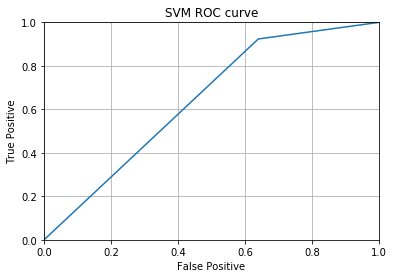

In [11]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("SVM ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [17]:
_jl.dump(best_model, "../models/best_SVM.joblib")

['../models/best_SVM.joblib']

In [ ]:
_del_all()

### 6.2 Random Forest Classifier

(see the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.head()

review_id                 user_id             business_id  \
0  ---HLAnHbuLi7vd5TL6uYg  zyp8SaRnZ94sWZpLrifS1Q  l6xZVTEtdZAvNpL1JhYGuw   
1  ---L4b6VR6HoB-q7cfMWIA  697iJkhX1mkVF9RNhn114Q  XiXu6WHbDoopKpeg7DfKdQ   
2  ---sPYSgArT4Sd5v1nDVMQ  iVSuN8PrtKVtLzhNiu23uA  OumGHdbdp7WgyYMhcAdjhw   
3  --0SzSMXVUoAXfackNoB4g  v9P7J6hWWtIblnylQ5UBfA  iCQpiavjjPzJ5_3gPD5Ebg   
4  --1JMhPk6K9fZo4FOp_yMw  2xZ1mHP14as5RJ1KOrVU4A  QJatAcxYgK1Zp9BRZMAx7g   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             4              0             0            0               -1   
1             5              3             1            2                1   
2             1              0             0            0                1   
3             5              0             0            0                1   
4             2              0             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.595406         3.726715             3.704594   
1          0.993384         3.013889             3.014925   
2          0.519254         3.726715             3.704594   
3          0.983368         1.000000             1.000000   
4          0.866956         2.750000             2.666667   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363   -0.062602       -0.064146        -0.054028      1   
1              3.039444   -0.507850       -0.525615        -0.455618      1   
2              3.719363   -0.062602       -0.064146        -0.054028      0   
3              1.000000   -3.139748       -3.132280        -3.125614      1   
4              2.748879   -1.212807       -1.267752        -1.191953      0   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       2434.0  45.569980  -73.199634             4               5.0   
1       4057.0  43.579150  -79.683305            51               3.5   
2        493.0  33.608745 -112.359880           190               2.5   
3        530.0  36.109837 -115.174212          4286               4.0   
4        530.0  36.103061 -115.173450          2844               4.0   

   Monday_Open  Tuesday_Open  Wednesday_Open  Thursday_Open  Friday_Open  \
0         45.0          41.0            45.0           44.0         42.0   
1         15.0          14.0            17.0           16.0         14.0   
2         29.0          26.0            30.0           29.0         27.0   
3         29.0          26.0            30.0           29.0         27.0   
4         29.0          26.0            30.0           25.0         23.0   

   Saturday_Open  Sunday_Open  Monday_Close  Tuesday_Close  Wednesday_Close  \
0           40.0         45.0          59.0           61.0             60.0   
1           14.0         16.0          59.0           61.0             60.0   
2           25.0         27.0          59.0           61.0             60.0   
3           25.0         29.0          17.0           14.0             15.0   
4           25.0         29.0           0.0            9.0              9.0   

   Thursday_Close  Friday_Close  Saturday_Close  Sunday_Close  \
0            71.0          71.0            70.0          61.0   
1            67.0          36.0            35.0          61.0   
2            67.0          71.0            70.0          61.0   
3            15.0          21.0            21.0          17.0   
4            67.0           9.0             9.0           8.0   

   average_stars_review  num_reviews_review  average_stars_bin_review  \
0              5.000000                 3.0                  5.000000   
1              3.521739                46.0                  3.540541   
2              2.821229               179.0                  2.814286   
3              4.139748              3814.0                  4.132280   
4              3.962807              2608.0                  3.934419   

   num_reviews_bin_review  average_stars_

In [4]:
sub_train_set = train_set[:round(train_set.shape[0]/2)]
del train_set
sub_train_set.shape

(279193, 817)

In [5]:
random_forest = _RandomForestClassifier(n_jobs = -1, random_state = 0)
random_forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [6]:
# fine tune classifier

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 30, 50],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 500, 1000],
    'criterion': ['gini', 'entropy']}
 
grid = _GridSearchCV(estimator=random_forest, param_grid=param_grid, refit=False, verbose=5, cv=3, error_score=_np.nan, n_jobs=-1, pre_dispatch=6)
grid.fit(sub_train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), sub_train_set['likes'])

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 134.9min
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed: 558.6min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed: 1123.2min
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed: 2490.3min
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed: 3490.7min
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed: 4913.4min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 5701.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, Fa

In [7]:
print("best params:\n", grid.best_params_)
print("best score:", grid.best_score_)

best params:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
best score: 0.7453481999906875


In [8]:
with open("../models/random_forest_params.txt", 'w') as f:
    f.write(str(grid.best_params_))

In [9]:
print("results:", grid.cv_results_)

results: {'mean_fit_time': array([ 252.87800407,  600.7321078 , 1147.74082383,  311.25228389,
        597.79628388, 1124.06511203,  307.2705942 ,  662.01461442,
       1102.80993398,  303.65359688,  676.63054156, 1121.13627799,
        290.6686426 ,  672.74625977, 1103.33752354,  299.24372005,
        666.57276177, 1089.51547178,  310.32110922,  677.31205535,
       1087.89945881,  302.18119884,  681.54606994, 1077.58835777,
        343.88937259,  647.70520091, 1116.92719674,  748.18958219,
       1670.8926479 , 3277.3076601 ,  726.21665557, 1612.23545631,
       3128.41236226,  706.48307268, 1692.42808255, 3044.78944604,
        710.94016171, 1687.92898154, 3029.70489526,  716.6063451 ,
       1661.93725832, 2975.88908982,  699.15533026, 1650.08494091,
       2936.43123945,  663.98700976, 1589.69072064, 2841.49037019,
        677.26351619, 1600.60654235, 2818.42968504,  689.23385302,
       1575.95244972, 2845.27126567,  854.03630026, 1924.91824579,
       3589.90236084,  806.29059982

In [10]:
del sub_train_set
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [11]:
params = grid.best_params_
params['n_jobs'] = -1
params['verbose'] = 5
best_model = _RandomForestClassifier(**params)
best_model.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 5,
 'warm_start': False}

In [19]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.0min


building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.6min



building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 10.3min


building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 16.2min


building tree 438 of 1000
building tree 439 of 1000
building tree 440 of 1000
building tree 441 of 1000
building tree 442 of 1000
building tree 443 of 1000
building tree 444 of 1000
building tree 445 of 1000
building tree 446 of 1000
building tree 447 of 1000
building tree 448 of 1000
building tree 449 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tree 455 of 1000
building tree 456 of 1000
building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 467 of 1000
building tree 468 of 1000
building tree 469 of 1000
building tree 470 of 1000
building tree 471 of 1000
building tree 472 of 1000
building tree 473 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 23.3min


building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 31.8min


building tree 870 of 1000
building tree 871 of 1000
building tree 872 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tree 875 of 1000
building tree 876 of 1000
building tree 877 of 1000
building tree 878 of 1000
building tree 879 of 1000
building tree 880 of 1000
building tree 881 of 1000
building tree 882 of 1000
building tree 883 of 1000
building tree 884 of 1000
building tree 885 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 888 of 1000
building tree 889 of 1000
building tree 890 of 1000
building tree 891 of 1000
building tree 892 of 1000
building tree 893 of 1000
building tree 894 of 1000
building tree 895 of 1000
building tree 896 of 1000
building tree 897 of 1000
building tree 898 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 902 of 1000
building tree 903 of 1000
building tree 904 of 1000
building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 36.7min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=5,
                       warm_start=False)

In [20]:
_jl.dump(best_model, "../models/best_Random_Forest_2.joblib")

['../models/best_Random_Forest_2.joblib']

In [21]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             4              0             0            0                1   
1             5              0             0            0               -1   
2             5              0             0            0                1   
3             1              0             0            0                1   
4             5              0             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555         3.726715             3.704594   
1          0.553523         1.800000             2.000000   
2          0.990602         4.300000             4.333333   
3          0.968214         3.726715             3.704594   
4          0.995667         3.726715             3.704594   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3              3.719363    3.752465        3.722907         3.760889      0   
4              3.719363    3.752465        3.722907         3.760889      1   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       3267.0  43.841694  -79.399755            44               3.0   
1       3267.0  43.841694  -79.399755            44               3.0   
2       3267.0  43.841694  -79.399755            44               3.0   
3       3267.0  43.841694  -79.399755            44               3.0   
4        530.0  36.123183 -115.169190          1613               4.0   

   Monday_Open  Tuesday_Open  Wednesday_Open  Thursday_Open  Friday_Open  \
0         29.0          26.0            30.0           29.0         27.0   
1         29.0          26.0            30.0           29.0         27.0   
2         29.0          26.0            30.0           29.0         27.0   
3         29.0          26.0            30.0           29.0         27.0   
4         47.0          42.0            46.0           45.0         43.0   

   Saturday_Open  Sunday_Open  Monday_Close  Tuesday_Close  Wednesday_Close  \
0           25.0         29.0          61.0           63.0             62.0   
1           25.0         29.0          61.0           63.0             62.0   
2           25.0         29.0          61.0           63.0             62.0   
3           25.0         29.0          61.0           63.0             62.0   
4           41.0         46.0          59.0           61.0             60.0   

   Thursday_Close  Friday_Close  Saturday_Close  Sunday_Close  \
0            69.0          69.0            68.0          63.0   
1            69.0          69.0            68.0          63.0   
2            69.0          69.0            68.0          63.0   
3            69.0          69.0            68.0          63.0   
4            67.0          69.0            68.0          61.0   

   average_stars_review  num_reviews_review  average_stars_bin_review  \
0              3.157895                38.0                  3.218750   
1              3.157895                38.0                  3.218750   
2              3.157895                38.0                  3.218750   
3              3.157895                38.0                  3.218750   
4              4.107048              1504.0                  4.088816   

   num_reviews_bin_review  average_stars_

In [22]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    4.8s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    8.9s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:   18.8s
[Parallel(n_jobs=12)]: Done 858 tasks      | elapsed:   25.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:   28.9s finished


predictions:
 [0 0 1 ... 0 1 0]


In [23]:
set(predic)

{0, 1}

In [24]:
# evaluate classifier

print("Report for Random Forest classifier:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Random Forest Classifier:", _accuracy_score(test_set['likes'], predic)*100)

Report for Random Forest classifier:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51     50930
           1       0.75      0.91      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.66      0.67    153993
weighted avg       0.73      0.74      0.72    153993

Accuracy for Random Forest Classifier: 74.16765697142078


In [25]:
# Confusion matrix for Random Forest

print("Confusion Matrix for Random Forest: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for Random Forest before balance the data: 


array([[20372, 30558],
       [ 9222, 93841]], dtype=int64)

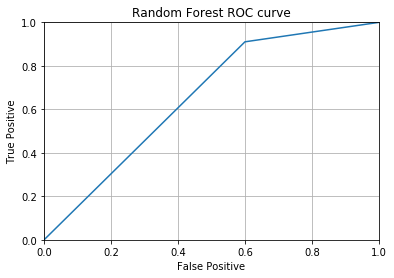

In [26]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Random Forest ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [ ]:
%reset

### 6.3 Neural Network

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.head()

review_id                 user_id             business_id  \
0  hhVr1uH7XaRlbIHI8dYvbA  FYhU1fKQ7n11WQ7gcFYOag  --1UhMGODdWsrMastO9DZw   
1  no4Eo4WloZRLwcYZP9gfhg  m-p-7WuB85UjsLDaxJXCXA  --1UhMGODdWsrMastO9DZw   
2  8QUwzeXeyJ3L15lKfhKLsQ  Bsy9F-59sl9OT_bvZNl3hA  --1UhMGODdWsrMastO9DZw   
3  BIecLw546kAlD7kmlk7vXA  sTVGcezME7gYBhIlYtcfpg  --1UhMGODdWsrMastO9DZw   
4  0nVZ9Cg1A1lVA8EFWbt5lg  EisUuXVeVJN_FcFiE-tqwA  --6MefnULPED_I942VcFNA   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             5              0             0            0                1   
1             5              0             0            0                1   
2             1              0             0            0                1   
3             2              0             0            0                1   
4             3              2             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.622302         3.726715             3.704594   
1          0.964784         4.000000             4.000000   
2          0.871544         3.000000             3.000000   
3          0.988395         3.726715             3.704594   
4          0.927789         2.966667             2.923077   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              4.000000    3.757630        3.808050         3.714375      1   
2              2.990709    2.926486        2.974252         2.874015      0   
3              3.719363    3.752465        3.722907         3.760889      0   
4              2.954478    2.985799        2.973742         2.915633      0   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       7778.0  51.049673 -114.079977            24               4.0   
1       7778.0  51.049673 -114.079977            24               4.0   
2       7778.0  51.049673 -114.079977            24               4.0   
3       7778.0  51.049673 -114.079977            24               4.0   
4       3267.0  43.841694  -79.399755            44               3.0   

   Monday_Open  Tuesday_Open  Wednesday_Open  Thursday_Open  Friday_Open  \
0         29.0          26.0            30.0           29.0         27.0   
1         29.0          26.0            30.0           29.0         27.0   
2         29.0          26.0            30.0           29.0         27.0   
3         29.0          26.0            30.0           29.0         27.0   
4         29.0          26.0            30.0           29.0         27.0   

   Saturday_Open  Sunday_Open  Monday_Close  Tuesday_Close  Wednesday_Close  \
0           25.0         61.0          51.0           52.0             51.0   
1           25.0         61.0          51.0           52.0             51.0   
2           25.0         61.0          51.0           52.0             51.0   
3           25.0         61.0          51.0           52.0             51.0   
4           25.0         29.0          61.0           63.0             62.0   

   Thursday_Close  Friday_Close  Saturday_Close  Sunday_Close  \
0            58.0          58.0            17.0          70.0   
1            58.0          58.0            17.0          70.0   
2            58.0          58.0            17.0          70.0   
3            58.0          58.0            17.0          70.0   
4            69.0          69.0            68.0          63.0   

   average_stars_review  num_reviews_review  average_stars_bin_review  \
0              4.227273                22.0                  4.214286   
1              4.227273                22.0                  4.214286   
2              4.227273                22.0                  4.214286   
3              4.227273                22.0                  4.214286   
4              3.157895                38.0                  3.218750   

   num_reviews_bin_review  average_stars_

Rule for calculating the number of hidden layers
(from [here](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)):

$N_h = \frac {N_s} {\alpha * (N_i + N_o)}$

- $N_h$ is the number of hidden neurons
- $N_i$ is the number of input neurons
- $N_o$ is the number of output neurons
- $N_s$ number of samples in training data set
- $\alpha$ an arbitrary scaling factor usually between 5 and 10

Neural Network summary:

- alpha = 6
- hidden layers = 3
- batch size = 100

In [7]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 6

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

119


In [8]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 206s 527us/step - loss: 0.6102 - acc: 0.6933 - val_loss: 0.5960 - val_acc: 0.7106
Epoch 2/100
390870/390870 [==============================] - 25s 64us/step - loss: 0.5606 - acc: 0.7197 - val_loss: 0.5684 - val_acc: 0.7193
Epoch 3/100
390870/390870 [==============================] - 25s 64us/step - loss: 0.5503 - acc: 0.7273 - val_loss: 0.5508 - val_acc: 0.7308
Epoch 4/100
390870/390870 [==============================] - 24s 63us/step - loss: 0.5454 - acc: 0.7317 - val_loss: 0.5547 - val_acc: 0.7287
Epoch 5/100
390870/390870 [==============================] - 25s 64us/step - loss: 0.5414 - acc: 0.7337 - val_loss: 0.5375 - val_acc: 0.7373
Epoch 6/100
390870/390870 [==============================] - 25s 63us/step - loss: 0.5393 - acc: 0.7350 - val_loss: 0.5453 - val_acc: 0.7272
Epoch 7/100
390870/390870 [==============================] - 24s 60us/step - loss: 0.5381 - acc: 0.7

In [10]:
# Save trained model
classifier.save("../models/trained_deep_neural_network.h5")

In [11]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 16s 29us/step
[0.516120845819726, 0.7530937380230908]


The neural network gives us the probability that the class is 1, we
[binarize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.binarize.html)
with threshold to 0.5 thus having the labels with probability up
to 0.5 at 0, the others at 1. We could use two nerones in output thus having
a probability vector expressing the probability that it is 1 and the
probability that it is 0, but only an equivalent approach would result.

In [12]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.head()

review_id                 user_id             business_id  \
0  -j8YU0f5cL_fbnzsi1zkpA  rEsBrt6U7i8O4rC81lV6NQ  --6MefnULPED_I942VcFNA   
1  1vEQsKjTfGCcNdQ2Hhuhew  yEP9vNFq3edLldNzhm6hgQ  --6MefnULPED_I942VcFNA   
2  P6ZgOVwyGlvis4m2Cra13g  uH8tTLb3Fz64GtEMWpZZcQ  --6MefnULPED_I942VcFNA   
3  ap-_EXUS49YhyukC23p2Gw  NQhvEYuYOa5psBxEoNvq2g  --6MefnULPED_I942VcFNA   
4  tKFDdiQ7rGMsdxgvIz2Sxg  zbrH2lnZgWicvwoXR0qcSg  --9e1ONYQuAa-CB_Rrw7Tw   

   stars_review  useful_review  funny_review  cool_review  bin_truth_score  \
0             4              0             0            0                1   
1             5              0             0            0               -1   
2             5              0             0            0                1   
3             1              0             0            0                1   
4             5              0             0            0                1   

   real_truth_score  cuisine_av_hist  cuisine_av_hist_bin  \
0          0.997555         3.726715             3.704594   
1          0.553523         1.800000             2.000000   
2          0.990602         4.300000             4.333333   
3          0.968214         3.726715             3.704594   
4          0.995667         3.726715             3.704594   

   cuisine_av_hist_real  coll_score  coll_score_bin  coll_score_real  likes  \
0              3.719363    3.752465        3.722907         3.760889      1   
1              1.799679    1.838975        2.007105         1.777964      1   
2              4.299574    4.349620        4.302949         4.288981      1   
3              3.719363    3.752465        3.722907         3.760889      0   
4              3.719363    3.752465        3.722907         3.760889      1   

   postal_code   latitude   longitude  review_count  stars_restaurant  \
0       3267.0  43.841694  -79.399755            44               3.0   
1       3267.0  43.841694  -79.399755            44               3.0   
2       3267.0  43.841694  -79.399755            44               3.0   
3       3267.0  43.841694  -79.399755            44               3.0   
4        530.0  36.123183 -115.169190          1613               4.0   

   Monday_Open  Tuesday_Open  Wednesday_Open  Thursday_Open  Friday_Open  \
0         29.0          26.0            30.0           29.0         27.0   
1         29.0          26.0            30.0           29.0         27.0   
2         29.0          26.0            30.0           29.0         27.0   
3         29.0          26.0            30.0           29.0         27.0   
4         47.0          42.0            46.0           45.0         43.0   

   Saturday_Open  Sunday_Open  Monday_Close  Tuesday_Close  Wednesday_Close  \
0           25.0         29.0          61.0           63.0             62.0   
1           25.0         29.0          61.0           63.0             62.0   
2           25.0         29.0          61.0           63.0             62.0   
3           25.0         29.0          61.0           63.0             62.0   
4           41.0         46.0          59.0           61.0             60.0   

   Thursday_Close  Friday_Close  Saturday_Close  Sunday_Close  \
0            69.0          69.0            68.0          63.0   
1            69.0          69.0            68.0          63.0   
2            69.0          69.0            68.0          63.0   
3            69.0          69.0            68.0          63.0   
4            67.0          69.0            68.0          61.0   

   average_stars_review  num_reviews_review  average_stars_bin_review  \
0              3.157895                38.0                  3.218750   
1              3.157895                38.0                  3.218750   
2              3.157895                38.0                  3.218750   
3              3.157895                38.0                  3.218750   
4              4.107048              1504.0                  4.088816   

   num_reviews_bin_review  average_stars_

In [13]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)

In [14]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51     50930
           1       0.75      0.91      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.66      0.67    153993
weighted avg       0.73      0.74      0.72    153993

Accuracy for Deep Learning approach: 74.20402226075211


In [15]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[20454 30476]
 [ 9248 93815]]


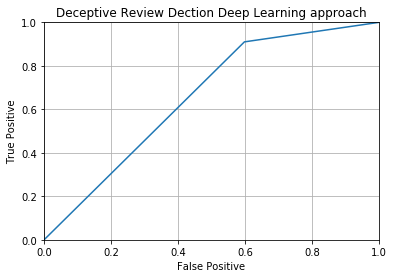

In [16]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

### NN 2

Neural Network summary:

- alpha = 7
- hidden layers = 5
- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [4]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

102


In [5]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 36s 93us/step - loss: 0.5886 - acc: 0.6996 - val_loss: 0.5660 - val_acc: 0.7186
Epoch 2/100
390870/390870 [==============================] - 28s 72us/step - loss: 0.5544 - acc: 0.7243 - val_loss: 0.5464 - val_acc: 0.7330
Epoch 3/100
390870/390870 [==============================] - 28s 73us/step - loss: 0.5462 - acc: 0.7305 - val_loss: 0.5435 - val_acc: 0.7344
Epoch 4/100
390870/390870 [==============================] - 28s 72us/step - loss: 0.5417 - acc: 0.7337 - val_loss: 0.5363 - val_acc: 0.7391
Epoch 5/100
390870/390870 [==============================] - 28s 72us/step - loss: 0.5386 - acc: 0.7359 - val_loss: 0.5388 - val_acc: 0.7387
Epoch 6/100
390870/390870 [==============================] - 28s 72us/step - loss: 0.5362 - acc: 0.7374 - val_loss: 0.5397 - val_acc: 0.7345
Epoch 7/100
390870/390870 [==============================] - 28s 71us/step - loss: 0.5345 - acc: 0.739

In [7]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_2.h5")

In [8]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 19s 35us/step
[0.5097503033514922, 0.7573470681567259]


In [9]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')

In [10]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)

In [11]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.69      0.43      0.53     50930
           1       0.76      0.90      0.83    103063

    accuracy                           0.75    153993
   macro avg       0.72      0.67      0.68    153993
weighted avg       0.74      0.75      0.73    153993

Accuracy for Deep Learning approach: 74.67871916255933


In [12]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[22043 28887]
 [10106 92957]]


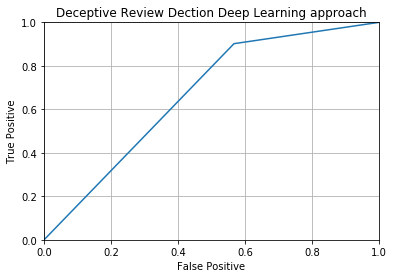

In [13]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

### NN 3

Neural Network summary:

- alpha = 8
- hidden layers = 5
- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [4]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 8

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

89


In [5]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 86s 220us/step - loss: 0.5889 - acc: 0.6991 - val_loss: 0.5599 - val_acc: 0.7175
Epoch 2/100
390870/390870 [==============================] - 80s 204us/step - loss: 0.5559 - acc: 0.7238 - val_loss: 0.5437 - val_acc: 0.7385
Epoch 3/100
390870/390870 [==============================] - 42s 109us/step - loss: 0.5473 - acc: 0.7302 - val_loss: 0.5678 - val_acc: 0.7257
Epoch 4/100
390870/390870 [==============================] - 26s 68us/step - loss: 0.5418 - acc: 0.7337 - val_loss: 0.5395 - val_acc: 0.7423
Epoch 5/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5385 - acc: 0.7362 - val_loss: 0.5365 - val_acc: 0.7395
Epoch 6/100
390870/390870 [==============================] - 26s 68us/step - loss: 0.5362 - acc: 0.7380 - val_loss: 0.5420 - val_acc: 0.7350
Epoch 7/100
390870/390870 [==============================] - 27s 68us/step - loss: 0.5351 - acc: 0.

In [7]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_3.h5")

In [8]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 18s 31us/step
[0.5327735302538145, 0.7514568775011509]


In [9]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')

In [10]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)

In [11]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.75      0.31      0.44     50930
           1       0.74      0.95      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.75      0.63      0.63    153993
weighted avg       0.74      0.74      0.70    153993

Accuracy for Deep Learning approach: 73.78582143344178


In [12]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[15639 35291]
 [ 5077 97986]]


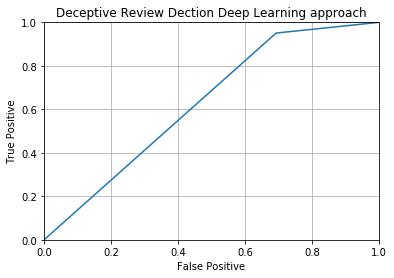

In [13]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [14]:
_del_all()

### NN 4

Neural Network summary:

- alpha = 5
- hidden layers = 6
- batch size = 100

In [15]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [16]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 8

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

89


In [17]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Sixth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 27s 70us/step - loss: 0.5898 - acc: 0.6983 - val_loss: 0.5598 - val_acc: 0.7252
Epoch 2/100
390870/390870 [==============================] - 27s 69us/step - loss: 0.5545 - acc: 0.7250 - val_loss: 0.5465 - val_acc: 0.7327
Epoch 3/100
390870/390870 [==============================] - 27s 68us/step - loss: 0.5461 - acc: 0.7305 - val_loss: 0.5469 - val_acc: 0.7400
Epoch 4/100
390870/390870 [==============================] - 27s 69us/step - loss: 0.5418 - acc: 0.7335 - val_loss: 0.5371 - val_acc: 0.7366
Epoch 5/100
390870/390870 [==============================] - 27s 69us/step - loss: 0.5390 - acc: 0.7357 - val_loss: 0.5364 - val_acc: 0.7400
Epoch 6/100
390870/390870 [==============================] - 27s 69us/step - loss: 0.5367 - acc: 0.7374 - val_loss: 0.5425 - val_acc: 0.7357
Epoch 7/100
390870/390870 [==============================] - 26s 68us/step - loss: 0.5349 - acc: 0.738

In [19]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_4.h5")

In [20]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 20s 35us/step
[0.5089105000514885, 0.758450247677916]


In [21]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')

In [22]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)

In [23]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.70      0.41      0.52     50930
           1       0.76      0.91      0.83    103063

    accuracy                           0.75    153993
   macro avg       0.73      0.66      0.67    153993
weighted avg       0.74      0.75      0.72    153993

Accuracy for Deep Learning approach: 74.58455903839784


In [24]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[20848 30082]
 [ 9056 94007]]


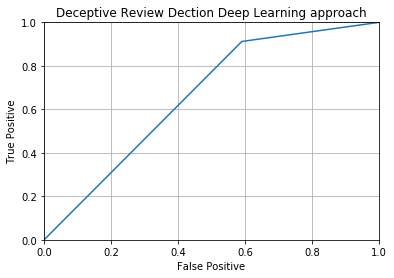

In [25]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

## 7. Other experiments

### 7.1 SVM without dimensionality reduction

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [4]:
best_model = _jl.load("../models/best_SVM.joblib")
best_model.set_params(verbose=10)
best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 10}

In [5]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[LibLinear]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=10)

In [6]:
_jl.dump(best_model, "../models/best_SVM_all.joblib")

['../models/best_SVM_all.joblib']

In [7]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

coef: [[-0.14394614 -0.20443318  0.34380749 ...  0.00380986  0.00857759
   0.        ]]
intercept: [-0.31154943]


In [8]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [9]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

predictions:
 [1 0 1 ... 0 0 0]


In [10]:
set(predic)

{0, 1}

In [11]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], predic)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.72      0.34      0.46     50930
           1       0.74      0.93      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.64      0.64    153993
weighted avg       0.73      0.74      0.71    153993

Accuracy for Support Vector Machine: 73.73971544161098


In [12]:
# Confusion matrix for SVC

print("Confusion Matrix for SVC: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for SVC: 


array([[17293, 33637],
       [ 6802, 96261]], dtype=int64)

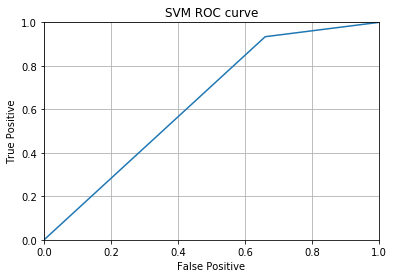

In [13]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("SVM ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

### 7.2 Random forest without dimensionality reduction

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [4]:
params = _jl.load("../models/best_Random_Forest_2.joblib").get_params()
params['n_jobs'] = -1
params['verbose'] = 10
best_model = _RandomForestClassifier(**params)
best_model.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 10,
 'warm_start': False}

In [5]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.0s


building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   53.2s


building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min


building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.7min


building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min


building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.0min


building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  5.2min


building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.1min


building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  7.1min


building tree 101 of 1000
building tree 102 of 1000
building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 106 of 1000
building tree 107 of 1000
building tree 108 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.1min


building tree 116 of 1000
building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  9.5min


building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000


[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 10.7min


building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000


[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 12.2min


building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 13.3min


building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tree 209 of 1000


[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 14.8min


building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tree 226 of 1000
building tree 227 of 1000
building tree 228 of 1000
building tree 229 of 1000


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed: 16.4min


building tree 230 of 1000
building tree 231 of 1000
building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
building tree 235 of 1000
building tree 236 of 1000
building tree 237 of 1000
building tree 238 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 244 of 1000
building tree 245 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 250 of 1000
building tree 251 of 1000
building tree 252 of 1000


[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed: 17.9min


building tree 253 of 1000
building tree 254 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 259 of 1000
building tree 260 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 270 of 1000
building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 275 of 1000


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 19.6min


building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000


[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 21.5min


building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000


[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed: 23.2min


building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 25.2min


building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000


[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 27.0min


building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000


[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 29.2min


building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000
building tree 417 of 1000
building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 425 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tree 431 of 1000
building tree 432 of 1000
building tree 433 of 1000
building tree 434 of 1000
building tree 435 of 1000
building tree 436 of 1000
building tree 437 of 1000


[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 31.3min


building tree 438 of 1000
building tree 439 of 1000
building tree 440 of 1000
building tree 441 of 1000
building tree 442 of 1000
building tree 443 of 1000
building tree 444 of 1000
building tree 445 of 1000
building tree 446 of 1000
building tree 447 of 1000
building tree 448 of 1000
building tree 449 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tree 455 of 1000
building tree 456 of 1000
building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 467 of 1000
building tree 468 of 1000
building tree 469 of 1000


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed: 33.5min


building tree 470 of 1000
building tree 471 of 1000
building tree 472 of 1000
building tree 473 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tree 476 of 1000
building tree 477 of 1000
building tree 478 of 1000
building tree 479 of 1000
building tree 480 of 1000
building tree 481 of 1000
building tree 482 of 1000
building tree 483 of 1000
building tree 484 of 1000
building tree 485 of 1000
building tree 486 of 1000
building tree 487 of 1000
building tree 488 of 1000
building tree 489 of 1000
building tree 490 of 1000
building tree 491 of 1000
building tree 492 of 1000
building tree 493 of 1000
building tree 494 of 1000
building tree 495 of 1000
building tree 496 of 1000
building tree 497 of 1000
building tree 498 of 1000
building tree 499 of 1000


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 35.6min


building tree 500 of 1000
building tree 501 of 1000
building tree 502 of 1000
building tree 503 of 1000
building tree 504 of 1000
building tree 505 of 1000
building tree 506 of 1000
building tree 507 of 1000
building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000building tree 524 of 1000

building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000


[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed: 38.1min


building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 561 of 1000
building tree 562 of 1000
building tree 563 of 1000
building tree 564 of 1000
building tree 565 of 1000


[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed: 40.4min


building tree 566 of 1000
building tree 567 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 570 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 574 of 1000
building tree 575 of 1000
building tree 576 of 1000
building tree 577 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 580 of 1000
building tree 581 of 1000
building tree 582 of 1000
building tree 583 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 586 of 1000
building tree 587 of 1000
building tree 588 of 1000
building tree 589 of 1000
building tree 590 of 1000
building tree 591 of 1000
building tree 592 of 1000
building tree 593 of 1000
building tree 594 of 1000
building tree 595 of 1000
building tree 596 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 599 of 1000
building tree 600 of 1000


[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed: 43.1min


building tree 601 of 1000
building tree 602 of 1000
building tree 603 of 1000
building tree 604 of 1000
building tree 605 of 1000
building tree 606 of 1000
building tree 607 of 1000
building tree 608 of 1000
building tree 609 of 1000
building tree 610 of 1000
building tree 611 of 1000
building tree 612 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000building tree 632 of 1000

building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 45.4min


building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000


[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed: 48.3min


building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
building tree 703 of 1000
building tree 704 of 1000
building tree 705 of 1000
building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 709 of 1000


[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed: 50.8min


building tree 710 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 717 of 1000
building tree 718 of 1000
building tree 719 of 1000
building tree 720 of 1000
building tree 721 of 1000
building tree 722 of 1000
building tree 723 of 1000
building tree 724 of 1000
building tree 725 of 1000
building tree 726 of 1000
building tree 727 of 1000
building tree 728 of 1000
building tree 729 of 1000
building tree 730 of 1000
building tree 731 of 1000
building tree 732 of 1000
building tree 733 of 1000
building tree 734 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 739 of 1000
building tree 740 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 743 of 1000
building tree 744 of 1000
building tree 745 of 1000
building tree 746 of 1000
building tree 747 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 737 tasks      | elapsed: 53.5min


building tree 750 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 753 of 1000
building tree 754 of 1000
building tree 755 of 1000
building tree 756 of 1000
building tree 757 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 760 of 1000
building tree 761 of 1000
building tree 762 of 1000
building tree 763 of 1000
building tree 764 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 769 of 1000
building tree 770 of 1000
building tree 771 of 1000
building tree 772 of 1000
building tree 773 of 1000
building tree 774 of 1000
building tree 775 of 1000
building tree 776 of 1000
building tree 777 of 1000
building tree 778 of 1000
building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tree 787 of 1000


[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 56.3min


building tree 788 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed: 59.5min


building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000
building tree 842 of 1000
building tree 843 of 1000
building tree 844 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tree 854 of 1000
building tree 855 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 858 of 1000
building tree 859 of 1000
building tree 860 of 1000
building tree 861 of 1000
building tree 862 of 1000
building tree 863 of 1000
building tree 864 of 1000
building tree 865 of 1000
building tree 866 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 62.3min


building tree 871 of 1000
building tree 872 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tree 875 of 1000
building tree 876 of 1000
building tree 877 of 1000
building tree 878 of 1000
building tree 879 of 1000
building tree 880 of 1000
building tree 881 of 1000
building tree 882 of 1000
building tree 883 of 1000
building tree 884 of 1000
building tree 885 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 888 of 1000
building tree 889 of 1000
building tree 890 of 1000
building tree 891 of 1000
building tree 892 of 1000
building tree 893 of 1000
building tree 894 of 1000
building tree 895 of 1000
building tree 896 of 1000
building tree 897 of 1000
building tree 898 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 902 of 1000
building tree 903 of 1000
building tree 904 of 1000
building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tree 908 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 901 tasks      | elapsed: 65.4min


building tree 913 of 1000
building tree 914 of 1000
building tree 915 of 1000
building tree 916 of 1000
building tree 917 of 1000
building tree 918 of 1000
building tree 919 of 1000
building tree 920 of 1000
building tree 921 of 1000
building tree 922 of 1000
building tree 923 of 1000
building tree 924 of 1000
building tree 925 of 1000
building tree 926 of 1000
building tree 927 of 1000
building tree 928 of 1000
building tree 929 of 1000
building tree 930 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 935 of 1000
building tree 936 of 1000
building tree 937 of 1000
building tree 938 of 1000
building tree 939 of 1000
building tree 940 of 1000
building tree 941 of 1000
building tree 942 of 1000
building tree 943 of 1000
building tree 944 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 947 of 1000
building tree 948 of 1000
building tree 949 of 1000
building tree 950 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 68.6min


building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 72.3min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=10, warm_start=False)

In [6]:
_jl.dump(best_model, "../models/best_Random_Forest_all.joblib")

['../models/best_Random_Forest_all.joblib']

In [7]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [8]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    4.5s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    5.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    5.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

predictions:
 [0 0 1 ... 0 1 0]


In [9]:
set(predic)

{0, 1}

In [10]:
# evaluate classifier

print("Report for Random Forest classifier:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Random Forest Classifier:", _accuracy_score(test_set['likes'], predic)*100)

Report for Random Forest classifier:
              precision    recall  f1-score   support

           0       0.69      0.38      0.49     50930
           1       0.75      0.92      0.82    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.65      0.66    153993
weighted avg       0.73      0.74      0.71    153993

Accuracy for Random Forest Classifier: 73.88907287993611


In [11]:
# Confusion matrix for Random Forest

print("Confusion Matrix for Random Forest: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for Random Forest: 


array([[19194, 31736],
       [ 8473, 94590]], dtype=int64)

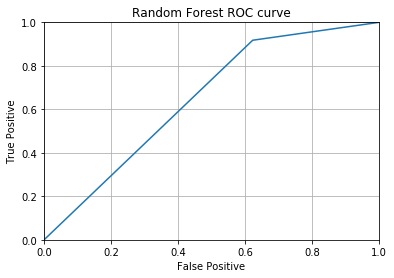

In [12]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Random Forest ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

### 7.3 Neural Network without dimensionality reduction

### NN1

Neural Network summary: 

- alpha = 6

- hidden layers = 3

- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [4]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 6

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

34


In [5]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 180s 461us/step - loss: 0.5932 - acc: 0.6968 - val_loss: 0.5693 - val_acc: 0.7170
Epoch 2/100
390870/390870 [==============================] - 143s 366us/step - loss: 0.5560 - acc: 0.7226 - val_loss: 0.5513 - val_acc: 0.7321
Epoch 3/100
390870/390870 [==============================] - 154s 395us/step - loss: 0.5464 - acc: 0.7302 - val_loss: 0.5414 - val_acc: 0.7336
Epoch 4/100
390870/390870 [==============================] - 131s 336us/step - loss: 0.5406 - acc: 0.7342 - val_loss: 0.5370 - val_acc: 0.7369
Epoch 5/100
390870/390870 [==============================] - 148s 379us/step - loss: 0.5383 - acc: 0.7357 - val_loss: 0.5326 - val_acc: 0.7431
Epoch 6/100
390870/390870 [==============================] - 163s 418us/step - loss: 0.5355 - acc: 0.7381 - val_loss: 0.5380 - val_acc: 0.7398
Epoch 7/100
390870/390870 [==============================] - 165s 422us/step - loss: 0.534

Epoch 58/100
390870/390870 [==============================] - 63s 162us/step - loss: 0.5091 - acc: 0.7550 - val_loss: 0.5194 - val_acc: 0.7495
Epoch 59/100
390870/390870 [==============================] - 63s 161us/step - loss: 0.5115 - acc: 0.7540 - val_loss: 0.5216 - val_acc: 0.7510
Epoch 60/100
390870/390870 [==============================] - 63s 161us/step - loss: 0.5085 - acc: 0.7554 - val_loss: 0.5181 - val_acc: 0.7511
Epoch 61/100
390870/390870 [==============================] - 63s 162us/step - loss: 0.5088 - acc: 0.7554 - val_loss: 0.5281 - val_acc: 0.7476
Epoch 62/100
390870/390870 [==============================] - 63s 162us/step - loss: 0.5089 - acc: 0.7552 - val_loss: 0.5264 - val_acc: 0.7459
Epoch 63/100
390870/390870 [==============================] - 64s 163us/step - loss: 0.5097 - acc: 0.7548 - val_loss: 0.5209 - val_acc: 0.7489
Epoch 64/100
390870/390870 [==============================] - 64s 164us/step - loss: 0.5105 - acc: 0.7545 - val_loss: 0.5215 - val_acc: 0.7495

In [7]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all.h5")

In [8]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 57s 101us/step
[0.512360177343886, 0.7563101510431093]


In [9]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [10]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [16]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [12]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.71      0.38      0.49     50930
           1       0.75      0.92      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.65      0.66    153993
weighted avg       0.74      0.74      0.72    153993

Accuracy for Deep Learning approach: 74.33649581474484


In [13]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[19270 31660]
 [ 7860 95203]]


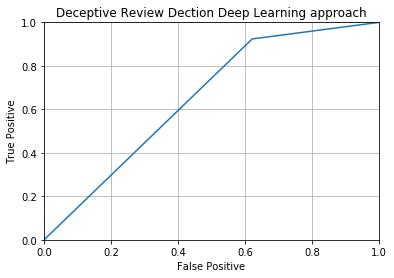

In [14]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

### NN 2

Neural Network summary: 

- alpha = 2

- hidden layers = 3

- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [4]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 2

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

67


In [5]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 76s 194us/step - loss: 0.5945 - acc: 0.6981 - val_loss: 0.5504 - val_acc: 0.7257
Epoch 2/100
390870/390870 [==============================] - 66s 168us/step - loss: 0.5560 - acc: 0.7232 - val_loss: 0.5542 - val_acc: 0.7265
Epoch 3/100
390870/390870 [==============================] - 66s 168us/step - loss: 0.5459 - acc: 0.7304 - val_loss: 0.5586 - val_acc: 0.7329
Epoch 4/100
390870/390870 [==============================] - 73s 186us/step - loss: 0.5414 - acc: 0.7336 - val_loss: 0.5431 - val_acc: 0.7366
Epoch 5/100
390870/390870 [==============================] - 69s 177us/step - loss: 0.5378 - acc: 0.7364 - val_loss: 0.5399 - val_acc: 0.7331
Epoch 6/100
390870/390870 [==============================] - 68s 174us/step - loss: 0.5355 - acc: 0.7382 - val_loss: 0.5342 - val_acc: 0.7421
Epoch 7/100
390870/390870 [==============================] - 68s 174us/step - loss: 0.5335 - acc

Epoch 58/100
390870/390870 [==============================] - 65s 166us/step - loss: 0.5069 - acc: 0.7559 - val_loss: 0.5317 - val_acc: 0.7491
Epoch 59/100
390870/390870 [==============================] - 70s 179us/step - loss: 0.5068 - acc: 0.7570 - val_loss: 0.5292 - val_acc: 0.7458
Epoch 60/100
390870/390870 [==============================] - 66s 169us/step - loss: 0.5057 - acc: 0.7573 - val_loss: 0.5221 - val_acc: 0.7499
Epoch 61/100
390870/390870 [==============================] - 65s 165us/step - loss: 0.5063 - acc: 0.7571 - val_loss: 0.5270 - val_acc: 0.7494
Epoch 62/100
390870/390870 [==============================] - 64s 163us/step - loss: 0.5055 - acc: 0.7571 - val_loss: 0.5219 - val_acc: 0.7496
Epoch 63/100
390870/390870 [==============================] - 64s 163us/step - loss: 0.5046 - acc: 0.7573 - val_loss: 0.5254 - val_acc: 0.7471
Epoch 64/100
390870/390870 [==============================] - 64s 163us/step - loss: 0.5055 - acc: 0.7571 - val_loss: 0.5264 - val_acc: 0.7494

In [7]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all2.h5")

In [8]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 51s 90us/step
[0.5102951304472344, 0.7552123441486025]


In [9]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [10]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [11]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [12]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.73      0.33      0.46     50930
           1       0.74      0.94      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.64      0.64    153993
weighted avg       0.74      0.74      0.70    153993

Accuracy for Deep Learning approach: 73.82478424343964


In [13]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[16881 34049]
 [ 6259 96804]]


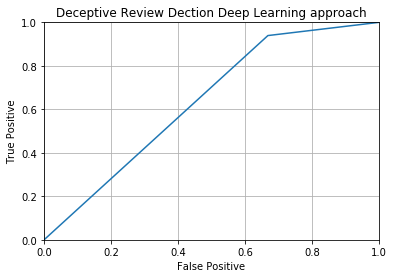

In [14]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

### NN 3

Neural Network summary: 

- alpha = 7

- hidden layers = 3

- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [4]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

29


In [5]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 82s 209us/step - loss: 0.5856 - acc: 0.7017 - val_loss: 0.5694 - val_acc: 0.7125
Epoch 2/100
390870/390870 [==============================] - 69s 176us/step - loss: 0.5533 - acc: 0.7251 - val_loss: 0.5492 - val_acc: 0.7293
Epoch 3/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5445 - acc: 0.7317 - val_loss: 0.5462 - val_acc: 0.7312
Epoch 4/100
390870/390870 [==============================] - 73s 187us/step - loss: 0.5410 - acc: 0.7339 - val_loss: 0.5389 - val_acc: 0.7389
Epoch 5/100
390870/390870 [==============================] - 68s 174us/step - loss: 0.5381 - acc: 0.7366 - val_loss: 0.5335 - val_acc: 0.7427
Epoch 6/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5354 - acc: 0.7376 - val_loss: 0.5365 - val_acc: 0.7390
Epoch 7/100
390870/390870 [==============================] - 67s 172us/step - loss: 0.5334 - acc

Epoch 58/100
390870/390870 [==============================] - 64s 164us/step - loss: 0.5102 - acc: 0.7545 - val_loss: 0.5283 - val_acc: 0.7459
Epoch 59/100
390870/390870 [==============================] - 64s 164us/step - loss: 0.5103 - acc: 0.7540 - val_loss: 0.5335 - val_acc: 0.7429
Epoch 60/100
390870/390870 [==============================] - 64s 164us/step - loss: 0.5104 - acc: 0.7539 - val_loss: 0.5281 - val_acc: 0.7426
Epoch 61/100
390870/390870 [==============================] - 64s 165us/step - loss: 0.5099 - acc: 0.7544 - val_loss: 0.5273 - val_acc: 0.7482
Epoch 62/100
390870/390870 [==============================] - 69s 178us/step - loss: 0.5114 - acc: 0.7540 - val_loss: 0.5351 - val_acc: 0.7420
Epoch 63/100
390870/390870 [==============================] - 64s 164us/step - loss: 0.5107 - acc: 0.7540 - val_loss: 0.5387 - val_acc: 0.7308
Epoch 64/100
390870/390870 [==============================] - 64s 164us/step - loss: 0.5099 - acc: 0.7547 - val_loss: 0.5230 - val_acc: 0.7477

In [7]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all3.h5")

In [8]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 54s 96us/step
[0.5092164321641403, 0.7539193317881909]


In [9]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [10]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [11]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [12]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.70      0.38      0.49     50930
           1       0.75      0.92      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.65      0.66    153993
weighted avg       0.74      0.74      0.72    153993

Accuracy for Deep Learning approach: 74.23843940958356


In [13]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[19398 31532]
 [ 8139 94924]]


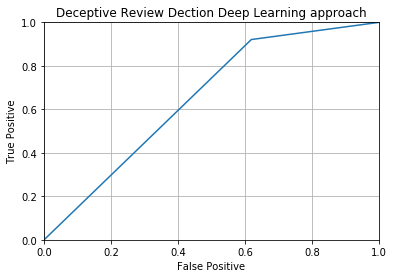

In [14]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [29]:
_del_all()

### NN 4

Neural Network summary: 

- alpha = 7
- hidden layers = 5
- batch size = 100

In [5]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [31]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

29


In [32]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 76s 194us/step - loss: 0.5860 - acc: 0.7003 - val_loss: 0.5558 - val_acc: 0.7246
Epoch 2/100
390870/390870 [==============================] - 68s 175us/step - loss: 0.5507 - acc: 0.7276 - val_loss: 0.5472 - val_acc: 0.7286
Epoch 3/100
390870/390870 [==============================] - 67s 172us/step - loss: 0.5437 - acc: 0.7324 - val_loss: 0.5416 - val_acc: 0.7332
Epoch 4/100
390870/390870 [==============================] - 67s 170us/step - loss: 0.5389 - acc: 0.7367 - val_loss: 0.5404 - val_acc: 0.7350
Epoch 5/100
390870/390870 [==============================] - 70s 180us/step - loss: 0.5355 - acc: 0.7380 - val_loss: 0.5455 - val_acc: 0.7335
Epoch 6/100
390870/390870 [==============================] - 82s 210us/step - loss: 0.5338 - acc: 0.7389 - val_loss: 0.5305 - val_acc: 0.7453
Epoch 7/100
390870/390870 [==============================] - 70s 179us/step - loss: 0.5318 - acc

In [34]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all5.h5")

In [6]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 53s 95us/step
[0.5069767637241182, 0.757692707194954]


In [7]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [8]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [9]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [10]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.69      0.43      0.53     50930
           1       0.76      0.90      0.83    103063

    accuracy                           0.75    153993
   macro avg       0.72      0.67      0.68    153993
weighted avg       0.74      0.75      0.73    153993

Accuracy for Deep Learning approach: 74.6254699888956


In [11]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[21761 29169]
 [ 9906 93157]]


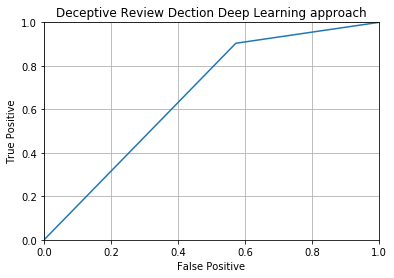

In [12]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [13]:
_del_all()

### NN 5

Neural Network summary: 

- alpha = 7
- hidden layers = 5
- batch size = 500

In [14]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [15]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

29


In [16]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 500, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 57s 145us/step - loss: 0.6050 - acc: 0.6886 - val_loss: 0.5680 - val_acc: 0.7174
Epoch 2/100
390870/390870 [==============================] - 54s 138us/step - loss: 0.5585 - acc: 0.7214 - val_loss: 0.5550 - val_acc: 0.7256
Epoch 3/100
390870/390870 [==============================] - 53s 136us/step - loss: 0.5464 - acc: 0.7309 - val_loss: 0.5400 - val_acc: 0.7387
Epoch 4/100
390870/390870 [==============================] - 53s 135us/step - loss: 0.5406 - acc: 0.7345 - val_loss: 0.5605 - val_acc: 0.7164
Epoch 5/100
390870/390870 [==============================] - 53s 135us/step - loss: 0.5363 - acc: 0.7370 - val_loss: 0.5421 - val_acc: 0.7324
Epoch 6/100
390870/390870 [==============================] - 54s 137us/step - loss: 0.5341 - acc: 0.7390 - val_loss: 0.5412 - val_acc: 0.7340
Epoch 7/100
390870/390870 [==============================] - 53s 136us/step - loss: 0.5315 - acc

Epoch 58/100
390870/390870 [==============================] - 51s 131us/step - loss: 0.5073 - acc: 0.7564 - val_loss: 0.5199 - val_acc: 0.7509
Epoch 59/100
390870/390870 [==============================] - 77s 198us/step - loss: 0.5079 - acc: 0.7558 - val_loss: 0.5295 - val_acc: 0.7464
Epoch 60/100
390870/390870 [==============================] - 54s 138us/step - loss: 0.5064 - acc: 0.7564 - val_loss: 0.5291 - val_acc: 0.7469
Epoch 61/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5065 - acc: 0.7568 - val_loss: 0.5185 - val_acc: 0.7520
Epoch 62/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5065 - acc: 0.7568 - val_loss: 0.5221 - val_acc: 0.7496
Epoch 63/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5059 - acc: 0.7571 - val_loss: 0.5276 - val_acc: 0.7488
Epoch 64/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5057 - acc: 0.7574 - val_loss: 0.5204 - val_acc: 0.7505

In [18]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all6.h5")

In [19]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 46s 83us/step
[0.5109344036041277, 0.7546177733688839]


In [20]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [21]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [22]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [23]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.73      0.34      0.46     50930
           1       0.74      0.94      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.74      0.64      0.65    153993
weighted avg       0.74      0.74      0.71    153993

Accuracy for Deep Learning approach: 73.97803796276455


In [24]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[17292 33638]
 [ 6434 96629]]


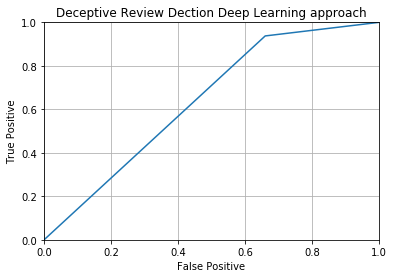

In [25]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [26]:
_del_all()

### NN 6

Neural Network summary: 

- alpha = 6
- hidden layers = 5
- batch size = 100

In [27]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [28]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 6

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

34


In [29]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 71s 183us/step - loss: 0.5860 - acc: 0.7012 - val_loss: 0.5567 - val_acc: 0.7211
Epoch 2/100
390870/390870 [==============================] - 66s 168us/step - loss: 0.5531 - acc: 0.7259 - val_loss: 0.5461 - val_acc: 0.7325
Epoch 3/100
390870/390870 [==============================] - 65s 166us/step - loss: 0.5453 - acc: 0.7313 - val_loss: 0.5470 - val_acc: 0.7292
Epoch 4/100
390870/390870 [==============================] - 65s 167us/step - loss: 0.5406 - acc: 0.7342 - val_loss: 0.5556 - val_acc: 0.7176
Epoch 5/100
390870/390870 [==============================] - 65s 166us/step - loss: 0.5377 - acc: 0.7368 - val_loss: 0.5365 - val_acc: 0.7417
Epoch 6/100
390870/390870 [==============================] - 70s 179us/step - loss: 0.5350 - acc: 0.7385 - val_loss: 0.5380 - val_acc: 0.7371
Epoch 7/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5324 - acc

Epoch 58/100
390870/390870 [==============================] - 66s 168us/step - loss: 0.5070 - acc: 0.7561 - val_loss: 0.5300 - val_acc: 0.7478
Epoch 59/100
390870/390870 [==============================] - 66s 168us/step - loss: 0.5062 - acc: 0.7567 - val_loss: 0.5801 - val_acc: 0.7259
Epoch 60/100
390870/390870 [==============================] - 70s 180us/step - loss: 0.5056 - acc: 0.7570 - val_loss: 0.5222 - val_acc: 0.7502
Epoch 61/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5059 - acc: 0.7568 - val_loss: 0.5229 - val_acc: 0.7499
Epoch 62/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5056 - acc: 0.7569 - val_loss: 0.5210 - val_acc: 0.7501
Epoch 63/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5055 - acc: 0.7574 - val_loss: 0.5225 - val_acc: 0.7503
Epoch 64/100
390870/390870 [==============================] - 67s 171us/step - loss: 0.5059 - acc: 0.7569 - val_loss: 0.5217 - val_acc: 0.7521

In [31]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all7.h5")

In [32]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 48s 87us/step
[0.5033024442936678, 0.7597557961701017]


In [33]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [34]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [35]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [36]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.69      0.42      0.52     50930
           1       0.76      0.91      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.66      0.67    153993
weighted avg       0.74      0.74      0.72    153993

Accuracy for Deep Learning approach: 74.48585325306995


In [37]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[21192 29738]
 [ 9552 93511]]


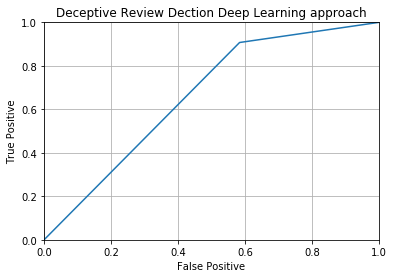

In [38]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [39]:
_del_all()

### NN 7

Neural Network summary: 

- alpha = 6
- hidden layers = 5
- batch size = 500

In [4]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [41]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 6

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

34


In [42]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [43]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 500, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 60s 153us/step - loss: 0.6000 - acc: 0.6893 - val_loss: 0.5623 - val_acc: 0.7238
Epoch 2/100
390870/390870 [==============================] - 52s 134us/step - loss: 0.5547 - acc: 0.7240 - val_loss: 0.5505 - val_acc: 0.7272
Epoch 3/100
390870/390870 [==============================] - 51s 131us/step - loss: 0.5446 - acc: 0.7316 - val_loss: 0.5395 - val_acc: 0.7382
Epoch 4/100
390870/390870 [==============================] - 50s 128us/step - loss: 0.5374 - acc: 0.7368 - val_loss: 0.5323 - val_acc: 0.7432
Epoch 5/100
390870/390870 [==============================] - 50s 128us/step - loss: 0.5366 - acc: 0.7371 - val_loss: 0.5371 - val_acc: 0.7398
Epoch 6/100
390870/390870 [==============================] - 50s 128us/step - loss: 0.5339 - acc: 0.7391 - val_loss: 0.5352 - val_acc: 0.7395
Epoch 7/100
390870/390870 [==============================] - 51s 130us/step - loss: 0.5312 - acc

Epoch 58/100
390870/390870 [==============================] - 58s 147us/step - loss: 0.5044 - acc: 0.7573 - val_loss: 0.5236 - val_acc: 0.7504
Epoch 59/100
390870/390870 [==============================] - 53s 136us/step - loss: 0.5040 - acc: 0.7578 - val_loss: 0.5192 - val_acc: 0.7520
Epoch 60/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5034 - acc: 0.7588 - val_loss: 0.5231 - val_acc: 0.7494
Epoch 61/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5031 - acc: 0.7582 - val_loss: 0.5236 - val_acc: 0.7493
Epoch 62/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5036 - acc: 0.7582 - val_loss: 0.5184 - val_acc: 0.7514
Epoch 63/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5038 - acc: 0.7582 - val_loss: 0.5226 - val_acc: 0.7502
Epoch 64/100
390870/390870 [==============================] - 52s 133us/step - loss: 0.5035 - acc: 0.7580 - val_loss: 0.5202 - val_acc: 0.7512

In [44]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all8.h5")

In [5]:
# evaluation of the model training
classifier = _load_model("../models/trained_deep_neural_network_all8.h5")  # DEBUG!!!
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 54s 97us/step
[0.5078941215270898, 0.7580132739713417]


In [6]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [7]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [8]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [9]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53     50930
           1       0.76      0.89      0.82    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.67      0.68    153993
weighted avg       0.73      0.74      0.73    153993

Accuracy for Deep Learning approach: 74.25792081458248


In [10]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[22257 28673]
 [10968 92095]]


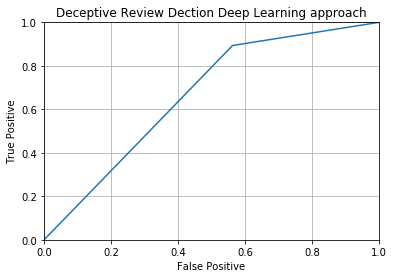

In [11]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [ ]:
_del_all()

### NN 8

Neural Network summary: 

- alpha = 8
- hidden layers = 5
- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_2.pickle')
train_set.shape

(558386, 2774)

In [4]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 8

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

25


In [5]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 97s 249us/step - loss: 0.5884 - acc: 0.6991 - val_loss: 0.5596 - val_acc: 0.7209
Epoch 2/100
390870/390870 [==============================] - 132s 339us/step - loss: 0.5530 - acc: 0.7257 - val_loss: 0.5444 - val_acc: 0.7335
Epoch 3/100
390870/390870 [==============================] - 92s 235us/step - loss: 0.5437 - acc: 0.7323 - val_loss: 0.5402 - val_acc: 0.7374
Epoch 4/100
390870/390870 [==============================] - 80s 205us/step - loss: 0.5398 - acc: 0.7353 - val_loss: 0.5386 - val_acc: 0.7420
Epoch 5/100
390870/390870 [==============================] - 76s 194us/step - loss: 0.5376 - acc: 0.7369 - val_loss: 0.5458 - val_acc: 0.7319
Epoch 6/100
390870/390870 [==============================] - 78s 198us/step - loss: 0.5349 - acc: 0.7388 - val_loss: 0.5438 - val_acc: 0.7389
Epoch 7/100
390870/390870 [==============================] - 76s 195us/step - loss: 0.5334 - ac

In [7]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_all9.h5")

In [8]:
# evaluation of the model training
classifier = _load_model("../models/trained_deep_neural_network_all8.h5")  # DEBUG!!!
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 58s 104us/step
[0.5078941215270898, 0.7580132739713417]


In [9]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_2.pickle')
test_set.shape

(153993, 2774)

In [10]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [11]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [12]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53     50930
           1       0.76      0.89      0.82    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.67      0.68    153993
weighted avg       0.73      0.74      0.73    153993

Accuracy for Deep Learning approach: 74.25792081458248


In [13]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[22257 28673]
 [10968 92095]]


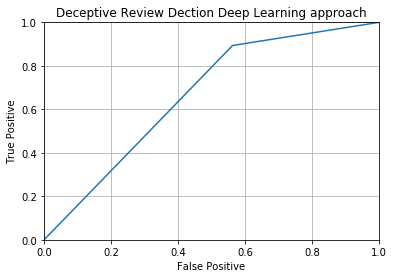

In [14]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [15]:
_del_all()

### 7.4 SVM without fake reviews

In [16]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [17]:
train_set = train_set[train_set['bin_truth_score']!=-1]
train_set.shape

(438571, 787)

In [18]:
best_model = _jl.load("../models/best_SVM.joblib")
best_model.set_params(verbose=10)
best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 10}

In [19]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[LibLinear]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=10)

In [20]:
_jl.dump(best_model, "../models/best_SVM_fake.joblib")

['../models/best_SVM_fake.joblib']

In [21]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

coef: [[-1.38515487e-01 -1.96857288e-01  3.32402060e-01 -2.91255272e-01
  -1.69144522e-01  4.39209749e-02  2.42195943e-02  3.64156997e-02
  -2.46790916e-02 -1.02787607e-02 -4.86873857e-02 -4.97584956e-05
  -3.22987927e-02  6.88759948e-03 -1.03371270e-05  6.50742395e-01
  -1.29562758e-04  1.03416295e-03 -2.48775106e-04 -6.59642374e-04
  -1.02036028e-04 -9.66791010e-04  1.14359591e-03 -1.99843890e-04
  -6.27763021e-05  3.69227212e-04  2.38756561e-06 -1.18488072e-05
   3.94093254e-05 -2.29569450e-04 -8.67235837e-02  8.89035480e-06
  -7.57976137e-04  3.93742819e-04 -4.55403368e-02 -3.54663199e-04
  -3.18629560e-02  5.23979128e-02  3.66236285e-04  1.77877828e-02
  -8.52227099e-04 -2.36155968e-04  9.56668382e-05  1.75930155e-04
   6.77026802e-05 -5.13757145e-03  1.89471500e-02 -8.09871718e-04
   3.60054753e-03  6.19090568e-03  3.79168413e-02 -8.57468383e-04
   5.00425524e-02  5.05812751e-03  2.68403245e-02  4.03692064e-02
   2.11274126e-02  2.88136834e-02  1.73991590e-02 -5.80037087e-03
  -6

In [22]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.shape

(153993, 787)

In [23]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

predictions:
 [0 1 0 ... 0 1 1]


In [24]:
set(predic)

{0, 1}

In [25]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], predic)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.65      0.35      0.45     50930
           1       0.74      0.91      0.81    103063

    accuracy                           0.72    153993
   macro avg       0.70      0.63      0.63    153993
weighted avg       0.71      0.72      0.70    153993

Accuracy for Support Vector Machine: 72.28900014935743


In [26]:
# Confusion matrix for SVC

print("Confusion Matrix for SVC: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for SVC: 


array([[17698, 33232],
       [ 9441, 93622]], dtype=int64)

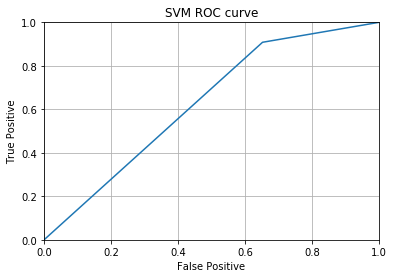

In [27]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("SVM ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [28]:
_del_all()

### 7.5 Random forest without fake reviews

In [29]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [30]:
train_set = train_set[train_set['bin_truth_score']!=-1]
train_set.shape

(438571, 787)

In [31]:
params = _jl.load("../models/best_Random_Forest_2.joblib").get_params()
params['n_jobs'] = -1
params['verbose'] = 10
best_model = _RandomForestClassifier(**params)
best_model.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 10,
 'warm_start': False}

In [32]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.4s


building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.2s


building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.7s


building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.7s


building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min


building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.9min


building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.2min


building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.5min


building tree 101 of 1000
building tree 102 of 1000
building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 106 of 1000
building tree 107 of 1000
building tree 108 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 114 of 1000building tree 115 of 1000

building tree 116 of 1000


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.9min


building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.4min


building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000


[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.9min


building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000


[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  4.4min


building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min


building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000


[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  5.5min


building tree 209 of 1000
building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tree 226 of 1000
building tree 227 of 1000
building tree 228 of 1000
building tree 229 of 1000


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  6.1min


building tree 230 of 1000
building tree 231 of 1000
building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
building tree 235 of 1000
building tree 236 of 1000
building tree 237 of 1000
building tree 238 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 244 of 1000
building tree 245 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 250 of 1000
building tree 251 of 1000
building tree 252 of 1000


[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:  6.8min


building tree 253 of 1000
building tree 254 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 259 of 1000
building tree 260 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 270 of 1000
building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 275 of 1000


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  7.3min


building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000


[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  8.1min


building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000


[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:  8.7min


building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  9.5min


building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000


[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 10.2min


building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000


[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 11.0min


building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000
building tree 417 of 1000
building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 425 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tree 431 of 1000
building tree 432 of 1000
building tree 433 of 1000
building tree 434 of 1000
building tree 435 of 1000
building tree 436 of 1000
building tree 437 of 1000
building tree 438 of 1000


[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.8min


building tree 439 of 1000
building tree 440 of 1000
building tree 441 of 1000
building tree 442 of 1000
building tree 443 of 1000
building tree 444 of 1000
building tree 445 of 1000
building tree 446 of 1000
building tree 447 of 1000
building tree 448 of 1000
building tree 449 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tree 455 of 1000
building tree 456 of 1000
building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 467 of 1000
building tree 468 of 1000


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed: 12.7min


building tree 469 of 1000
building tree 470 of 1000
building tree 471 of 1000
building tree 472 of 1000
building tree 473 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tree 476 of 1000
building tree 477 of 1000
building tree 478 of 1000
building tree 479 of 1000
building tree 480 of 1000
building tree 481 of 1000
building tree 482 of 1000
building tree 483 of 1000
building tree 484 of 1000
building tree 485 of 1000
building tree 486 of 1000
building tree 487 of 1000
building tree 488 of 1000
building tree 489 of 1000
building tree 490 of 1000
building tree 491 of 1000
building tree 492 of 1000
building tree 493 of 1000
building tree 494 of 1000
building tree 495 of 1000
building tree 496 of 1000
building tree 497 of 1000
building tree 498 of 1000
building tree 499 of 1000


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 13.5min


building tree 500 of 1000
building tree 501 of 1000
building tree 502 of 1000
building tree 503 of 1000
building tree 504 of 1000
building tree 505 of 1000
building tree 506 of 1000
building tree 507 of 1000
building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000


[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed: 14.4min


building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 561 of 1000
building tree 562 of 1000
building tree 563 of 1000
building tree 564 of 1000
building tree 565 of 1000
building tree 566 of 1000
building tree 567 of 1000


[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed: 15.3min


building tree 568 of 1000
building tree 569 of 1000
building tree 570 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 574 of 1000
building tree 575 of 1000
building tree 576 of 1000
building tree 577 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 580 of 1000
building tree 581 of 1000
building tree 582 of 1000
building tree 583 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 586 of 1000
building tree 587 of 1000
building tree 588 of 1000
building tree 589 of 1000
building tree 590 of 1000
building tree 591 of 1000
building tree 592 of 1000
building tree 593 of 1000
building tree 594 of 1000
building tree 595 of 1000
building tree 596 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 599 of 1000
building tree 600 of 1000


[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed: 16.3min


building tree 601 of 1000
building tree 602 of 1000
building tree 603 of 1000
building tree 604 of 1000
building tree 605 of 1000
building tree 606 of 1000
building tree 607 of 1000
building tree 608 of 1000
building tree 609 of 1000
building tree 610 of 1000
building tree 611 of 1000
building tree 612 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 17.2min


building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000


[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed: 18.2min


building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
building tree 703 of 1000
building tree 704 of 1000
building tree 705 of 1000
building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 709 of 1000


[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed: 19.2min


building tree 710 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 717 of 1000
building tree 718 of 1000
building tree 719 of 1000
building tree 720 of 1000
building tree 721 of 1000
building tree 722 of 1000
building tree 723 of 1000
building tree 724 of 1000
building tree 725 of 1000
building tree 726 of 1000
building tree 727 of 1000
building tree 728 of 1000
building tree 729 of 1000
building tree 730 of 1000
building tree 731 of 1000
building tree 732 of 1000
building tree 733 of 1000
building tree 734 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 739 of 1000
building tree 740 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 743 of 1000
building tree 744 of 1000
building tree 745 of 1000
building tree 746 of 1000
building tree 747 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 737 tasks      | elapsed: 20.3min


building tree 749 of 1000
building tree 750 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 753 of 1000
building tree 754 of 1000
building tree 755 of 1000
building tree 756 of 1000
building tree 757 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 760 of 1000
building tree 761 of 1000
building tree 762 of 1000
building tree 763 of 1000
building tree 764 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 769 of 1000
building tree 770 of 1000
building tree 771 of 1000
building tree 772 of 1000
building tree 773 of 1000
building tree 774 of 1000
building tree 775 of 1000
building tree 776 of 1000
building tree 777 of 1000
building tree 778 of 1000
building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 21.3min


building tree 788 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed: 22.4min


building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000
building tree 842 of 1000
building tree 843 of 1000
building tree 844 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tree 854 of 1000
building tree 855 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 858 of 1000
building tree 859 of 1000
building tree 860 of 1000
building tree 861 of 1000
building tree 862 of 1000
building tree 863 of 1000
building tree 864 of 1000
building tree 865 of 1000
building tree 866 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 23.6min


building tree 870 of 1000
building tree 871 of 1000
building tree 872 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tree 875 of 1000
building tree 876 of 1000
building tree 877 of 1000
building tree 878 of 1000
building tree 879 of 1000
building tree 880 of 1000
building tree 881 of 1000
building tree 882 of 1000
building tree 883 of 1000
building tree 884 of 1000
building tree 885 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 888 of 1000
building tree 889 of 1000
building tree 890 of 1000
building tree 891 of 1000
building tree 892 of 1000
building tree 893 of 1000
building tree 894 of 1000
building tree 895 of 1000
building tree 896 of 1000
building tree 897 of 1000
building tree 898 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 902 of 1000
building tree 903 of 1000
building tree 904 of 1000
building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 901 tasks      | elapsed: 24.7min


building tree 913 of 1000
building tree 914 of 1000
building tree 915 of 1000
building tree 916 of 1000
building tree 917 of 1000
building tree 918 of 1000
building tree 919 of 1000
building tree 920 of 1000
building tree 921 of 1000
building tree 922 of 1000
building tree 923 of 1000
building tree 924 of 1000
building tree 925 of 1000
building tree 926 of 1000
building tree 927 of 1000
building tree 928 of 1000
building tree 929 of 1000
building tree 930 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 935 of 1000
building tree 936 of 1000
building tree 937 of 1000
building tree 938 of 1000
building tree 939 of 1000
building tree 940 of 1000
building tree 941 of 1000
building tree 942 of 1000
building tree 943 of 1000
building tree 944 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 947 of 1000
building tree 948 of 1000
building tree 949 of 1000
building tree 950 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 25.9min


building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 27.3min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=10, warm_start=False)

In [33]:
_jl.dump(best_model, "../models/best_Random_Forest_fake.joblib")

['../models/best_Random_Forest_fake.joblib']

In [34]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.shape

(153993, 787)

In [35]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

predictions:
 [0 0 1 ... 0 0 0]


[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:   24.5s finished


In [36]:
set(predic)

{0, 1}

In [37]:
# evaluate classifier

print("Report for Random Forest classifier:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Random Forest Classifier:", _accuracy_score(test_set['likes'], predic)*100)

Report for Random Forest classifier:
              precision    recall  f1-score   support

           0       0.68      0.41      0.51     50930
           1       0.76      0.90      0.82    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.66      0.67    153993
weighted avg       0.73      0.74      0.72    153993

Accuracy for Random Forest Classifier: 74.14947432675511


In [38]:
# Confusion matrix for Random Forest

print("Confusion Matrix for Random Forest: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for Random Forest: 


array([[21058, 29872],
       [ 9936, 93127]], dtype=int64)

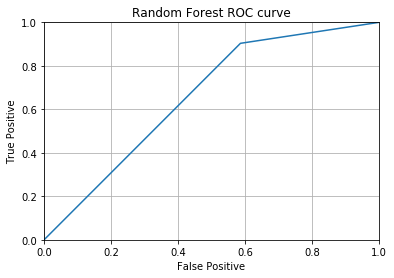

In [39]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Random Forest ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [40]:
_del_all()

### 7.6 Neural Network without fake reviews

Neural Network summary: 

- alpha = 7 
- hidden layers = 5
- batch size = 100

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [4]:
train_set = train_set[train_set['bin_truth_score']!=-1]
train_set.shape

(438571, 787)

In [5]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

80


In [6]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [7]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 306999 samples, validate on 131572 samples
Epoch 1/100
306999/306999 [==============================] - 30s 98us/step - loss: 0.6015 - acc: 0.6869 - val_loss: 0.5663 - val_acc: 0.7137
Epoch 2/100
306999/306999 [==============================] - 24s 79us/step - loss: 0.5644 - acc: 0.7154 - val_loss: 0.5518 - val_acc: 0.7288
Epoch 3/100
306999/306999 [==============================] - 24s 80us/step - loss: 0.5541 - acc: 0.7242 - val_loss: 0.5727 - val_acc: 0.7173
Epoch 4/100
306999/306999 [==============================] - 24s 77us/step - loss: 0.5498 - acc: 0.7276 - val_loss: 0.5402 - val_acc: 0.7353
Epoch 5/100
306999/306999 [==============================] - 25s 82us/step - loss: 0.5467 - acc: 0.7291 - val_loss: 0.5481 - val_acc: 0.7297
Epoch 6/100
306999/306999 [==============================] - 25s 80us/step - loss: 0.5438 - acc: 0.7325 - val_loss: 0.5427 - val_acc: 0.7352
Epoch 7/100
306999/306999 [==============================] - 24s 78us/step - loss: 0.5427 - acc: 0.732

In [8]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_fake.h5")

In [9]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

438571/438571 [==============================] - 12s 28us/step
[0.5348048495635159, 0.7506811895911467]


In [10]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.shape

(153993, 787)

In [11]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [12]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [13]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.69      0.39      0.50     50930
           1       0.75      0.92      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.65      0.66    153993
weighted avg       0.73      0.74      0.72    153993

Accuracy for Deep Learning approach: 74.06700304559298


In [14]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[19674 31256]
 [ 8679 94384]]


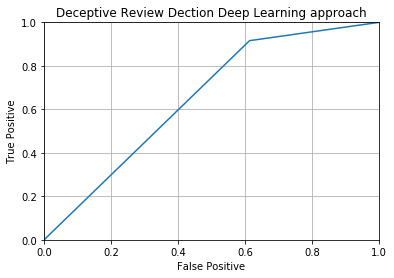

In [15]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [16]:
_del_all()

### 7.7 SVM only standard columns

In [3]:
# columns we are going to remove from the dataset

_cols_std = ['cuisine_av_hist', 'coll_score', 'average_stars_review', 'num_reviews_review',
            'average_stars_user', 'num_reviews_user',
            'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine']


_cols_bin = ['cuisine_av_hist_bin', 'bin_truth_score', 'coll_score_bin', 'average_stars_bin_review',
            'num_reviews_bin_review', 'average_stars_bin_user', 'num_reviews_bin_user',
            'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
            'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
            'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
            'av_rat_asianfusion_cuisine_bin']


_cols_real = ['cuisine_av_hist_real', 'real_truth_score', 'coll_score_real', 'average_stars_real_review',
             'num_reviews_real_review', 'average_stars_real_user', 'num_reviews_real_user',
             'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
             'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
             'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
             'av_rat_asianfusion_cuisine_real']

In [4]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [5]:
train_set = train_set.drop(columns=[*_cols_bin, *_cols_real])
train_set.shape

(558386, 753)

In [6]:
best_model = _jl.load("../models/best_SVM.joblib")
best_model.set_params(verbose=10)
best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 10}

In [7]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[LibLinear]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=10)

In [8]:
_jl.dump(best_model, "../models/best_SVM_std.joblib")

['../models/best_SVM_std.joblib']

In [9]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

coef: [[-1.45163681e-01 -2.06192678e-01  3.43101354e-01  9.50706829e-02
  -7.67267815e-02  1.75285027e-05 -3.59168241e-02  7.69028847e-03
  -3.37551424e-05  6.44365981e-01 -8.19044376e-05  9.98650771e-04
   2.85675869e-04 -8.07039934e-04 -5.88016148e-04 -6.42377233e-04
   1.10320520e-03 -2.13229419e-04 -1.36944603e-04  4.43540753e-04
  -4.35994723e-05  6.60548107e-05 -9.40240234e-06 -3.16915159e-04
  -1.36081275e-01  7.99684151e-05 -4.15239339e-02  6.73184431e-02
   3.00972016e-04  1.54171072e-02 -5.04502256e-04 -2.20501470e-04
   4.92195916e-05  1.81076061e-04  3.69069303e-05 -5.94465246e-04
   3.11871960e-02  2.33957370e-02  3.60430435e-02  4.00775537e-02
   5.32107117e-02  4.93676643e-02  1.37202769e-02  2.57261458e-02
   1.96609415e-02  4.11802748e-02 -1.30191311e-01 -9.69832815e-02
  -1.33655698e-01 -8.26716794e-02 -1.30493220e-01 -1.47665391e-01
  -1.32102583e-01 -1.12734326e-01 -1.15993381e-01 -1.25985560e-01
  -1.18534497e-01 -1.16310232e-01 -8.86037761e-02 -8.85625045e-02
  -9

In [10]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set = test_set.drop(columns=[*_cols_bin, *_cols_real])
test_set.shape

(153993, 753)

In [11]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

predictions:
 [1 0 1 ... 0 0 0]


In [12]:
set(predic)

{0, 1}

In [13]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], predic)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.70      0.36      0.48     50930
           1       0.75      0.92      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.64      0.65    153993
weighted avg       0.73      0.74      0.71    153993

Accuracy for Support Vector Machine: 73.79556213594124


In [14]:
# Confusion matrix for SVC

print("Confusion Matrix for SVC: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for SVC: 


array([[18342, 32588],
       [ 7765, 95298]], dtype=int64)

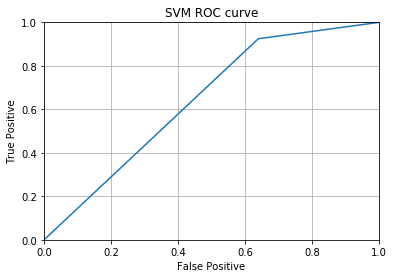

In [15]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("SVM ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [16]:
_del_all()

### 7.8 Random forest only standard columns

In [17]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [18]:
train_set = train_set.drop(columns=[*_cols_bin, *_cols_real])
train_set.shape

(558386, 753)

In [19]:
params = _jl.load("../models/best_Random_Forest_2.joblib").get_params()
params['n_jobs'] = -1
params['verbose'] = 10
best_model = _RandomForestClassifier(**params)
best_model.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 10,
 'warm_start': False}

In [20]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000

building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.9s


building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.6s


building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   44.0s


building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min



building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.6min


building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.1min


building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.5min


building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000
building tree 101 of 1000

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.0min



building tree 102 of 1000
building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 106 of 1000
building tree 107 of 1000
building tree 108 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.5min


building tree 116 of 1000
building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  4.0min


building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000


[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.6min


building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000


[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  5.2min


building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.8min


building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000


[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  6.5min


building tree 209 of 1000
building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tree 226 of 1000
building tree 227 of 1000
building tree 228 of 1000
building tree 229 of 1000
building tree 230 of 1000


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  7.3min


building tree 231 of 1000
building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
building tree 235 of 1000
building tree 236 of 1000
building tree 237 of 1000
building tree 238 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 244 of 1000
building tree 245 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 250 of 1000
building tree 251 of 1000
building tree 252 of 1000


[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:  8.0min


building tree 253 of 1000
building tree 254 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 259 of 1000
building tree 260 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 270 of 1000
building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 275 of 1000


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.7min


building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000


[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  9.6min


building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000


[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed: 10.4min


building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 11.2min


building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000


[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 12.0min


building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000


[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 12.9min


building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000
building tree 417 of 1000
building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 425 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tree 431 of 1000
building tree 432 of 1000
building tree 433 of 1000
building tree 434 of 1000
building tree 435 of 1000
building tree 436 of 1000
building tree 437 of 1000


[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 13.8min


building tree 438 of 1000
building tree 439 of 1000
building tree 440 of 1000
building tree 441 of 1000
building tree 442 of 1000
building tree 443 of 1000
building tree 444 of 1000
building tree 445 of 1000
building tree 446 of 1000
building tree 447 of 1000
building tree 448 of 1000
building tree 449 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tree 455 of 1000
building tree 456 of 1000
building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 467 of 1000
building tree 468 of 1000


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed: 14.9min


building tree 469 of 1000
building tree 470 of 1000
building tree 471 of 1000
building tree 472 of 1000
building tree 473 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tree 476 of 1000
building tree 477 of 1000
building tree 478 of 1000
building tree 479 of 1000
building tree 480 of 1000
building tree 481 of 1000
building tree 482 of 1000
building tree 483 of 1000
building tree 484 of 1000
building tree 485 of 1000
building tree 486 of 1000
building tree 487 of 1000
building tree 488 of 1000
building tree 489 of 1000
building tree 490 of 1000
building tree 491 of 1000
building tree 492 of 1000
building tree 493 of 1000
building tree 494 of 1000
building tree 495 of 1000
building tree 496 of 1000
building tree 497 of 1000
building tree 498 of 1000
building tree 499 of 1000


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 15.9min


building tree 500 of 1000
building tree 501 of 1000
building tree 502 of 1000
building tree 503 of 1000
building tree 504 of 1000
building tree 505 of 1000
building tree 506 of 1000
building tree 507 of 1000
building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000


[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed: 16.9min


building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 561 of 1000
building tree 562 of 1000
building tree 563 of 1000
building tree 564 of 1000
building tree 565 of 1000
building tree 566 of 1000


[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed: 18.0min


building tree 567 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 570 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 574 of 1000
building tree 575 of 1000
building tree 576 of 1000
building tree 577 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 580 of 1000
building tree 581 of 1000
building tree 582 of 1000
building tree 583 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 586 of 1000
building tree 587 of 1000
building tree 588 of 1000
building tree 589 of 1000
building tree 590 of 1000
building tree 591 of 1000
building tree 592 of 1000
building tree 593 of 1000
building tree 594 of 1000
building tree 595 of 1000
building tree 596 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 599 of 1000
building tree 600 of 1000


[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed: 19.2min


building tree 601 of 1000
building tree 602 of 1000
building tree 603 of 1000
building tree 604 of 1000
building tree 605 of 1000
building tree 606 of 1000
building tree 607 of 1000
building tree 608 of 1000
building tree 609 of 1000
building tree 610 of 1000
building tree 611 of 1000
building tree 612 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 20.3min


building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000


[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed: 21.5min


building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
building tree 703 of 1000
building tree 704 of 1000
building tree 705 of 1000
building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 709 of 1000
building tree 710 of 1000


[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed: 22.6min


building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 717 of 1000
building tree 718 of 1000
building tree 719 of 1000
building tree 720 of 1000
building tree 721 of 1000
building tree 722 of 1000
building tree 723 of 1000
building tree 724 of 1000
building tree 725 of 1000
building tree 726 of 1000
building tree 727 of 1000
building tree 728 of 1000
building tree 729 of 1000
building tree 730 of 1000
building tree 731 of 1000
building tree 732 of 1000
building tree 733 of 1000
building tree 734 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 739 of 1000
building tree 740 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 743 of 1000
building tree 744 of 1000
building tree 745 of 1000
building tree 746 of 1000
building tree 747 of 1000
building tree 748 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 737 tasks      | elapsed: 23.9min


building tree 750 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 753 of 1000
building tree 754 of 1000
building tree 755 of 1000
building tree 756 of 1000
building tree 757 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 760 of 1000
building tree 761 of 1000
building tree 762 of 1000
building tree 763 of 1000
building tree 764 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 769 of 1000
building tree 770 of 1000
building tree 771 of 1000
building tree 772 of 1000
building tree 773 of 1000
building tree 774 of 1000
building tree 775 of 1000
building tree 776 of 1000
building tree 777 of 1000
building tree 778 of 1000
building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tree 787 of 1000


[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 25.1min


building tree 788 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed: 26.4min


building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000
building tree 842 of 1000
building tree 843 of 1000
building tree 844 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tree 854 of 1000
building tree 855 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 858 of 1000
building tree 859 of 1000
building tree 860 of 1000
building tree 861 of 1000
building tree 862 of 1000
building tree 863 of 1000
building tree 864 of 1000
building tree 865 of 1000
building tree 866 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 27.7min


building tree 872 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tree 875 of 1000
building tree 876 of 1000
building tree 877 of 1000
building tree 878 of 1000
building tree 879 of 1000
building tree 880 of 1000
building tree 881 of 1000
building tree 882 of 1000
building tree 883 of 1000
building tree 884 of 1000
building tree 885 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 888 of 1000
building tree 889 of 1000
building tree 890 of 1000
building tree 891 of 1000
building tree 892 of 1000
building tree 893 of 1000
building tree 894 of 1000
building tree 895 of 1000
building tree 896 of 1000
building tree 897 of 1000
building tree 898 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 902 of 1000
building tree 903 of 1000
building tree 904 of 1000
building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tree 908 of 1000
building tree 909 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 901 tasks      | elapsed: 29.1min


building tree 913 of 1000
building tree 914 of 1000
building tree 915 of 1000
building tree 916 of 1000
building tree 917 of 1000
building tree 918 of 1000
building tree 919 of 1000
building tree 920 of 1000
building tree 921 of 1000
building tree 922 of 1000
building tree 923 of 1000
building tree 924 of 1000
building tree 925 of 1000
building tree 926 of 1000
building tree 927 of 1000
building tree 928 of 1000
building tree 929 of 1000
building tree 930 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 935 of 1000
building tree 936 of 1000
building tree 937 of 1000
building tree 938 of 1000
building tree 939 of 1000
building tree 940 of 1000
building tree 941 of 1000
building tree 942 of 1000
building tree 943 of 1000
building tree 944 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 947 of 1000
building tree 948 of 1000
building tree 949 of 1000
building tree 950 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 30.5min


building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 32.5min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=10, warm_start=False)

In [21]:
_jl.dump(best_model, "../models/best_Random_Forest_std.joblib")

['../models/best_Random_Forest_std.joblib']

In [22]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set = test_set.drop(columns=[*_cols_bin, *_cols_real])
test_set.shape

(153993, 753)

In [23]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

predictions:
 [0 0 1 ... 1 1 0]


[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:   23.5s finished


In [24]:
set(predic)

{0, 1}

In [25]:
# evaluate classifier

print("Report for Random Forest classifier:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Random Forest Classifier:", _accuracy_score(test_set['likes'], predic)*100)

Report for Random Forest classifier:
              precision    recall  f1-score   support

           0       0.69      0.40      0.51     50930
           1       0.75      0.91      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.66      0.67    153993
weighted avg       0.73      0.74      0.72    153993

Accuracy for Random Forest Classifier: 74.30337742624666


In [26]:
# Confusion matrix for Random Forest

print("Confusion Matrix for Random Forest: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for Random Forest: 


array([[20322, 30608],
       [ 8963, 94100]], dtype=int64)

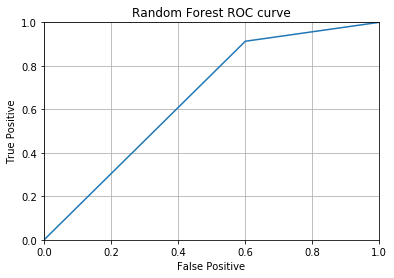

In [27]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Random Forest ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [28]:
_del_all()

### 7.9 Neural Network only standard columns

Neural Network summary: 

- alpha = 7
- hidden layers = 5
- batch size = 100

In [29]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [30]:
train_set = train_set.drop(columns=[*_cols_bin, *_cols_real])
train_set.shape

(558386, 753)

In [31]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

107


In [32]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 34s 86us/step - loss: 0.5951 - acc: 0.6957 - val_loss: 0.5575 - val_acc: 0.7210
Epoch 2/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5558 - acc: 0.7236 - val_loss: 0.5577 - val_acc: 0.7252
Epoch 3/100
390870/390870 [==============================] - 26s 66us/step - loss: 0.5467 - acc: 0.7305 - val_loss: 0.5468 - val_acc: 0.7331
Epoch 4/100
390870/390870 [==============================] - 26s 66us/step - loss: 0.5421 - acc: 0.7342 - val_loss: 0.5335 - val_acc: 0.7436
Epoch 5/100
390870/390870 [==============================] - 26s 65us/step - loss: 0.5401 - acc: 0.7360 - val_loss: 0.5426 - val_acc: 0.7396
Epoch 6/100
390870/390870 [==============================] - 26s 66us/step - loss: 0.5375 - acc: 0.7379 - val_loss: 0.5408 - val_acc: 0.7385
Epoch 7/100
390870/390870 [==============================] - 26s 66us/step - loss: 0.5345 - acc: 0.739

In [34]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_std.h5")

In [35]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 17s 31us/step
[0.5116986021793278, 0.7529630040865652]


In [36]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set = test_set.drop(columns=[*_cols_bin, *_cols_real])
test_set.shape

(153993, 753)

In [37]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [38]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [39]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.72      0.36      0.48     50930
           1       0.75      0.93      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.64      0.65    153993
weighted avg       0.74      0.74      0.71    153993

Accuracy for Deep Learning approach: 74.13713610358913


In [40]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[18245 32685]
 [ 7142 95921]]


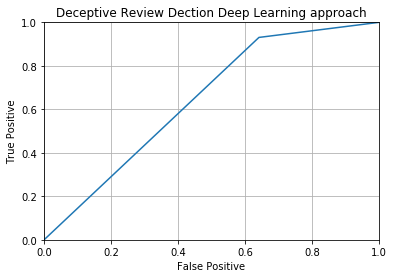

In [41]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [42]:
_del_all()

### 7.10 SVM only real columns

In [43]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [44]:
train_set = train_set.drop(columns=[*_cols_bin, *_cols_std])
train_set.shape

(558386, 754)

In [45]:
best_model = _jl.load("../models/best_SVM.joblib")
best_model.set_params(verbose=10)
best_model.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 10}

In [46]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[LibLinear]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=10)

In [47]:
_jl.dump(best_model, "../models/best_SVM_real.joblib")

['../models/best_SVM_real.joblib']

In [48]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

coef: [[-1.43716297e-01 -2.04535344e-01  3.42412756e-01 -1.70106570e-01
   9.42906076e-02 -7.64244164e-02  2.83228461e-05 -3.44367883e-02
   7.43154614e-03 -2.10748750e-05  6.42141961e-01 -7.67363295e-05
   1.05147224e-03  2.61865749e-04 -7.96263673e-04 -5.67863277e-04
  -6.66914030e-04  1.09450014e-03 -1.87557776e-04 -8.91209472e-05
   4.19307492e-04 -4.27875482e-05  8.48324927e-05 -8.68450895e-06
  -2.98160509e-04 -1.31943690e-01  4.98907004e-05 -4.09473030e-02
   2.69595801e-04  1.66887312e-02 -4.39124340e-04 -2.50972181e-04
   4.38847068e-05  1.61532968e-04 -9.42543009e-05  6.55236412e-02
  -6.76947062e-04  3.02737339e-02  2.37219033e-02  3.53476493e-02
   4.01342657e-02  5.32870518e-02  4.85615621e-02  1.44103811e-02
   2.56643390e-02  2.03262701e-02  4.17940324e-02 -1.24827229e-01
  -9.21161254e-02 -1.28367851e-01 -7.71161849e-02 -1.25495132e-01
  -1.42699889e-01 -1.26632389e-01 -1.07560837e-01 -1.11117980e-01
  -1.19877143e-01 -1.14195865e-01 -1.11238198e-01 -8.52179200e-02
  -8

In [49]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set = test_set.drop(columns=[*_cols_bin, *_cols_std])
test_set.shape

(153993, 754)

In [50]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

predictions:
 [0 0 0 ... 0 0 0]


In [51]:
set(predic)

{0, 1}

In [52]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], predic)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52     50930
           1       0.76      0.81      0.78    103063

    accuracy                           0.70    153993
   macro avg       0.66      0.65      0.65    153993
weighted avg       0.69      0.70      0.69    153993

Accuracy for Support Vector Machine: 70.01292266531595


In [53]:
# Confusion matrix for SVC

print("Confusion Matrix for SVC: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for SVC: 


array([[24734, 26196],
       [19982, 83081]], dtype=int64)

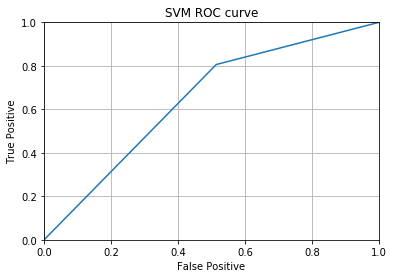

In [54]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("SVM ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [55]:
_del_all()

### 7.11 Random forest only real columns

In [56]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [57]:
train_set = train_set.drop(columns=[*_cols_bin, *_cols_std])
train_set.shape

(558386, 754)

In [58]:
params = _jl.load("../models/best_Random_Forest_2.joblib").get_params()
params['n_jobs'] = -1
params['verbose'] = 10
best_model = _RandomForestClassifier(**params)
best_model.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 10,
 'warm_start': False}

In [59]:
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000

building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000


building tree 13 of 1000


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.4s


building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.0s



building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.1s


building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min


building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min


building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.7min


building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.2min


building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.7min


building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.2min


building tree 101 of 1000
building tree 102 of 1000
building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 106 of 1000
building tree 107 of 1000
building tree 108 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000building tree 116 of 1000



[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.6min


building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  4.2min


building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000


[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.7min


building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000


[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  5.4min


building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.0min



building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tree 209 of 1000


[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  6.7min


building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tree 226 of 1000
building tree 227 of 1000
building tree 228 of 1000
building tree 229 of 1000


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  7.6min


building tree 230 of 1000
building tree 231 of 1000
building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
building tree 235 of 1000
building tree 236 of 1000
building tree 237 of 1000
building tree 238 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 244 of 1000
building tree 245 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 250 of 1000
building tree 251 of 1000
building tree 252 of 1000


[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:  8.3min


building tree 253 of 1000
building tree 254 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 259 of 1000
building tree 260 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 270 of 1000
building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 275 of 1000


[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.1min


building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000


[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  9.9min


building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000


[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed: 10.8min


building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 11.6min


building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000


[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed: 12.5min


building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000


[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 13.5min


building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000
building tree 417 of 1000
building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 425 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tree 431 of 1000
building tree 432 of 1000
building tree 433 of 1000
building tree 434 of 1000
building tree 435 of 1000
building tree 436 of 1000
building tree 437 of 1000
building tree 438 of 1000
building tree 439 of 1000


[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 14.4min


building tree 440 of 1000
building tree 441 of 1000
building tree 442 of 1000
building tree 443 of 1000
building tree 444 of 1000
building tree 445 of 1000
building tree 446 of 1000
building tree 447 of 1000
building tree 448 of 1000
building tree 449 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tree 455 of 1000
building tree 456 of 1000
building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 467 of 1000
building tree 468 of 1000


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed: 15.5min


building tree 469 of 1000
building tree 470 of 1000
building tree 471 of 1000
building tree 472 of 1000
building tree 473 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tree 476 of 1000
building tree 477 of 1000
building tree 478 of 1000
building tree 479 of 1000
building tree 480 of 1000
building tree 481 of 1000
building tree 482 of 1000
building tree 483 of 1000
building tree 484 of 1000
building tree 485 of 1000
building tree 486 of 1000
building tree 487 of 1000
building tree 488 of 1000
building tree 489 of 1000
building tree 490 of 1000
building tree 491 of 1000
building tree 492 of 1000
building tree 493 of 1000
building tree 494 of 1000
building tree 495 of 1000
building tree 496 of 1000
building tree 497 of 1000
building tree 498 of 1000
building tree 499 of 1000
building tree 500 of 1000


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.5min


building tree 501 of 1000
building tree 502 of 1000
building tree 503 of 1000
building tree 504 of 1000
building tree 505 of 1000
building tree 506 of 1000
building tree 507 of 1000
building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000


[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed: 17.7min


building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 561 of 1000
building tree 562 of 1000
building tree 563 of 1000
building tree 564 of 1000
building tree 565 of 1000


[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed: 18.7min


building tree 566 of 1000
building tree 567 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 570 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 574 of 1000
building tree 575 of 1000
building tree 576 of 1000
building tree 577 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 580 of 1000
building tree 581 of 1000
building tree 582 of 1000
building tree 583 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 586 of 1000
building tree 587 of 1000
building tree 588 of 1000
building tree 589 of 1000
building tree 590 of 1000
building tree 591 of 1000
building tree 592 of 1000
building tree 593 of 1000
building tree 594 of 1000
building tree 595 of 1000
building tree 596 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 599 of 1000
building tree 600 of 1000
building tree 601 of 1000


[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed: 19.9min


building tree 602 of 1000
building tree 603 of 1000
building tree 604 of 1000
building tree 605 of 1000
building tree 606 of 1000
building tree 607 of 1000
building tree 608 of 1000
building tree 609 of 1000
building tree 610 of 1000
building tree 611 of 1000
building tree 612 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 21.0min


building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000


[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed: 22.1min


building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
building tree 703 of 1000
building tree 704 of 1000
building tree 705 of 1000
building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 709 of 1000


[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed: 23.4min


building tree 710 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 717 of 1000
building tree 718 of 1000
building tree 719 of 1000
building tree 720 of 1000
building tree 721 of 1000
building tree 722 of 1000
building tree 723 of 1000
building tree 724 of 1000
building tree 725 of 1000
building tree 726 of 1000
building tree 727 of 1000
building tree 728 of 1000
building tree 729 of 1000
building tree 730 of 1000
building tree 731 of 1000
building tree 732 of 1000
building tree 733 of 1000
building tree 734 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 739 of 1000
building tree 740 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 743 of 1000
building tree 744 of 1000
building tree 745 of 1000
building tree 746 of 1000
building tree 747 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 737 tasks      | elapsed: 24.7min


building tree 749 of 1000
building tree 750 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 753 of 1000
building tree 754 of 1000
building tree 755 of 1000
building tree 756 of 1000
building tree 757 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 760 of 1000
building tree 761 of 1000
building tree 762 of 1000
building tree 763 of 1000
building tree 764 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 769 of 1000
building tree 770 of 1000
building tree 771 of 1000
building tree 772 of 1000
building tree 773 of 1000
building tree 774 of 1000
building tree 775 of 1000
building tree 776 of 1000
building tree 777 of 1000
building tree 778 of 1000
building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 26.0min


building tree 789 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tree 826 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed: 27.4min


building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000
building tree 842 of 1000
building tree 843 of 1000
building tree 844 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tree 854 of 1000
building tree 855 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 858 of 1000building tree 859 of 1000

building tree 860 of 1000
building tree 861 of 1000
building tree 862 of 1000
building tree 863 of 1000
building tree 864 of 1000
building tree 865 of 1000
building tree 866 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 28.7min


building tree 870 of 1000
building tree 871 of 1000
building tree 872 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tree 875 of 1000
building tree 876 of 1000
building tree 877 of 1000
building tree 878 of 1000
building tree 879 of 1000
building tree 880 of 1000
building tree 881 of 1000
building tree 882 of 1000
building tree 883 of 1000
building tree 884 of 1000
building tree 885 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 888 of 1000
building tree 889 of 1000
building tree 890 of 1000
building tree 891 of 1000
building tree 892 of 1000
building tree 893 of 1000
building tree 894 of 1000building tree 895 of 1000

building tree 896 of 1000
building tree 897 of 1000
building tree 898 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 902 of 1000
building tree 903 of 1000
building tree 904 of 1000
building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 901 tasks      | elapsed: 30.2min


building tree 913 of 1000
building tree 914 of 1000
building tree 915 of 1000
building tree 916 of 1000
building tree 917 of 1000
building tree 918 of 1000
building tree 919 of 1000
building tree 920 of 1000
building tree 921 of 1000
building tree 922 of 1000
building tree 923 of 1000
building tree 924 of 1000
building tree 925 of 1000
building tree 926 of 1000
building tree 927 of 1000
building tree 928 of 1000
building tree 929 of 1000
building tree 930 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 935 of 1000
building tree 936 of 1000
building tree 937 of 1000
building tree 938 of 1000
building tree 939 of 1000
building tree 940 of 1000
building tree 941 of 1000
building tree 942 of 1000
building tree 943 of 1000
building tree 944 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 947 of 1000
building tree 948 of 1000
building tree 949 of 1000
building tree 950 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 31.6min


building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 33.3min finished


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=10, warm_start=False)

In [60]:
_jl.dump(best_model, "../models/best_Random_Forest_real.joblib")

['../models/best_Random_Forest_real.joblib']

In [61]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set = test_set.drop(columns=[*_cols_bin, *_cols_std])
test_set.shape

(153993, 754)

In [62]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    4.5s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

predictions:
 [0 0 1 ... 0 1 0]


In [63]:
set(predic)

{0, 1}

In [64]:
# evaluate classifier

print("Report for Random Forest classifier:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Random Forest Classifier:", _accuracy_score(test_set['likes'], predic)*100)

Report for Random Forest classifier:
              precision    recall  f1-score   support

           0       0.70      0.39      0.50     50930
           1       0.75      0.92      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.65      0.67    153993
weighted avg       0.74      0.74      0.72    153993

Accuracy for Random Forest Classifier: 74.34039209574462


In [65]:
# Confusion matrix for Random Forest

print("Confusion Matrix for Random Forest: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for Random Forest: 


array([[20055, 30875],
       [ 8639, 94424]], dtype=int64)

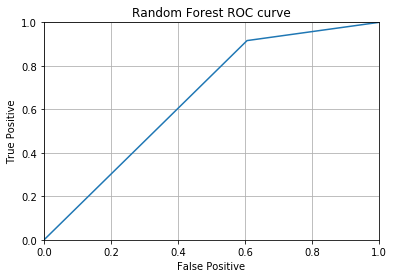

In [66]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Random Forest ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [67]:
_del_all()

### 7.12 Neural Network only real columns

Neural Network summary: 

- alpha = 7
- hidden layers = 5
- batch size = 100

In [68]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.shape

(558386, 787)

In [69]:
train_set = train_set.drop(columns=[*_cols_bin, *_cols_std])
train_set.shape

(558386, 754)

In [70]:
# Number of neurons for hiddens layer
number_samples, number_features = train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']).shape

number_input_neurons = number_features
number_output_neurons = 1
number_train_semples = number_samples
alpha = 7

number_hidden_neurons = round(number_train_semples / (alpha * (number_input_neurons + number_output_neurons)))
print(number_hidden_neurons)

106


In [71]:
classifier = _Sequential()

# First Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal', input_dim = number_features))

# Second Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Third Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fourth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Fifth Hidden Layer
classifier.add(_Dense(number_hidden_neurons, activation = 'relu', kernel_initializer = 'random_normal'))

# Output Layer
classifier.add(_Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

# Compiling the neural network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [72]:
# Fitting the data to the training dataset
classifier.fit(train_set.drop(
    columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']),
    train_set['likes'], validation_split = 0.3, batch_size = 100, epochs = 100)

Train on 390870 samples, validate on 167516 samples
Epoch 1/100
390870/390870 [==============================] - 28s 72us/step - loss: 0.5946 - acc: 0.6956 - val_loss: 0.5614 - val_acc: 0.7157
Epoch 2/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5553 - acc: 0.7237 - val_loss: 0.5431 - val_acc: 0.7351
Epoch 3/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5458 - acc: 0.7312 - val_loss: 0.5414 - val_acc: 0.7347
Epoch 4/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5414 - acc: 0.7351 - val_loss: 0.5421 - val_acc: 0.7341
Epoch 5/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5393 - acc: 0.7358 - val_loss: 0.5328 - val_acc: 0.7411
Epoch 6/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5361 - acc: 0.7378 - val_loss: 0.5395 - val_acc: 0.7355
Epoch 7/100
390870/390870 [==============================] - 26s 67us/step - loss: 0.5336 - acc: 0.739

In [73]:
# Save trained model
classifier.save("../models/trained_deep_neural_network_real.h5")

In [74]:
# evaluation of the model training
evaluation = classifier.evaluate(train_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])
print(evaluation)

558386/558386 [==============================] - 17s 30us/step
[0.5069156529383092, 0.7561507630928384]


In [75]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set = test_set.drop(columns=[*_cols_bin, *_cols_std])
test_set.shape

(153993, 754)

In [76]:
prediction = classifier.predict(test_set.drop(columns = ['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
binary_prediction = _binarize(prediction, threshold = 0.5)
binary_prediction

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [77]:
set(binary_prediction[:,0])

{0.0, 1.0}

In [78]:
print("Report for Deep Learning approach:")
print(_classification_report(test_set['likes'], binary_prediction))

print("Accuracy for Deep Learning approach:", _accuracy_score(test_set['likes'], binary_prediction) * 100)

Report for Deep Learning approach:
              precision    recall  f1-score   support

           0       0.70      0.39      0.51     50930
           1       0.75      0.92      0.83    103063

    accuracy                           0.74    153993
   macro avg       0.73      0.66      0.67    153993
weighted avg       0.74      0.74      0.72    153993

Accuracy for Deep Learning approach: 74.43974726123915


In [79]:
matrix = _confusion_matrix(test_set['likes'], binary_prediction)
print(matrix)

[[20079 30851]
 [ 8510 94553]]


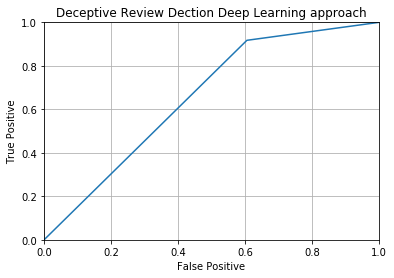

In [80]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], binary_prediction)

_plt.plot(fpr, tpr)
_plt.xlim([0.0, 1.0])
_plt.ylim([0.0, 1.0])

_plt.title("Neural Network ROC curve")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [81]:
_del_all()